In [2]:
%load_ext cython

In [41]:
################################################################"

In [42]:
################################################

In [43]:
%%cython
# Final Cython code for Jupyter Notebook
# - All pointer declarations separated.
# - All cdef variables declared at function start.
# - All global assignments fixed.
# - ALL RUNS OUTPUT TO ONE FILE ("all_runs.txt").

from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

cdef int NBITEMS = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 0
cdef int ni = 0
cdef double *capacities
cdef int **weights
cdef int **profits
cdef double *vector_weight
cdef double max_bound = 0.0
cdef double **OBJ_Weights
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i
    cdef int f
    with open(filename.decode(), "r") as source:
        line = source.readline()
        nf, ni = [int(x) for x in line.strip().split()]
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            capacities[f] = float(source.readline().strip())
            for i in range(ni):
                _ = source.readline()
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf
    cdef int i
    cdef int j
    with open(filename.decode(), "r") as f:
        lines = f.readlines()
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(10000 * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = len(lines) - 1

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j
    cdef int r
    cdef int tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j
    cdef int l
    cdef int k
    cdef int faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i
    cdef int x
    cdef int tmp
    cdef int t = max(alpha, Sarchive.size)
    cdef int shuffle[28000]
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i
    cdef int j
    cdef int dom
    cdef int t = archive.size + P.size
    cdef pop *archiveAndP = create_pop(t, nf)
    cdef int convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i
    cdef int j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i
    cdef int j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i
    cdef int worst = -1
    cdef double worst_fit
    cdef double fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i
    cdef int j
    cdef int r
    cdef int t
    cdef int k
    cdef int l
    cdef int v
    cdef int sol
    cdef int mino
    cdef int mp
    cdef int maxp
    cdef int consistant
    cdef int pos
    cdef int stop
    cdef int convergence
    cdef int ii
    cdef int tmp_pris
    cdef int tmp_nonpris
    cdef int remplace[50]
    cdef int taille
    cdef int feasible
    cdef int tv
    cdef int IM
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        convergence = 0
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    while True:
                        mino = irand(NBITEMS)
                        if x.Items[mino] == 1:
                            break
                    x.Items[mino] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][mino]
                        x.f[r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(NBITEMS)
                            if x.Items[maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x.capa[r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x.Items[maxp] = 1
                                    x.nombr_nonpris -= 1
                                    x.nombr += 1
                                    for r in range(nf):
                                        x.capa[r] += weights[r][maxp]
                                        x.f[r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[mino] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][mino]
                            x.f[r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break

# Callable from Python
def run_moacp():
    import time as pytime
    global nf, ni, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights
    NBL = 100
    total_runtime = 0.0

    # Overwrite the output file at the start
    open("all_runs.txt", "w").close()

    for run in range(10): # 10 runs
        total_start_time = pytime.time()
        seed(run + 1)
        nextLn = 0
        inv = 0
        loadMOKP(b"250.2.txt")
        read_weights_file(b"Weights_2obj_FQ200.txt")
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
        P = create_pop(paretoIni, nf)
        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)
            Indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)
        # Append results for this run to one file
        with open("all_runs.txt", "a") as fpareto:
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")
        complete_free_pop(P)
        total_end_time = pytime.time()
        total_runtime += (total_end_time - total_start_time)
    print(f"\nAll 10 runs finished. Total runtime: {total_runtime:.6f} seconds")

In [44]:
run_moacp()


All 10 runs finished. Total runtime: 4.452168 seconds


In [45]:
objs = []

with open("all_runs.txt") as f:
    for line in f:
        parts = line.split()
        # For two objectives:
        if len(parts) >= 2:
            objs.append([float(parts[0]), float(parts[1])])
        # For three objectives (uncomment if needed):
        #objs.append([float(parts[0]), float(parts[1]), float(parts[2])])

print(f"Total number of solutions: {len(objs)}")

Total number of solutions: 1413


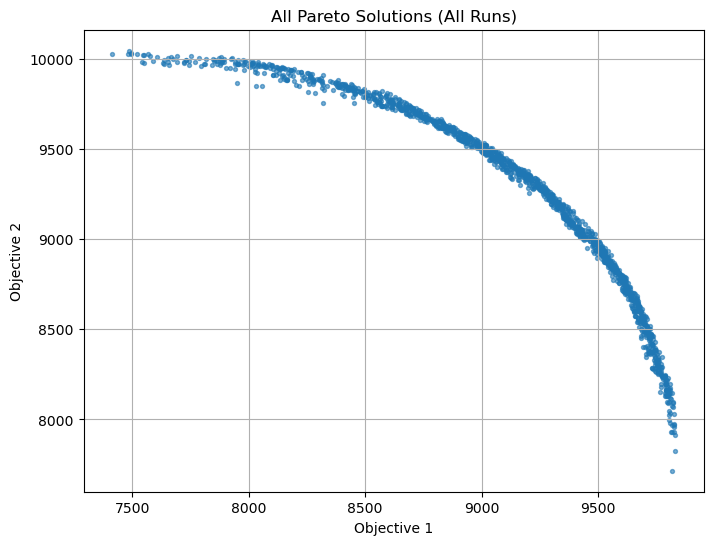

In [46]:
import matplotlib.pyplot as plt

# For two objectives
x = [o[0] for o in objs]
y = [o[1] for o in objs]

plt.figure(figsize=(8,6))
plt.scatter(x, y, s=8, alpha=0.6)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("All Pareto Solutions (All Runs)")
plt.grid(True)
plt.show()

In [47]:
# For two objectives
solutions = []
with open("all_runs.txt") as f:
    for line in f:
        parts = line.split()
        if len(parts) >= 2:
            solutions.append([float(parts[0]), float(parts[1])])

In [48]:
def pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if j != i:
                # q dominates p if it is at least as good in both objectives and better in at least one
                if (q[0] >= p[0] and q[1] >= p[1]) and (q[0] > p[0] or q[1] > p[1]):
                    dominated = True
                    break
        if not dominated:
            pareto.append(p)
    return pareto

pareto_points = pareto_front(solutions)
print(f"Number of Pareto solutions: {len(pareto_points)}")

Number of Pareto solutions: 212


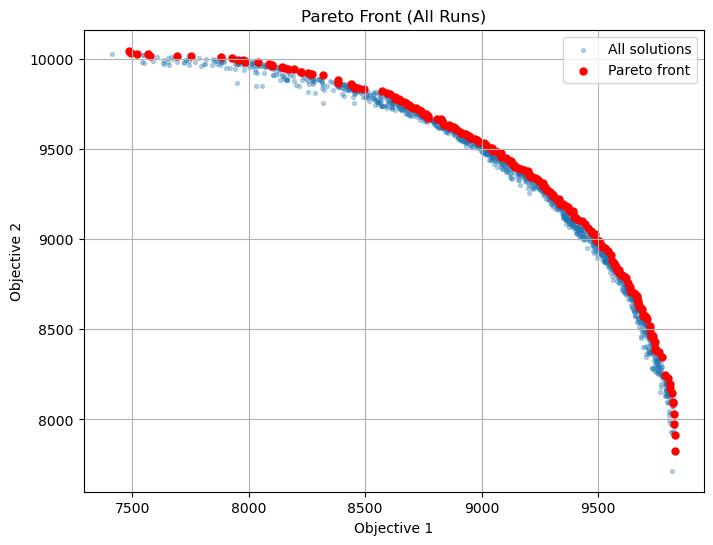

In [49]:
import matplotlib.pyplot as plt

x_all = [p[0] for p in solutions]
y_all = [p[1] for p in solutions]
x_pf  = [p[0] for p in pareto_points]
y_pf  = [p[1] for p in pareto_points]

plt.figure(figsize=(8,6))
plt.scatter(x_all, y_all, s=8, alpha=0.3, label="All solutions")
plt.scatter(x_pf, y_pf, s=25, color='red', label="Pareto front")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Pareto Front (All Runs)")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
#################################################################

In [2]:
%%cython

# Improved Cython code for Jupyter Notebook
# - Global memory cleanup
# - Dynamic array sizing
# - Robust file parsing
# - Output all runs to "all_runs.txt"

from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

cdef int NBITEMS = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 0
cdef int ni = 0
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0

cdef int OBJ_Weights_lines = 0

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i
    cdef int f
    if capacities != NULL or weights != NULL or profits != NULL:
        cleanup_globals()
    with open(filename.decode(), "r") as source:
        line = source.readline()
        parts = line.strip().split()
        if len(parts) < 2:
            raise ValueError("First line must have nf and ni.")
        nf, ni = [int(x) for x in parts]
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            line = source.readline()
            if not line:
                raise ValueError("Missing capacity line.")
            capacities[f] = float(line.strip())
            for i in range(ni):
                source.readline()
                w_line = source.readline()
                p_line = source.readline()
                if not w_line or not p_line:
                    raise ValueError(f"Missing weights/profits for item {i} in objective {f}.")
                weights[f][i] = int(w_line.strip())
                profits[f][i] = int(p_line.strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        if len(vals) < nf:
            raise ValueError(f"Line {i} in weights file does not have {nf} values: {line}")
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence, ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        convergence = 0
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    while True:
                        mino = irand(NBITEMS)
                        if x.Items[mino] == 1:
                            break
                    x.Items[mino] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][mino]
                        x.f[r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(NBITEMS)
                            if x.Items[maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x.capa[r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x.Items[maxp] = 1
                                    x.nombr_nonpris -= 1
                                    x.nombr += 1
                                    for r in range(nf):
                                        x.capa[r] += weights[r][maxp]
                                        x.f[r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[mino] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][mino]
                            x.f[r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    free(remplace)

def run_moacp():
    """
    Main function for running the MOACP algorithm.
    All global allocations are cleaned up after each run.
    Output for all runs is written to 'all_runs.txt'.
    Array sizes and file parsing are robust to file contents.
    """
    import time as pytime
    global nf, ni, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights
    NBL = 100
    total_runtime = 0.0

    open("all_runs.txt", "w").close()

    for run in range(10): # 10 runs
        total_start_time = pytime.time()
        seed(run + 1)
        nextLn = 0
        inv = 0
        loadMOKP(b"250.2.txt")
        read_weights_file(b"Weights_2obj_FQ200.txt")
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
        P = create_pop(paretoIni, nf)
        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)
            Indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)
        with open("all_runs.txt", "a") as fpareto:
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")
        complete_free_pop(P)
        cleanup_globals()
        total_end_time = pytime.time()
        total_runtime += (total_end_time - total_start_time)
    print(f"\nAll 10 runs finished. Total runtime: {total_runtime:.6f} seconds")

In [3]:
run_moacp()


All 10 runs finished. Total runtime: 4.054594 seconds


In [4]:
objs = []

with open("all_runs.txt") as f:
    for line in f:
        parts = line.split()
        # For two objectives:
        if len(parts) >= 2:
            objs.append([float(parts[0]), float(parts[1])])
        # For three objectives (uncomment if needed):
        #objs.append([float(parts[0]), float(parts[1]), float(parts[2])])

print(f"Total number of solutions: {len(objs)}")

Total number of solutions: 1413


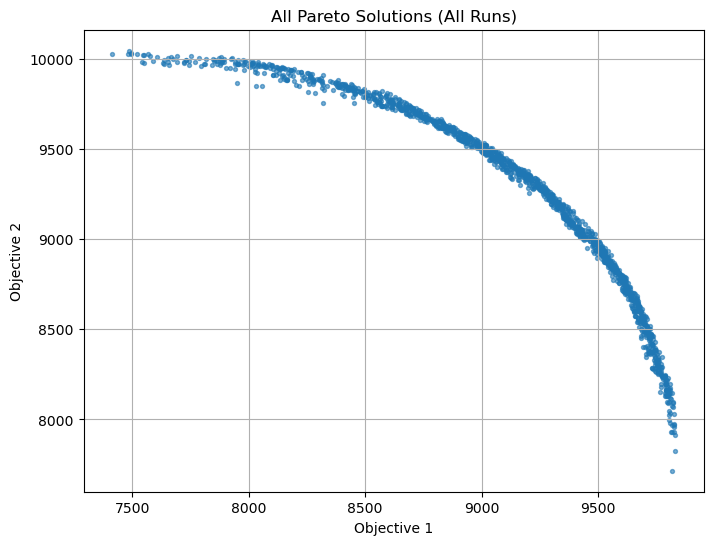

In [5]:
import matplotlib.pyplot as plt

# For two objectives
x = [o[0] for o in objs]
y = [o[1] for o in objs]

plt.figure(figsize=(8,6))
plt.scatter(x, y, s=8, alpha=0.6)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("All Pareto Solutions (All Runs)")
plt.grid(True)
plt.show()

In [6]:
# For two objectives
solutions = []
with open("all_runs.txt") as f:
    for line in f:
        parts = line.split()
        if len(parts) >= 2:
            solutions.append([float(parts[0]), float(parts[1])])

In [7]:
def pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if j != i:
                # q dominates p if it is at least as good in both objectives and better in at least one
                if (q[0] >= p[0] and q[1] >= p[1]) and (q[0] > p[0] or q[1] > p[1]):
                    dominated = True
                    break
        if not dominated:
            pareto.append(p)
    return pareto

pareto_points = pareto_front(solutions)
print(f"Number of Pareto solutions: {len(pareto_points)}")

Number of Pareto solutions: 212


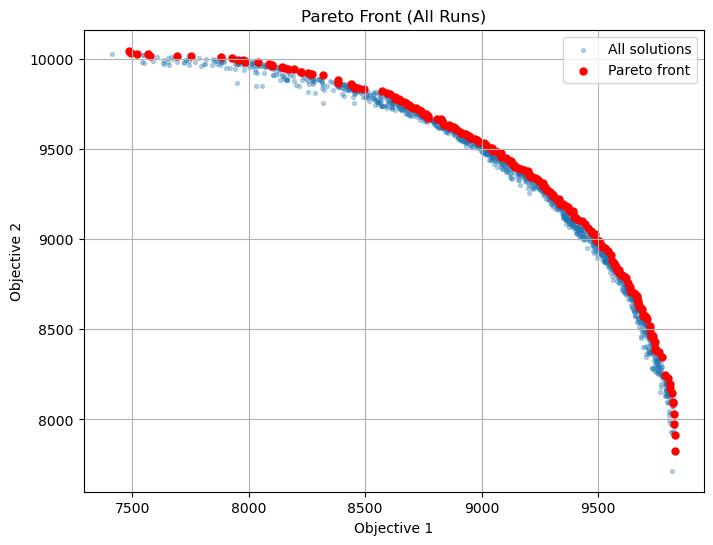

In [8]:
import matplotlib.pyplot as plt

x_all = [p[0] for p in solutions]
y_all = [p[1] for p in solutions]
x_pf  = [p[0] for p in pareto_points]
y_pf  = [p[1] for p in pareto_points]

plt.figure(figsize=(8,6))
plt.scatter(x_all, y_all, s=8, alpha=0.3, label="All solutions")
plt.scatter(x_pf, y_pf, s=25, color='red', label="Pareto front")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Pareto Front (All Runs)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
############################################################

In [3]:
%%cython

# Cython code for Jupyter Notebook to run multiple instances and output results
# - Accepts parameters for instance file, weights file, NBITEMS, nf, output file
# - Cleans up memory between runs
# - Output format matches C code: one run per output file

from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

# These will be reset per problem instance/run
cdef int NBITEMS = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 0
cdef int ni = 0
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(NBITEMS * sizeof(int))
    p_ind.Items = <int *>chk_malloc(NBITEMS * sizeof(int))
    for i in range(NBITEMS):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(NBITEMS):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i
    cdef int f
    with open(filename.decode(), "r") as source:
        line = source.readline()
        parts = line.strip().split()
        nf, ni = [int(x) for x in parts]
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            weights[f] = <int *>chk_malloc(NBITEMS * sizeof(int))
            profits[f] = <int *>chk_malloc(NBITEMS * sizeof(int))
            capacities[f] = float(source.readline().strip())
            for i in range(NBITEMS):
                source.readline()
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(NBITEMS):
        x.d[j] = j
    for j in range(NBITEMS):
        r = irand(NBITEMS)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(NBITEMS):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence, ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        convergence = 0
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    while True:
                        mino = irand(NBITEMS)
                        if x.Items[mino] == 1:
                            break
                    x.Items[mino] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][mino]
                        x.f[r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(NBITEMS)
                            if x.Items[maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x.capa[r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x.Items[maxp] = 1
                                    x.nombr_nonpris -= 1
                                    x.nombr += 1
                                    for r in range(nf):
                                        x.capa[r] += weights[r][maxp]
                                        x.f[r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[mino] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][mino]
                            x.f[r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    free(remplace)

def run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file):
    """
    Run MOACP for a given instance, weights file, item count, objectives, and output file.
    Output is written to `output_file` (same format as C code).
    """
    import time as pytime
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights

    NBITEMS = nbitems
    nf = num_objectives
    nextLn = 0
    inv = 0

    seed(1)

    loadMOKP(instance_file)
    read_weights_file(weights_file)
    vector_weight = <double *>chk_malloc(nf * sizeof(double))
    P = create_pop(paretoIni, nf)
    NBL = 100

    it = 0
    while it < NBL:
        solutions = create_pop(alpha, nf)
        archive = create_pop(paretoIni, nf)
        choose_weight()
        P_init_pop(solutions, P, alpha)
        extractPtoArchive(solutions, P)
        calcul_weight(solutions, alpha)
        calcMaxbound(solutions, alpha)
        compute_all_fitness(solutions)
        Indicator_local_search1(solutions, archive, alpha)
        extractPtoArchive(archive, P)
        it += 1
        complete_free_pop(solutions)
        complete_free_pop(archive)

    with open(output_file, "w") as fpareto:
        for i in range(P.size):
            for j in range(nf):
                fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
            fpareto.write("\n")
    complete_free_pop(P)
    cleanup_globals()

In [4]:
instances = [
    "250.2.txt", "250.3.txt", "250.4.txt",
    "500.2.txt", "500.3.txt", "500.4.txt", 
    "750.2.txt", "750.3.txt", "750.4.txt"
]
weights_files = {
    2: "Weights_2obj_FQ200.txt",
    3: "Weights_3obj_FQ100.txt",
    4: "Weights_4obj_FQ40.txt"
}
nbitems_map = {"250": 250, "500": 500, "750": 750}
for instance in instances:
    parts = instance.replace(".txt", "").split(".")
    nbitems = nbitems_map[parts[0]]
    nf = int(parts[1])
    weights_file = weights_files[nf]
    output_file = f"{parts[0]}{parts[1]}_Resulats.txt"
    run_moacp(instance.encode(), weights_file.encode(), nbitems, nf, output_file)

In [9]:
!A:\conda\envs\ibmols\python.exe -m pip install pandas

   ---------------------------------------- 0.0/11.4 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.4 MB 3.4 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/11.4 MB 3.4 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.4 MB 3.4 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/11.4 MB 3.4 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/11.4 MB 3.4 MB/s eta 0:00:03
   -------------- ------------------------- 4.2/11.4 MB 3.4 MB/s eta 0:00:03
   ----------------- ---------------------- 5.0/11.4 MB 3.4 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.4 MB 3.4 MB/s eta 0:00:02
   ---------------------- ----------------- 6.3/11.4 MB 3.3 MB/s eta 0:00:02
   ------------------------ --------------- 6.8/11.4 MB 3.3 MB/s eta 0:00:02
   -------------------------- ------------- 7.6/11.4 MB 3.3 MB/s eta 0:00:02
   ----------------------------- ---------- 8.4/11.4 MB 3.3 MB/s eta 0:00:01
   ---


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: A:\conda\envs\ibmols\python.exe -m pip install --upgrade pip


In [14]:
!A:\conda\envs\ibmols\python.exe -m pip install matplotlib seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: A:\conda\envs\ibmols\python.exe -m pip install --upgrade pip


In [15]:
import pandas as pd

# For example, for 2 objectives:
df = pd.read_csv("2502_Resulats.txt", sep=" ", header=None)
df = df.dropna(axis=1, how='all')  # Remove empty columns if any
df.columns = [f'Obj{i+1}' for i in range(df.shape[1])]

df.head()

Obj1     Obj2
0  7880.0  10007.0
1  7926.0  10002.0
2  7975.0   9990.0
3  8088.0   9969.0
4  8145.0   9947.0

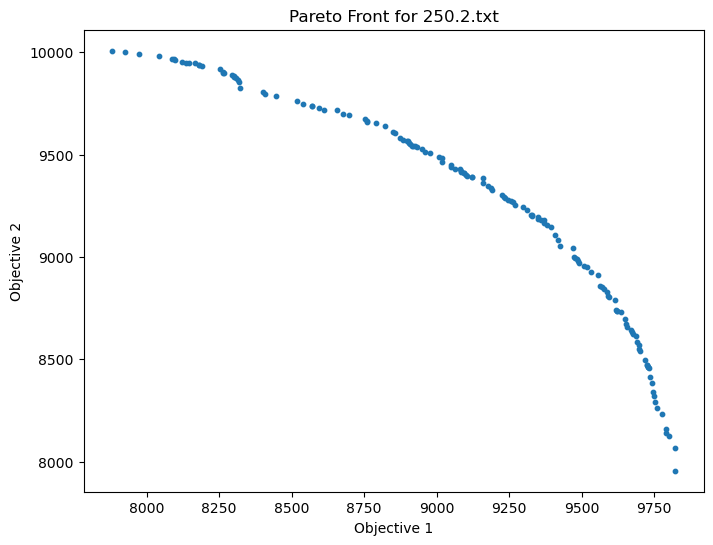

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df['Obj1'], df['Obj2'], s=10)
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front for 250.2.txt')
plt.show()

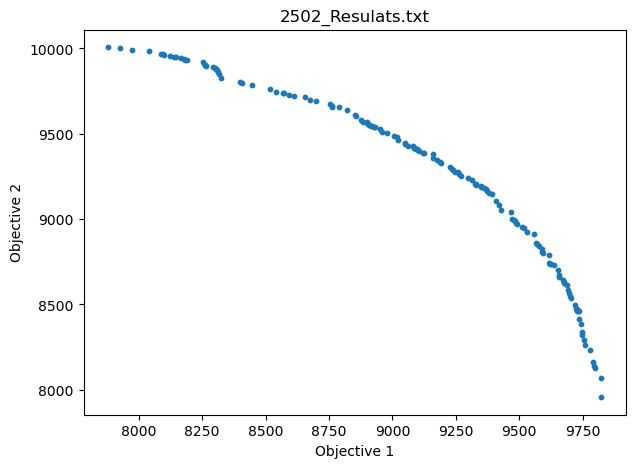

<Figure size 700x500 with 0 Axes>

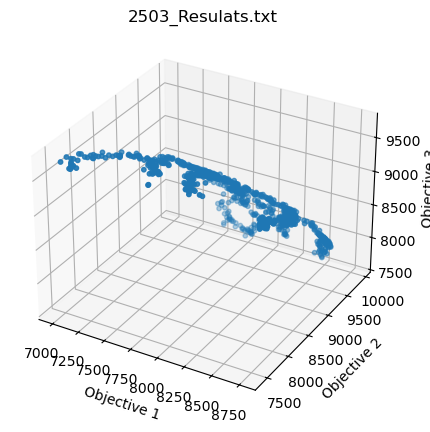

<Figure size 700x500 with 0 Axes>

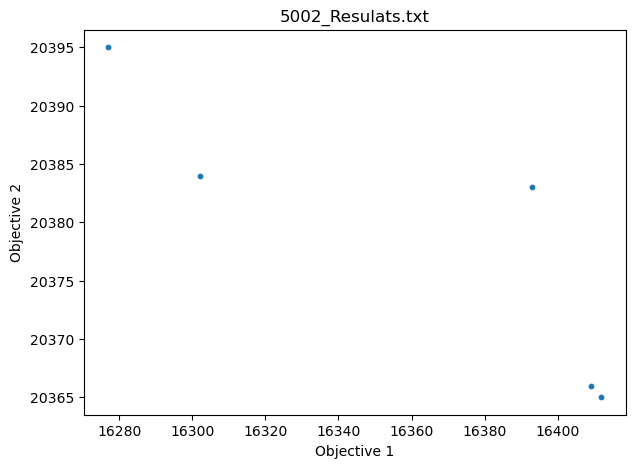

<Figure size 700x500 with 0 Axes>

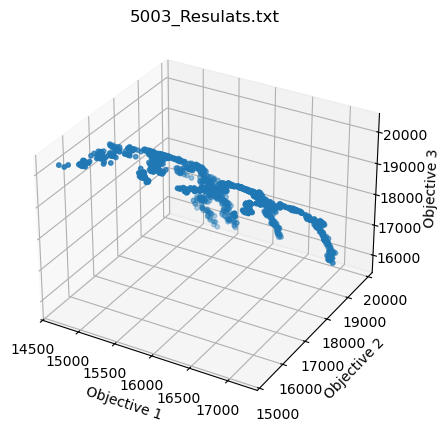

<Figure size 700x500 with 0 Axes>

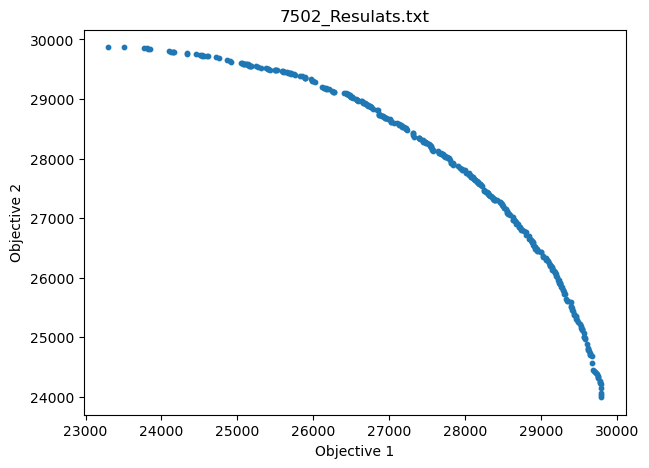

<Figure size 700x500 with 0 Axes>

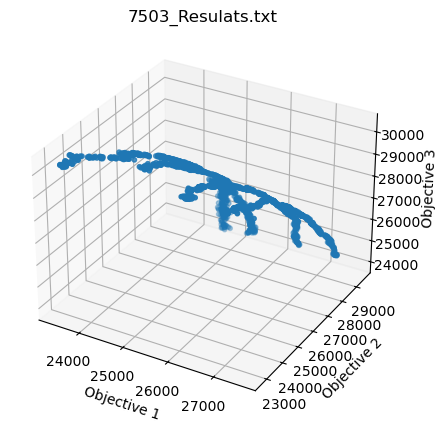

<Figure size 700x500 with 0 Axes>

In [17]:
instances = [
    "2502_Resulats.txt", "2503_Resulats.txt", "2504_Resulats.txt",
    "5002_Resulats.txt", "5003_Resulats.txt", "5004_Resulats.txt", 
    "7502_Resulats.txt", "7503_Resulats.txt", "7504_Resulats.txt"
]

for filename in instances:
    df = pd.read_csv(filename, sep=" ", header=None)
    df = df.dropna(axis=1, how='all')
    n_obj = df.shape[1]
    df.columns = [f'Obj{i+1}' for i in range(n_obj)]
    plt.figure(figsize=(7,5))
    if n_obj == 2:
        plt.scatter(df['Obj1'], df['Obj2'], s=10)
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.title(filename)
        plt.show()
    elif n_obj == 3:
        fig = plt.figure(figsize=(7,5))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(df['Obj1'], df['Obj2'], df['Obj3'], s=10)
        ax.set_xlabel('Objective 1')
        ax.set_ylabel('Objective 2')
        ax.set_zlabel('Objective 3')
        plt.title(filename)
        plt.show()
    # For 4 objectives or more, you may want to use pairplot (seaborn) or other advanced visualization

In [18]:
import os

instances = [
    "2502_Resulats.txt", "2503_Resulats.txt", "2504_Resulats.txt",
    "5002_Resulats.txt", "5003_Resulats.txt", "5004_Resulats.txt", 
    "7502_Resulats.txt", "7503_Resulats.txt", "7504_Resulats.txt"
]

for filename in instances:
    if os.path.exists(filename):
        with open(filename) as f:
            num_solutions = sum(1 for _ in f if _.strip())
        print(f"{filename}: {num_solutions} solutions")
    else:
        print(f"{filename}: File not found")

2502_Resulats.txt: 149 solutions
2503_Resulats.txt: 803 solutions
2504_Resulats.txt: 1053 solutions
5002_Resulats.txt: 5 solutions
5003_Resulats.txt: 1455 solutions
5004_Resulats.txt: 1877 solutions
7502_Resulats.txt: 399 solutions
7503_Resulats.txt: 2063 solutions
7504_Resulats.txt: 2783 solutions


In [19]:
##########################################################################################################

In [20]:
%%cython
# Cython code for Jupyter Notebook MOACP instance runner - fully dynamic!
# - NBITEMS and ni are set per run (no hardcoding)
# - All allocations and loops use ni (which is set to NBITEMS)
# - Output file and parameters are dynamic
# - Safe for multiple runs in a Jupyter session

from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

# Globals reset per run!
cdef int NBITEMS = 250
cdef int ni = 250 # ALWAYS set ni = NBITEMS for allocations/loops!
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 2
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i
    cdef int f
    with open(filename.decode(), "r") as source:
        line = source.readline()
        parts = line.strip().split()
        nf, ni = [int(x) for x in parts] # ni from file is ignored below, overwritten by global ni
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            capacities[f] = float(source.readline().strip())
            for i in range(ni):
                source.readline()
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence, ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        convergence = 0
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    while True:
                        mino = irand(ni)
                        if x.Items[mino] == 1:
                            break
                    x.Items[mino] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][mino]
                        x.f[r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(ni)
                            if x.Items[maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x.capa[r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x.Items[maxp] = 1
                                    x.nombr_nonpris -= 1
                                    x.nombr += 1
                                    for r in range(nf):
                                        x.capa[r] += weights[r][maxp]
                                        x.f[r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[mino] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][mino]
                            x.f[r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    free(remplace)

def run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file):
    """
    Run MOACP for a given instance, weights file, item count, objectives, and output file.
    Output is written to `output_file` (same format as C code).
    """
    import time as pytime
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights

    NBITEMS = nbitems
    ni = nbitems   # <-- All allocations and loops use ni!
    nf = num_objectives
    nextLn = 0
    inv = 0

    print(f"Running {instance_file.decode()} with NBITEMS={NBITEMS}, nf={nf} => {output_file}")

    seed(1)

    loadMOKP(instance_file)
    read_weights_file(weights_file)
    vector_weight = <double *>chk_malloc(nf * sizeof(double))
    P = create_pop(paretoIni, nf)
    NBL = 100

    it = 0
    while it < NBL:
        solutions = create_pop(alpha, nf)
        archive = create_pop(paretoIni, nf)
        choose_weight()
        P_init_pop(solutions, P, alpha)
        extractPtoArchive(solutions, P)
        calcul_weight(solutions, alpha)
        calcMaxbound(solutions, alpha)
        compute_all_fitness(solutions)
        Indicator_local_search1(solutions, archive, alpha)
        extractPtoArchive(archive, P)
        it += 1
        complete_free_pop(solutions)
        complete_free_pop(archive)

    with open(output_file, "w") as fpareto:
        for i in range(P.size):
            for j in range(nf):
                fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
            fpareto.write("\n")
    complete_free_pop(P)
    cleanup_globals()

Content of stdout:
_cython_magic_a1eb6f4d78e9992484421b82b4ef4e0d87ae57fe0aca2b83fa2f125e6c2b121b.c
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_a1eb6f4d78e9992484421b82b4ef4e0d87ae57fe0aca2b83fa2f125e6c2b121b.c(4654): warning C4244: '='ÿ: conversion de 'double' en 'float', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_a1eb6f4d78e9992484421b82b4ef4e0d87ae57fe0aca2b83fa2f125e6c2b121b.c(4744): warning C4244: '='ÿ: conversion de 'double' en 'float', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_a1eb6f4d78e9992484421b82b4ef4e0d87ae57fe0aca2b83fa2f125e6c2b121b.c(5762): warning C4244: '='ÿ: conversion de 'Py_ssize_t' en 'int', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_a1eb6f4d78e9992484421b82b4ef4e0d87ae57fe0aca2b83fa2f125e6c2b121b.c(9857): warning C4305: '='ÿ: troncation de 'double' … 'float'
   Cr‚ation de la bibliothŠque C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal\

In [21]:
instances = [
    "250.2.txt", "250.3.txt", "250.4.txt",
    "500.2.txt", "500.3.txt", "500.4.txt", 
    "750.2.txt", "750.3.txt", "750.4.txt"
]
weights_files = {
    2: "Weights_2obj_FQ200.txt",
    3: "Weights_3obj_FQ100.txt",
    4: "Weights_4obj_FQ40.txt"
}
nbitems_map = {"250": 250, "500": 500, "750": 750}
for instance in instances:
    parts = instance.replace(".txt", "").split(".")
    nbitems = nbitems_map[parts[0]]
    nf = int(parts[1])
    weights_file = weights_files[nf]
    output_file = f"{parts[0]}{parts[1]}_Resulats.txt"
    run_moacp(instance.encode(), weights_file.encode(), nbitems, nf, output_file)

Running 250.2.txt with NBITEMS=250, nf=2 => 2502_Resulats.txt
Running 250.3.txt with NBITEMS=250, nf=3 => 2503_Resulats.txt
Running 250.4.txt with NBITEMS=250, nf=4 => 2504_Resulats.txt
Running 500.2.txt with NBITEMS=500, nf=2 => 5002_Resulats.txt
Running 500.3.txt with NBITEMS=500, nf=3 => 5003_Resulats.txt
Running 500.4.txt with NBITEMS=500, nf=4 => 5004_Resulats.txt
Running 750.2.txt with NBITEMS=750, nf=2 => 7502_Resulats.txt
Running 750.3.txt with NBITEMS=750, nf=3 => 7503_Resulats.txt
Running 750.4.txt with NBITEMS=750, nf=4 => 7504_Resulats.txt


In [22]:
###########################################

In [24]:
%%cython

# Cython code for MOACP instance runner with correct parsing for your instance format.
# Assumes file format:
# - First line: nf ni
# - Then, for each objective:
#     - One line: capacity for that objective
#     - Then, for each item:
#         - item index (ignored)
#         - profit
#         - weight

from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

# Globals reset per run!
cdef int NBITEMS = 250
cdef int ni = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 2
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

# --- FIXED PARSER FOR YOUR FORMAT ---
cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i, f
    with open(filename.decode(), "r") as source:
        line = source.readline()
        # Ignore file's nf/ni, use global nf/ni
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            for i in range(ni):
                source.readline()  # item index (ignore)
                profits[f][i] = int(source.readline().strip())
                weights[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence, ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        convergence = 0
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    while True:
                        mino = irand(ni)
                        if x.Items[mino] == 1:
                            break
                    x.Items[mino] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][mino]
                        x.f[r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(ni)
                            if x.Items[maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x.capa[r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x.Items[maxp] = 1
                                    x.nombr_nonpris -= 1
                                    x.nombr += 1
                                    for r in range(nf):
                                        x.capa[r] += weights[r][maxp]
                                        x.f[r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[mino] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][mino]
                            x.f[r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    free(remplace)

def run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file):
    """
    Run MOACP for a given instance, weights file, item count, objectives, and output file.
    Output is written to `output_file` (same format as C code).
    """
    import time as pytime
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights

    NBITEMS = nbitems
    ni = nbitems
    nf = num_objectives
    nextLn = 0
    inv = 0

    print(f"RUN: {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")

    seed(1)

    loadMOKP(instance_file)
    read_weights_file(weights_file)
    vector_weight = <double *>chk_malloc(nf * sizeof(double))
    P = create_pop(paretoIni, nf)
    NBL = 100

    it = 0
    while it < NBL:
        solutions = create_pop(alpha, nf)
        archive = create_pop(paretoIni, nf)
        choose_weight()
        P_init_pop(solutions, P, alpha)
        extractPtoArchive(solutions, P)
        calcul_weight(solutions, alpha)
        calcMaxbound(solutions, alpha)
        compute_all_fitness(solutions)
        Indicator_local_search1(solutions, archive, alpha)
        extractPtoArchive(archive, P)
        it += 1
        complete_free_pop(solutions)
        complete_free_pop(archive)

    with open(output_file, "w") as fpareto:
        for i in range(P.size):
            for j in range(nf):
                fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
            fpareto.write("\n")
    complete_free_pop(P)
    cleanup_globals()

Content of stdout:
_cython_magic_6385082527517bfbd03168c67caa164d429783d1b2445131f6b9c6da3be7b15f.c
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_6385082527517bfbd03168c67caa164d429783d1b2445131f6b9c6da3be7b15f.c(4648): warning C4244: '='ÿ: conversion de 'double' en 'float', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_6385082527517bfbd03168c67caa164d429783d1b2445131f6b9c6da3be7b15f.c(4738): warning C4244: '='ÿ: conversion de 'double' en 'float', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_6385082527517bfbd03168c67caa164d429783d1b2445131f6b9c6da3be7b15f.c(5616): warning C4244: '='ÿ: conversion de 'Py_ssize_t' en 'int', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_6385082527517bfbd03168c67caa164d429783d1b2445131f6b9c6da3be7b15f.c(9711): warning C4305: '='ÿ: troncation de 'double' … 'float'
   Cr‚ation de la bibliothŠque C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal\

In [28]:
instances = [
    "250.2.txt", "500.2.txt", "750.2.txt"
]
weights_files = {
    2: "Weights_2obj_FQ200.txt"
}
nbitems_map = {"250": 250, "500": 500, "750": 750}
for instance in instances:
    parts = instance.replace(".txt", "").split(".")
    nbitems = nbitems_map[parts[0]]
    nf = int(parts[1])
    weights_file = weights_files[nf]
    output_file = f"{parts[0]}{parts[1]}_Resulats.txt"
    run_moacp(instance.encode(), weights_file.encode(), nbitems, nf, output_file)

RUN: 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN: 500.2.txt nbitems=500 nf=2 => 5002_Resulats.txt
RUN: 750.2.txt nbitems=750 nf=2 => 7502_Resulats.txt


In [30]:
import os

instances = [
    "2502_Resulats.txt", "2503_Resulats.txt", "2504_Resulats.txt",
    "5002_Resulats.txt", "5003_Resulats.txt", "5004_Resulats.txt",
    "7502_Resulats.txt", "7503_Resulats.txt", "7504_Resulats.txt"
]

counts = {}
for filename in instances:
    if os.path.exists(filename):
        with open(filename) as f:
            num_solutions = sum(1 for line in f if line.strip())
        counts[filename] = num_solutions
    else:
        counts[filename] = 0

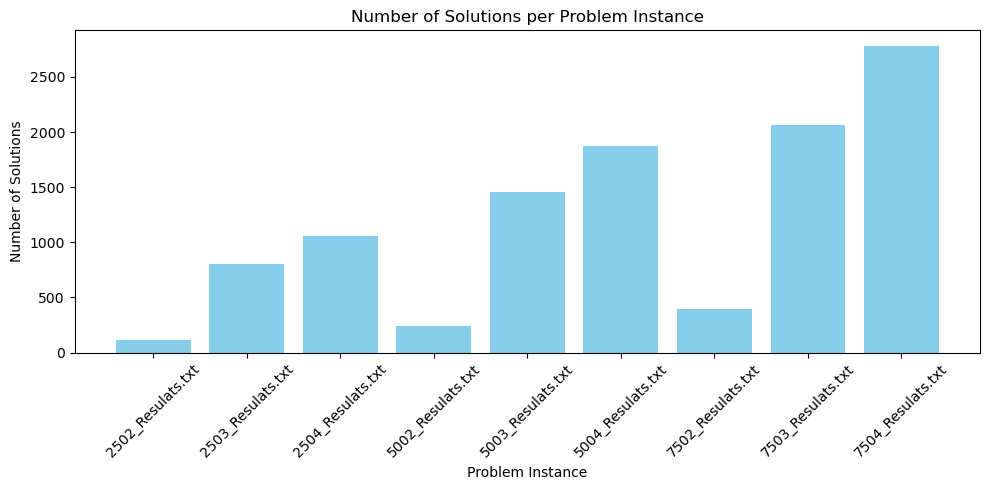

In [31]:
import matplotlib.pyplot as plt

problem_names = list(counts.keys())
solution_counts = list(counts.values())

plt.figure(figsize=(10, 5))
plt.bar(problem_names, solution_counts, color='skyblue')
plt.xlabel('Problem Instance')
plt.ylabel('Number of Solutions')
plt.title('Number of Solutions per Problem Instance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
import pandas as pd

df = pd.DataFrame({'Problem': problem_names, 'Solutions': solution_counts})
print(df)

             Problem  Solutions
0  2502_Resulats.txt        115
1  2503_Resulats.txt        803
2  2504_Resulats.txt       1053
3  5002_Resulats.txt        242
4  5003_Resulats.txt       1455
5  5004_Resulats.txt       1877
6  7502_Resulats.txt        397
7  7503_Resulats.txt       2063
8  7504_Resulats.txt       2783


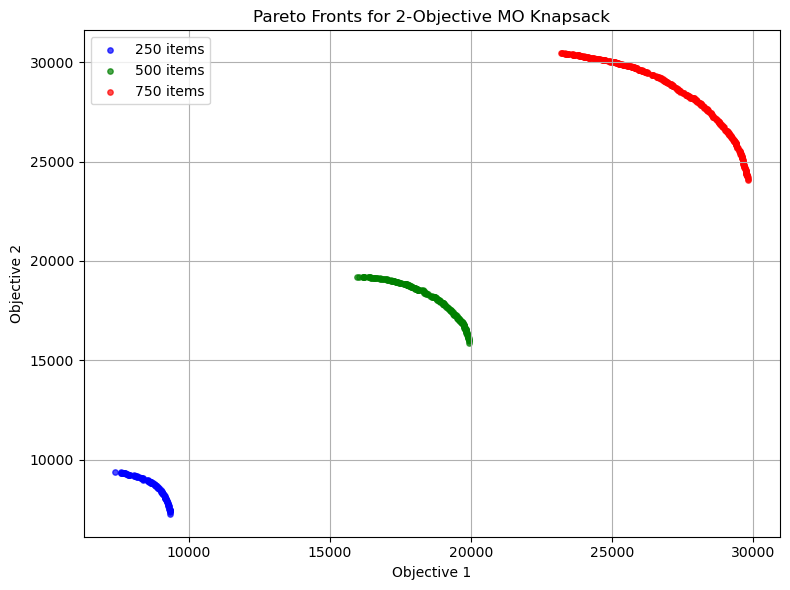

In [33]:
import matplotlib.pyplot as plt

def plot_pareto(filename, color, label):
    xs, ys = [], []
    with open(filename) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                xs.append(float(parts[0]))
                ys.append(float(parts[1]))
    plt.scatter(xs, ys, s=15, color=color, label=label, alpha=0.7)

plt.figure(figsize=(8, 6))
plot_pareto("2502_Resulats.txt", "blue", "250 items")
plot_pareto("5002_Resulats.txt", "green", "500 items")
plot_pareto("7502_Resulats.txt", "red", "750 items")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Pareto Fronts for 2-Objective MO Knapsack")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

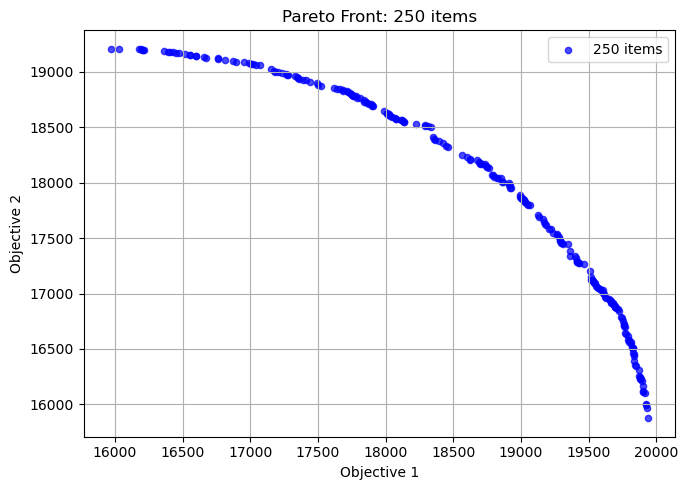

In [35]:
import matplotlib.pyplot as plt

def plot_single_pareto(filename, color='blue', label=None):
    xs, ys = [], []
    with open(filename) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                xs.append(float(parts[0]))
                ys.append(float(parts[1]))
    plt.figure(figsize=(7, 5))
    plt.scatter(xs, ys, s=20, color=color, label=label or filename, alpha=0.7)
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.title(f"Pareto Front: {label or filename}")
    plt.grid(True)
    if label is not None:
        plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_single_pareto("5002_Resulats.txt", color='blue', label="250 items")

In [1]:
###############################final version#####################################3

In [3]:
%%cython
# Cython code for MOACP runner: 10 runs, each run of 100 iterations, matching your C code logic

from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

# Globals that reset per run
cdef int NBITEMS = 250
cdef int ni = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 2
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i, f
    with open(filename.decode(), "r") as source:
        _nf, _ni = [int(x) for x in source.readline().split()]
        nf = _nf
        ni = _ni
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            for i in range(ni):
                source.readline()  # item index (ignore)
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence, ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        convergence = 0
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    while True:
                        mino = irand(ni)
                        if x.Items[mino] == 1:
                            break
                    x.Items[mino] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][mino]
                        x.f[r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(ni)
                            if x.Items[maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x.capa[r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x.Items[maxp] = 1
                                    x.nombr_nonpris -= 1
                                    x.nombr += 1
                                    for r in range(nf):
                                        x.capa[r] += weights[r][maxp]
                                        x.f[r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[mino] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][mino]
                            x.f[r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    free(remplace)

def run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file):
    """
    Run MOACP for a given instance, weights file, item count, objectives, and output file.
    Output is written to `output_file` (same format as C code).
    Performs 10 runs, each run of 100 iterations. Results are appended to output_file.
    """
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights

    alpha = 10
    paretoIni = 28000

    NBL = 100
    NRUNS = 10

    for run in range(1, NRUNS+1):
        # FIX: set these at the start of each run
        NBITEMS = nbitems
        ni = nbitems
        nf = num_objectives

        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")

        nombreLIGNE = 0
        nextLn = 0
        inv = 0

        seed(run)
        loadMOKP(instance_file)
        read_weights_file(weights_file)

        vector_weight = <double *>chk_malloc(nf * sizeof(double))
        P = create_pop(paretoIni, nf)

        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)
            Indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)

        # Write Pareto front after each run (append mode)
        with open(output_file, "a") as fpareto:
            fpareto.write("\n")  # match C code: separate runs
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")

        complete_free_pop(P)
        cleanup_globals()

In [9]:
run_moacp(b"250.2.txt", b"Weights_2obj_FQ200.txt", 250, 2, "2502_Resulats.txt")
run_moacp(b"500.2.txt", b"Weights_2obj_FQ200.txt", 500, 2, "5002_Resulats.txt")
run_moacp(b"750.2.txt", b"Weights_2obj_FQ200.txt", 750, 2, "7502_Resulats.txt")

RUN 1/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 2/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 3/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 4/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 5/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 6/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 7/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 8/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 9/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 10/10 -- 250.2.txt nbitems=250 nf=2 => 2502_Resulats.txt
RUN 1/10 -- 500.2.txt nbitems=500 nf=2 => 5002_Resulats.txt
RUN 2/10 -- 500.2.txt nbitems=500 nf=2 => 5002_Resulats.txt
RUN 3/10 -- 500.2.txt nbitems=500 nf=2 => 5002_Resulats.txt
RUN 4/10 -- 500.2.txt nbitems=500 nf=2 => 5002_Resulats.txt
RUN 5/10 -- 500.2.txt nbitems=500 nf=2 => 5002_Resulats.txt
RUN 6/10 -- 500.2.txt nbitems=500 nf=2 => 5002_Resulats.txt
RUN 7/10 -- 500.2.txt nbitems=500 nf=2 

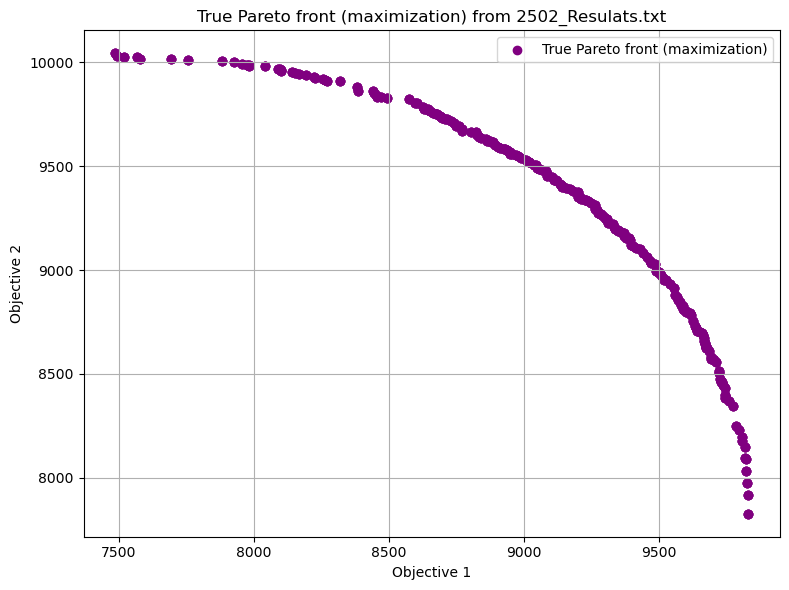

In [10]:
import matplotlib.pyplot as plt

def dominates(a, b):
    """Returns True if a dominates b (maximization for both objectives)."""
    return all(x >= y for x, y in zip(a, b)) and any(x > y for x, y in zip(a, b))

def get_true_pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i != j and dominates(q, p):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def plot_true_pareto_front(filename):
    # Read all points from the file
    points = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    # Get Pareto front
    pareto = get_true_pareto_front(points)
    xs, ys = zip(*pareto)
    plt.figure(figsize=(8,6))
    plt.scatter(xs, ys, color='purple', label="True Pareto front (maximization)")
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.title(f"True Pareto front (maximization) from {filename}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    plot_true_pareto_front("2502_Resulats.txt")

In [11]:
def dominates(a, b):
    # Maximization
    return all(x >= y for x, y in zip(a, b)) and any(x > y for x, y in zip(a, b))

def get_true_pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i != j and dominates(q, p):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def report_pareto_stats(filename):
    points = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    points.append([float(x) for x in line.split()])
                except Exception:
                    pass # skip malformed lines
    total_points = len(points)
    pareto_front = get_true_pareto_front(points)
    num_pareto = len(pareto_front)
    print(f"{filename}:")
    print(f"  Total points: {total_points}")
    print(f"  Pareto-optimal points: {num_pareto}")

if __name__ == "__main__":
    # Change these filenames to your actual result files
    files = [
        "2502_Resulats.txt",
        "5002_Resulats.txt",
        "7502_Resulats.txt"
    ]
    for filename in files:
        report_pareto_stats(filename)

2502_Resulats.txt:
  Total points: 5767
  Pareto-optimal points: 848
5002_Resulats.txt:
  Total points: 9206
  Pareto-optimal points: 1476
7502_Resulats.txt:
  Total points: 12105
  Pareto-optimal points: 524


In [71]:
run_moacp(b"250.3.txt", b"Weights_3obj_FQ100.txt", 250, 3, "2503_Resulats.txt")
run_moacp(b"500.3.txt", b"Weights_3obj_FQ100.txt", 500, 3, "5003_Resulats.txt")
run_moacp(b"750.3.txt", b"Weights_3obj_FQ100.txt", 750, 3, "7503_Resulats.txt")

RUN 1/10 -- 250.3.txt nbitems=250 nf=3 => 2503_Resulats.txt
RUN 2/10 -- 250.3.txt nbitems=0 nf=0 => 2503_Resulats.txt
RUN 3/10 -- 250.3.txt nbitems=0 nf=0 => 2503_Resulats.txt
RUN 4/10 -- 250.3.txt nbitems=0 nf=0 => 2503_Resulats.txt
RUN 5/10 -- 250.3.txt nbitems=0 nf=0 => 2503_Resulats.txt
RUN 6/10 -- 250.3.txt nbitems=0 nf=0 => 2503_Resulats.txt
RUN 7/10 -- 250.3.txt nbitems=0 nf=0 => 2503_Resulats.txt
RUN 8/10 -- 250.3.txt nbitems=0 nf=0 => 2503_Resulats.txt
RUN 9/10 -- 250.3.txt nbitems=0 nf=0 => 2503_Resulats.txt
RUN 10/10 -- 250.3.txt nbitems=0 nf=0 => 2503_Resulats.txt
RUN 1/10 -- 500.3.txt nbitems=500 nf=3 => 5003_Resulats.txt
RUN 2/10 -- 500.3.txt nbitems=0 nf=0 => 5003_Resulats.txt
RUN 3/10 -- 500.3.txt nbitems=0 nf=0 => 5003_Resulats.txt
RUN 4/10 -- 500.3.txt nbitems=0 nf=0 => 5003_Resulats.txt
RUN 5/10 -- 500.3.txt nbitems=0 nf=0 => 5003_Resulats.txt
RUN 6/10 -- 500.3.txt nbitems=0 nf=0 => 5003_Resulats.txt
RUN 7/10 -- 500.3.txt nbitems=0 nf=0 => 5003_Resulats.txt
RUN 8/10 

In [75]:
def dominates(a, b):
    # Maximization
    return all(x >= y for x, y in zip(a, b)) and any(x > y for x, y in zip(a, b))

def get_true_pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i != j and dominates(q, p):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def report_pareto_stats(filename):
    points = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    points.append([float(x) for x in line.split()])
                except Exception:
                    pass # skip malformed lines
    total_points = len(points)
    pareto_front = get_true_pareto_front(points)
    num_pareto = len(pareto_front)    

    print(f"{filename}:")
    print(f"  Total points: {total_points}")
    print(f"  Pareto-optimal points: {num_pareto}")    

if __name__ == "__main__":
    # Change these filenames to your actual result files
    files = [
        "2503_Resulats.txt",
        "5003_Resulats.txt",
        "7503_Resulats.txt"
    ]
    for filename in files:
        report_pareto_stats(filename)

2503_Resulats.txt:
  Total points: 8236
  Pareto-optimal points: 2827
5003_Resulats.txt:
  Total points: 14778
  Pareto-optimal points: 5357
7503_Resulats.txt:
  Total points: 20573
  Pareto-optimal points: 7540


In [73]:
run_moacp(b"250.4.txt", b"Weights_4obj_FQ40.txt", 250, 4, "2504_Resulats.txt")
run_moacp(b"500.4.txt", b"Weights_4obj_FQ40.txt", 500, 4, "5004_Resulats.txt")
run_moacp(b"750.4.txt", b"Weights_4obj_FQ40.txt", 750, 4, "7504_Resulats.txt")

RUN 1/10 -- 250.4.txt nbitems=250 nf=4 => 2504_Resulats.txt
RUN 2/10 -- 250.4.txt nbitems=0 nf=0 => 2504_Resulats.txt
RUN 3/10 -- 250.4.txt nbitems=0 nf=0 => 2504_Resulats.txt
RUN 4/10 -- 250.4.txt nbitems=0 nf=0 => 2504_Resulats.txt
RUN 5/10 -- 250.4.txt nbitems=0 nf=0 => 2504_Resulats.txt
RUN 6/10 -- 250.4.txt nbitems=0 nf=0 => 2504_Resulats.txt
RUN 7/10 -- 250.4.txt nbitems=0 nf=0 => 2504_Resulats.txt
RUN 8/10 -- 250.4.txt nbitems=0 nf=0 => 2504_Resulats.txt
RUN 9/10 -- 250.4.txt nbitems=0 nf=0 => 2504_Resulats.txt
RUN 10/10 -- 250.4.txt nbitems=0 nf=0 => 2504_Resulats.txt
RUN 1/10 -- 500.4.txt nbitems=500 nf=4 => 5004_Resulats.txt
RUN 2/10 -- 500.4.txt nbitems=0 nf=0 => 5004_Resulats.txt
RUN 3/10 -- 500.4.txt nbitems=0 nf=0 => 5004_Resulats.txt
RUN 4/10 -- 500.4.txt nbitems=0 nf=0 => 5004_Resulats.txt
RUN 5/10 -- 500.4.txt nbitems=0 nf=0 => 5004_Resulats.txt
RUN 6/10 -- 500.4.txt nbitems=0 nf=0 => 5004_Resulats.txt
RUN 7/10 -- 500.4.txt nbitems=0 nf=0 => 5004_Resulats.txt
RUN 8/10 

In [76]:
def dominates(a, b):
    # Maximization
    return all(x >= y for x, y in zip(a, b)) and any(x > y for x, y in zip(a, b))

def get_true_pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i != j and dominates(q, p):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def report_pareto_stats(filename):
    points = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                try:
                    points.append([float(x) for x in line.split()])
                except Exception:
                    pass # skip malformed lines
    total_points = len(points)
    pareto_front = get_true_pareto_front(points)
    num_pareto = len(pareto_front)    
    
    print(f"{filename}:")
    print(f"  Total points: {total_points}")
    print(f"  Pareto-optimal points: {num_pareto}")
  

if __name__ == "__main__":
    # Change these filenames to your actual result files
    files = [
        "2504_Resulats.txt",
        "5004_Resulats.txt",
        "7504_Resulats.txt"
    ]
    for filename in files:
        report_pareto_stats(filename)

2504_Resulats.txt:
  Total points: 10883
  Pareto-optimal points: 5594
5004_Resulats.txt:
  Total points: 20087
  Pareto-optimal points: 10239
7504_Resulats.txt:
  Total points: 28667
  Pareto-optimal points: 16003


✅ Enhanced Fronts 2D saved: pareto_fronts_2d_enhanced_comparison_ahmedbaya.png


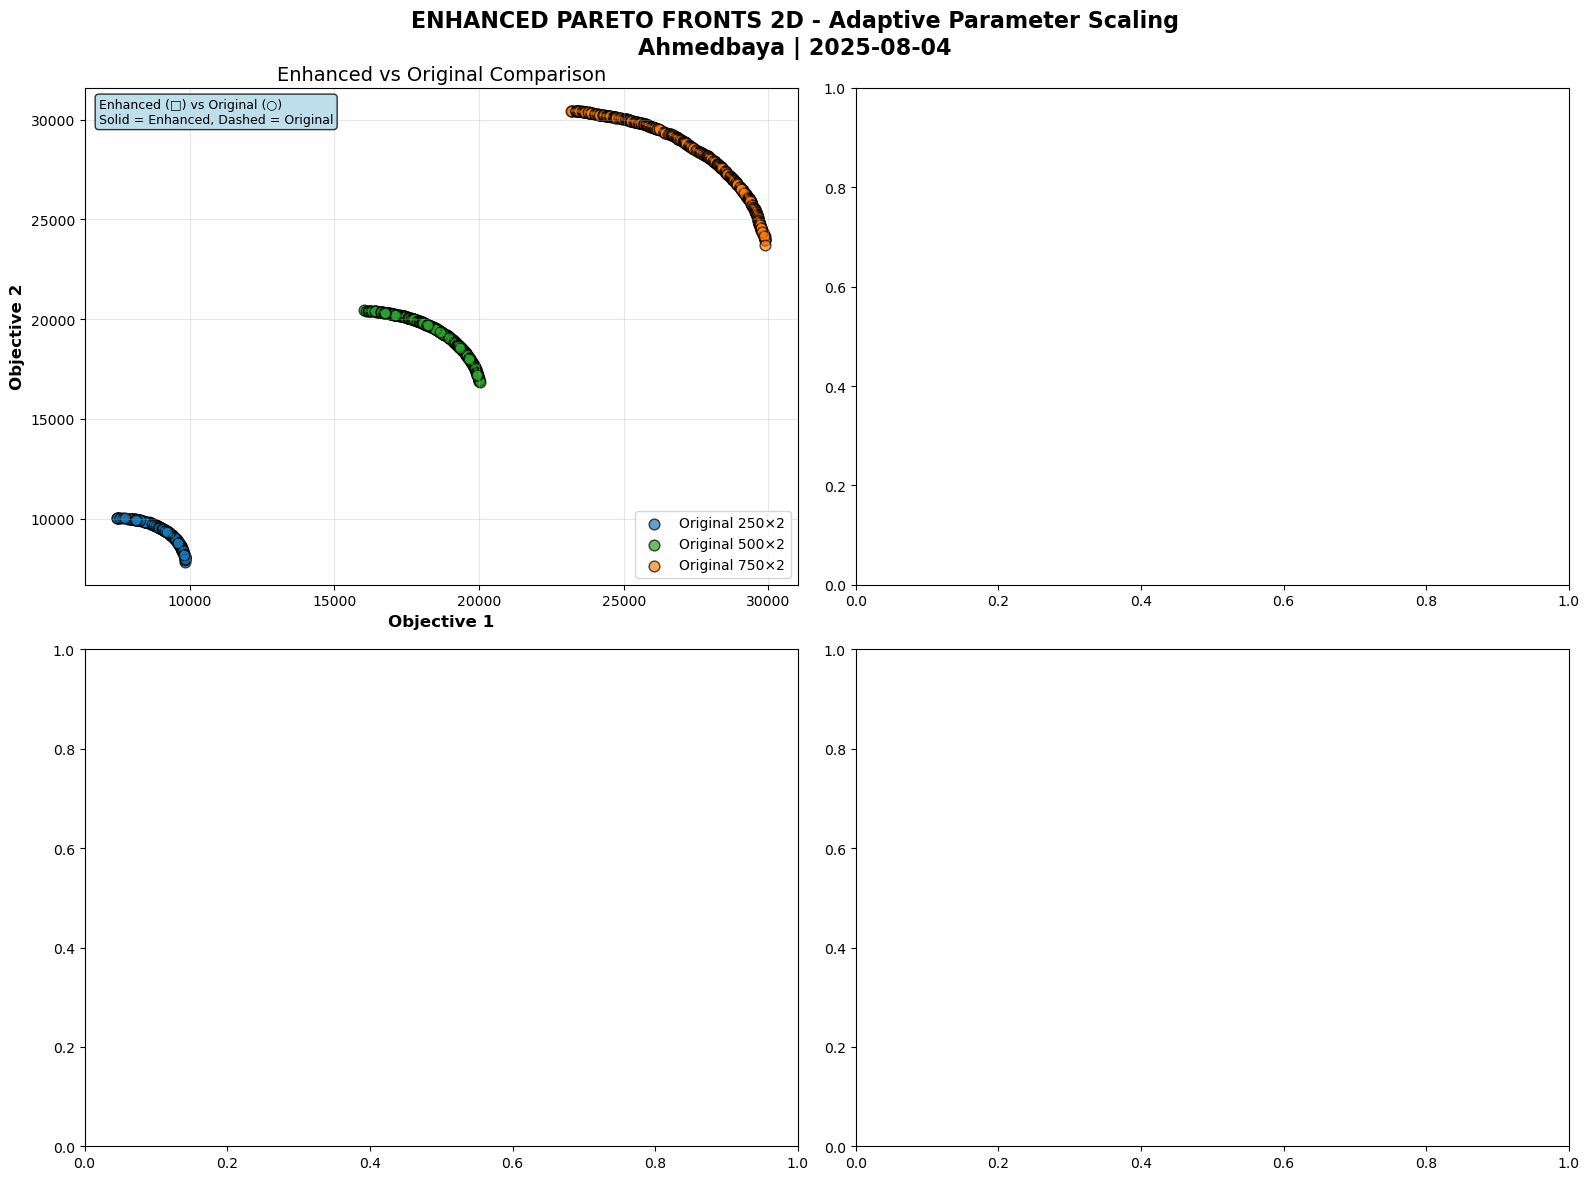

✅ Enhanced Fronts 3D saved: pareto_fronts_3d_enhanced_comparison_ahmedbaya.png


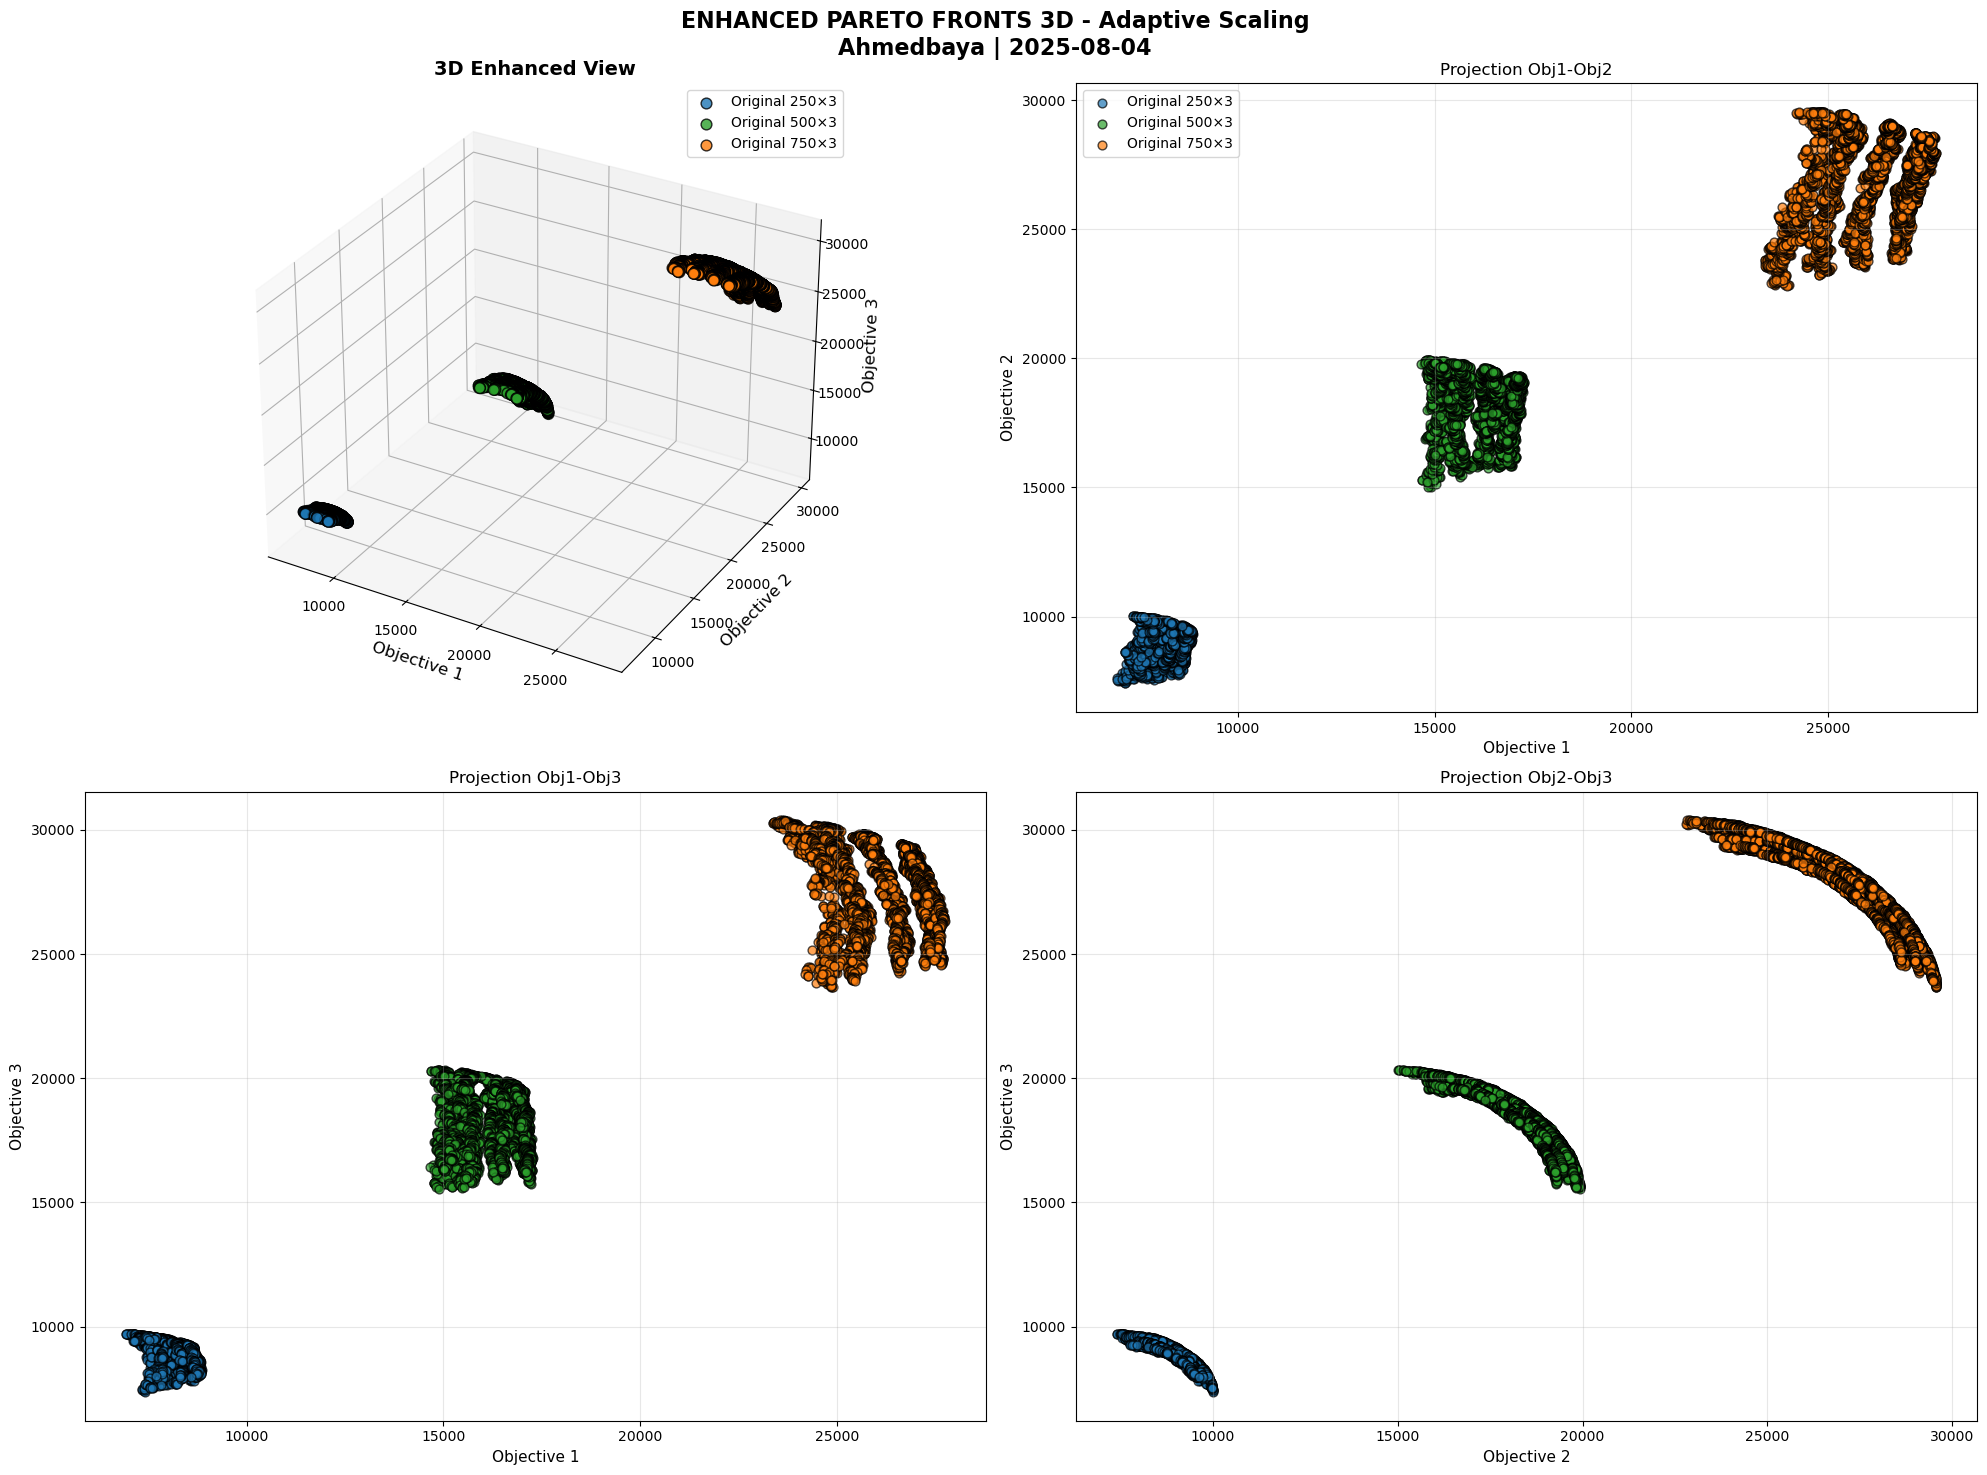

✅ Enhanced Fronts 4D hyperspace saved: pareto_fronts_4d_enhanced_hyperespace_ahmedbaya.png


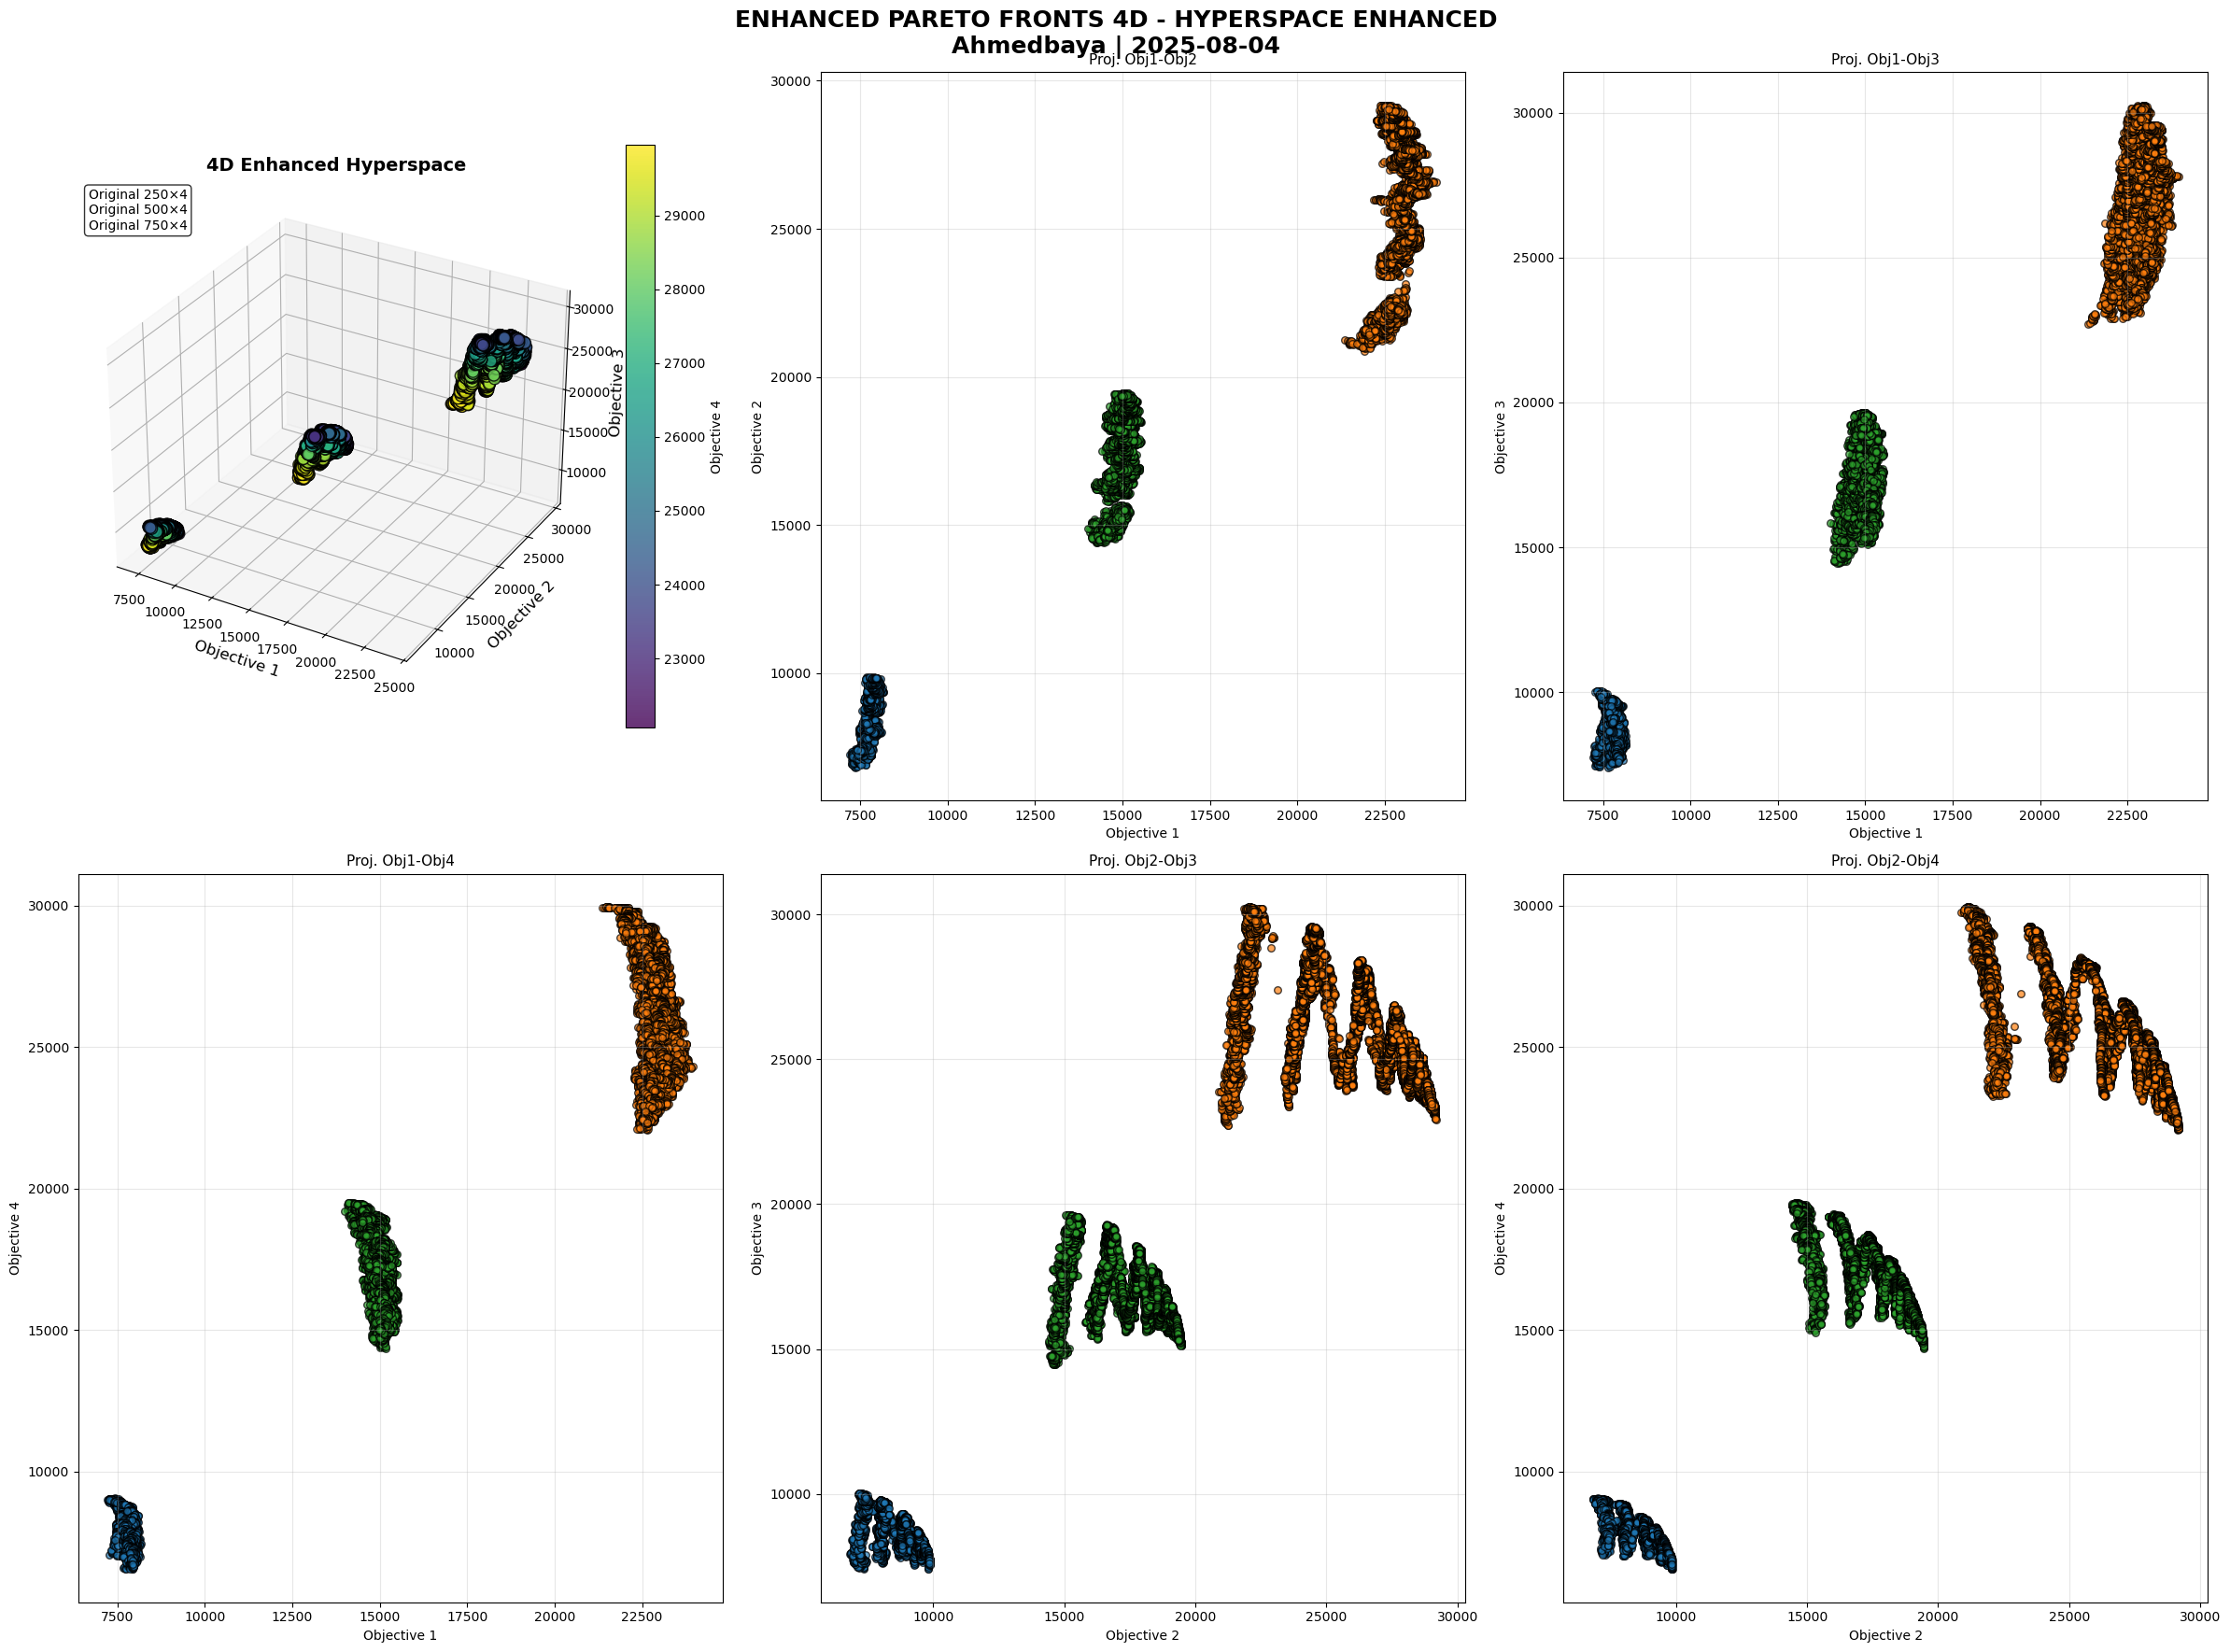

In [77]:
import matplotlib.pyplot as plt
import numpy as np

def read_pareto_file(filename, n_obj):
    """Reads a Pareto file and returns a list of dicts with objectives."""
    points = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                vals = [float(x) for x in line.split()]
                if len(vals) >= n_obj:
                    points.append({'objectives': vals[:n_obj]})
    return points

def get_true_pareto_front(points, maximization=True):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i == j: continue
            # Maximization
            if maximization:
                if all(x >= y for x, y in zip(q['objectives'], p['objectives'])) and any(x > y for x, y in zip(q['objectives'], p['objectives'])):
                    dominated = True
                    break
            else:
                if all(x <= y for x, y in zip(q['objectives'], p['objectives'])) and any(x < y for x, y in zip(q['objectives'], p['objectives'])):
                    dominated = True
                    break
        if not dominated:
            pareto.append(p)
    return pareto

def visualize_2d_comparison_enhanced(results_2d):
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ENHANCED PARETO FRONTS 2D - Adaptive Parameter Scaling\nAhmedbaya | 2025-08-04', 
                 fontsize=16, fontweight='bold')
    
    # Combined 2D plot
    ax1 = axes[0, 0]
    for name, solutions, color in results_2d:
        if solutions:
            objectives = np.array([sol['objectives'] for sol in solutions])
            marker = 's' if 'Enhanced' in name else 'o'
            size = 80 if 'Enhanced' in name else 60
            ax1.scatter(objectives[:, 0], objectives[:, 1], 
                        c=color, label=name, s=size, alpha=0.7, 
                        edgecolors='black', marker=marker)
            sorted_indices = np.argsort(objectives[:, 0])
            sorted_obj = objectives[sorted_indices]
            linestyle = '-' if 'Enhanced' in name else '--'
            ax1.plot(sorted_obj[:, 0], sorted_obj[:, 1], 
                     color=color, alpha=0.5, linewidth=2, linestyle=linestyle)
    
    ax1.set_xlabel('Objective 1', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Objective 2', fontsize=12, fontweight='bold')
    ax1.set_title('Enhanced vs Original Comparison', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.text(0.02, 0.98, 'Enhanced (□) vs Original (○)\nSolid = Enhanced, Dashed = Original', 
             transform=ax1.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.8))
    
    # Individual enhanced results
    enhanced_results = [item for item in results_2d if 'Enhanced' in item[0]]
    for idx, (name, solutions, color) in enumerate(enhanced_results[:3]):
        positions = [(0,1), (1,0), (1,1)]
        row, col = positions[idx]
        ax = axes[row, col]
        if solutions:
            objectives = np.array([sol['objectives'] for sol in solutions])
            ax.scatter(objectives[:, 0], objectives[:, 1], 
                      c=color, s=80, alpha=0.8, edgecolors='black', marker='s')
            sorted_indices = np.argsort(objectives[:, 0])
            sorted_obj = objectives[sorted_indices]
            ax.plot(sorted_obj[:, 0], sorted_obj[:, 1], 
                   color=color, alpha=0.6, linewidth=2)
            ax.set_xlabel('Objective 1', fontsize=11)
            ax.set_ylabel('Objective 2', fontsize=11)
            improvement_text = f'{name}\n{len(solutions)} solutions'
            ax.set_title(improvement_text, fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    filename_2d = 'pareto_fronts_2d_enhanced_comparison_ahmedbaya.png'
    plt.savefig(filename_2d, dpi=300, bbox_inches='tight')
    print(f"✅ Enhanced Fronts 2D saved: {filename_2d}")
    plt.show()

def visualize_3d_comparison_enhanced(results_3d):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np
    
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('ENHANCED PARETO FRONTS 3D - Adaptive Scaling\nAhmedbaya | 2025-08-04', 
                 fontsize=16, fontweight='bold')
    
    ax_main = fig.add_subplot(221, projection='3d')
    for name, solutions, color in results_3d:
        if solutions:
            objectives = np.array([sol['objectives'] for sol in solutions])
            marker = 's' if 'Enhanced' in name else 'o'
            size = 80 if 'Enhanced' in name else 60
            ax_main.scatter(objectives[:, 0], objectives[:, 1], objectives[:, 2],
                            c=color, label=name, s=size, alpha=0.8, 
                            edgecolors='black', marker=marker)
    ax_main.set_xlabel('Objective 1', fontsize=12)
    ax_main.set_ylabel('Objective 2', fontsize=12)
    ax_main.set_zlabel('Objective 3', fontsize=12)
    ax_main.set_title('3D Enhanced View', fontsize=14, fontweight='bold')
    ax_main.legend()
    
    projections = [(0, 1, 'Obj1-Obj2'), (0, 2, 'Obj1-Obj3'), (1, 2, 'Obj2-Obj3')]
    for proj_idx, (x_idx, y_idx, title) in enumerate(projections):
        ax = fig.add_subplot(2, 2, proj_idx + 2)
        for name, solutions, color in results_3d:
            if solutions:
                objectives = np.array([sol['objectives'] for sol in solutions])
                marker = 's' if 'Enhanced' in name else 'o'
                size = 50 if 'Enhanced' in name else 40
                ax.scatter(objectives[:, x_idx], objectives[:, y_idx],
                           c=color, label=name, s=size, alpha=0.7, 
                           edgecolors='black', marker=marker)
        ax.set_xlabel(f'Objective {x_idx + 1}', fontsize=11)
        ax.set_ylabel(f'Objective {y_idx + 1}', fontsize=11)
        ax.set_title(f'Projection {title}', fontsize=12)
        ax.grid(True, alpha=0.3)
        if proj_idx == 0:
            ax.legend()
    plt.tight_layout()
    filename_3d = 'pareto_fronts_3d_enhanced_comparison_ahmedbaya.png'
    plt.savefig(filename_3d, dpi=300, bbox_inches='tight')
    print(f"✅ Enhanced Fronts 3D saved: {filename_3d}")
    plt.show()

def visualize_4d_comparison_enhanced(results_4d):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import numpy as np
    
    fig = plt.figure(figsize=(24, 18))
    fig.suptitle('ENHANCED PARETO FRONTS 4D - HYPERSPACE ENHANCED\nAhmedbaya | 2025-08-04', 
                 fontsize=18, fontweight='bold')
    
    ax_main = fig.add_subplot(231, projection='3d')
    legend_entries = []
    for name, solutions, color in results_4d:
        if solutions:
            objectives = np.array([sol['objectives'] for sol in solutions])
            marker = 's' if 'Enhanced' in name else 'o'
            size = 100 if 'Enhanced' in name else 80
            scatter = ax_main.scatter(objectives[:, 0], objectives[:, 1], objectives[:, 2],
                                     c=objectives[:, 3], s=size, alpha=0.8, 
                                     cmap='viridis', edgecolors='black', marker=marker)
            legend_entries.append(name)
    if legend_entries:
        plt.colorbar(scatter, ax=ax_main, label='Objective 4', shrink=0.8)
    ax_main.set_xlabel('Objective 1', fontsize=12)
    ax_main.set_ylabel('Objective 2', fontsize=12)
    ax_main.set_zlabel('Objective 3', fontsize=12)
    ax_main.set_title('4D Enhanced Hyperspace', fontsize=14, fontweight='bold')
    legend_text = '\n'.join(legend_entries)
    ax_main.text2D(0.02, 0.98, legend_text, transform=ax_main.transAxes, 
                   fontsize=10, verticalalignment='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    projections = [
        (0, 1, 'Obj1-Obj2'), (0, 2, 'Obj1-Obj3'), (0, 3, 'Obj1-Obj4'),
        (1, 2, 'Obj2-Obj3'), (1, 3, 'Obj2-Obj4')
    ]
    for proj_idx, (x_idx, y_idx, title) in enumerate(projections):
        ax = fig.add_subplot(2, 3, proj_idx + 2)
        for name, solutions, color in results_4d:
            if solutions:
                objectives = np.array([sol['objectives'] for sol in solutions])
                marker = 's' if 'Enhanced' in name else 'o'
                size = 40 if 'Enhanced' in name else 30
                ax.scatter(objectives[:, x_idx], objectives[:, y_idx],
                           c=color, label=name, s=size, alpha=0.7, 
                           edgecolors='black', marker=marker)
        ax.set_xlabel(f'Objective {x_idx + 1}', fontsize=10)
        ax.set_ylabel(f'Objective {y_idx + 1}', fontsize=10)
        ax.set_title(f'Proj. {title}', fontsize=11)
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    filename_4d = 'pareto_fronts_4d_enhanced_hyperespace_ahmedbaya.png'
    plt.savefig(filename_4d, dpi=300, bbox_inches='tight')
    print(f"✅ Enhanced Fronts 4D hyperspace saved: {filename_4d}")
    plt.show()

if __name__ == "__main__":
    # --- Prepare your file/color/name mapping ---
    file_map = [
        ("2502_Resulats.txt", 2, "Original 250×2", "#1f77b4"),
        ("5002_Resulats.txt", 2, "Original 500×2", "#2ca02c"),
        ("7502_Resulats.txt", 2, "Original 750×2", "#ff7f0e"),
        ("2503_Resulats.txt", 3, "Original 250×3", "#1f77b4"),
        ("5003_Resulats.txt", 3, "Original 500×3", "#2ca02c"),
        ("7503_Resulats.txt", 3, "Original 750×3", "#ff7f0e"),
        ("2504_Resulats.txt", 4, "Original 250×4", "#1f77b4"),
        ("5004_Resulats.txt", 4, "Original 500×4", "#2ca02c"),
        ("7504_Resulats.txt", 4, "Original 750×4", "#ff7f0e"),
    ]

    # Optionally add enhanced fronts here, e.g., ("2502_Enhanced.txt", 2, "Enhanced 250×2", "#d62728")
    # For demonstration: treat all as original (customize names/colors as needed)

    # 2D
    results_2d = []
    for fname, n_obj, name, color in file_map:
        if n_obj == 2:
            sols = read_pareto_file(fname, n_obj)
            pareto_sols = get_true_pareto_front(sols, maximization=True)
            results_2d.append((name, pareto_sols, color))
    visualize_2d_comparison_enhanced(results_2d)

    # 3D
    results_3d = []
    for fname, n_obj, name, color in file_map:
        if n_obj == 3:
            sols = read_pareto_file(fname, n_obj)
            pareto_sols = get_true_pareto_front(sols, maximization=True)
            results_3d.append((name, pareto_sols, color))
    visualize_3d_comparison_enhanced(results_3d)

    # 4D
    results_4d = []
    for fname, n_obj, name, color in file_map:
        if n_obj == 4:
            sols = read_pareto_file(fname, n_obj)
            pareto_sols = get_true_pareto_front(sols, maximization=True)
            results_4d.append((name, pareto_sols, color))
    visualize_4d_comparison_enhanced(results_4d)

✅ Pareto Fronts 2D saved: pareto_fronts_2d_comparison_ahmedbaya.png


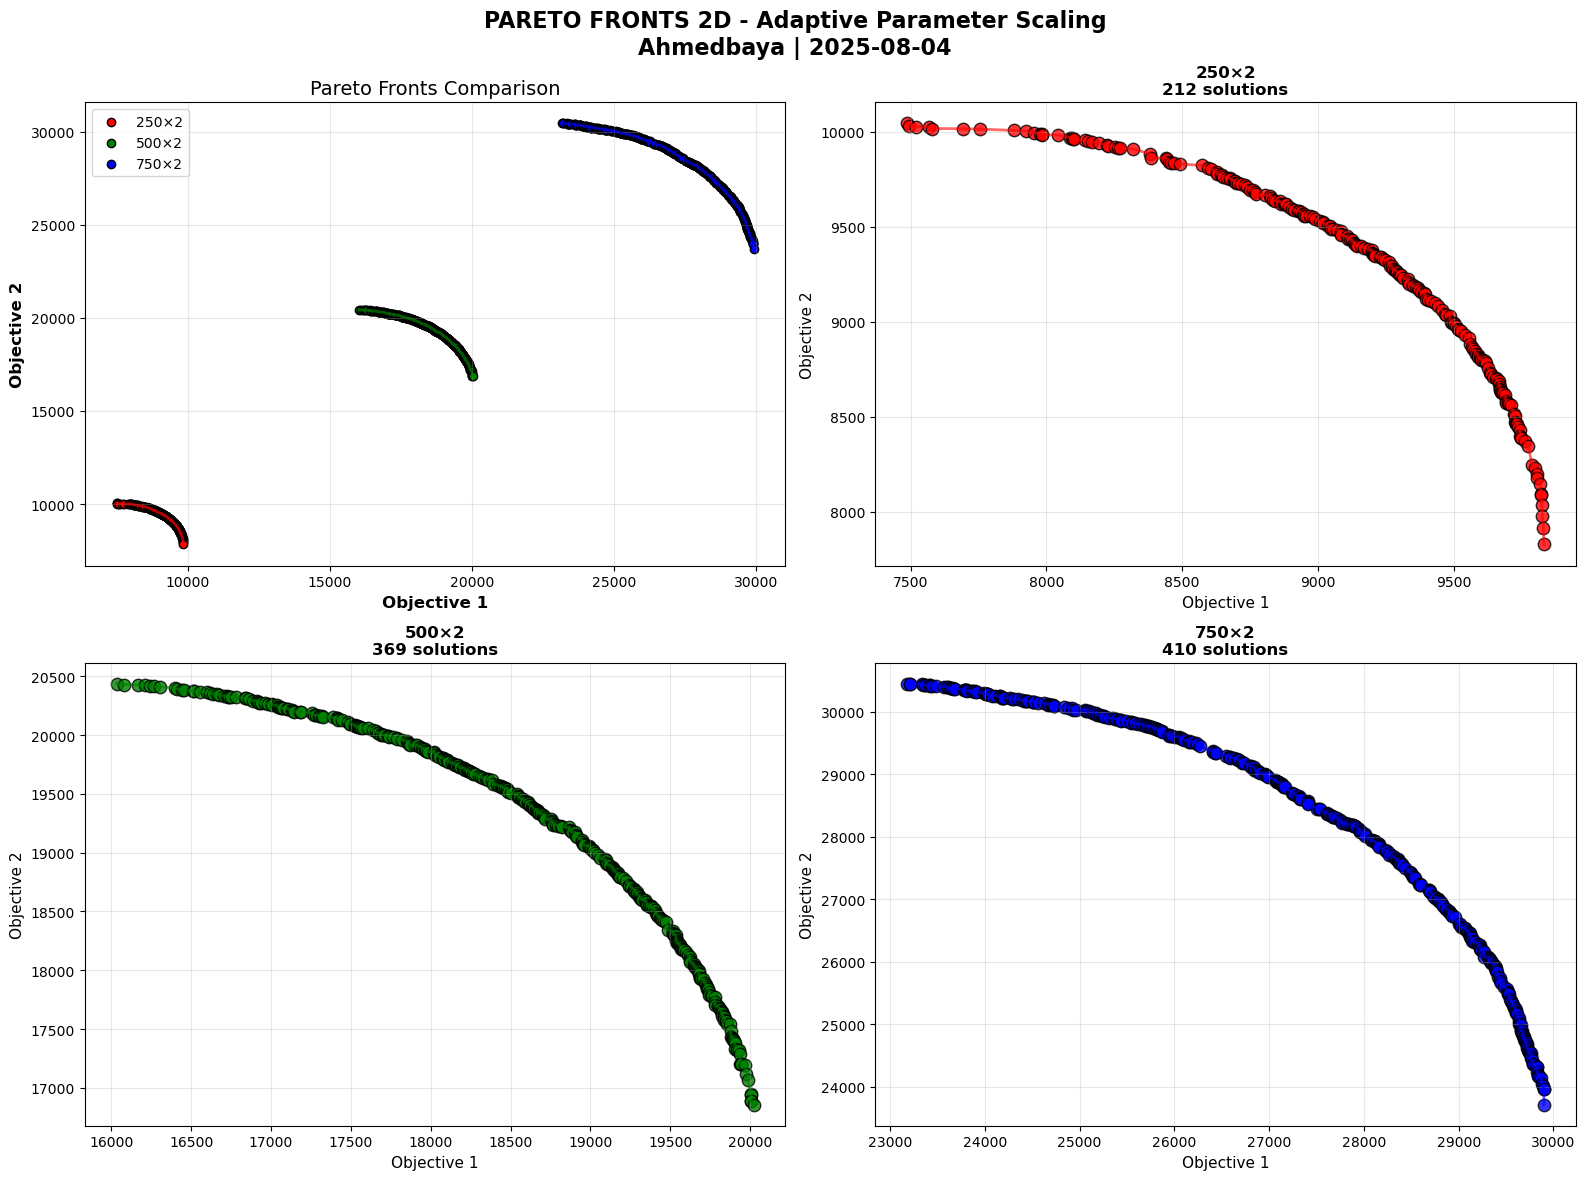

✅ Pareto Fronts 3D saved: pareto_fronts_3d_comparison_ahmedbaya.png


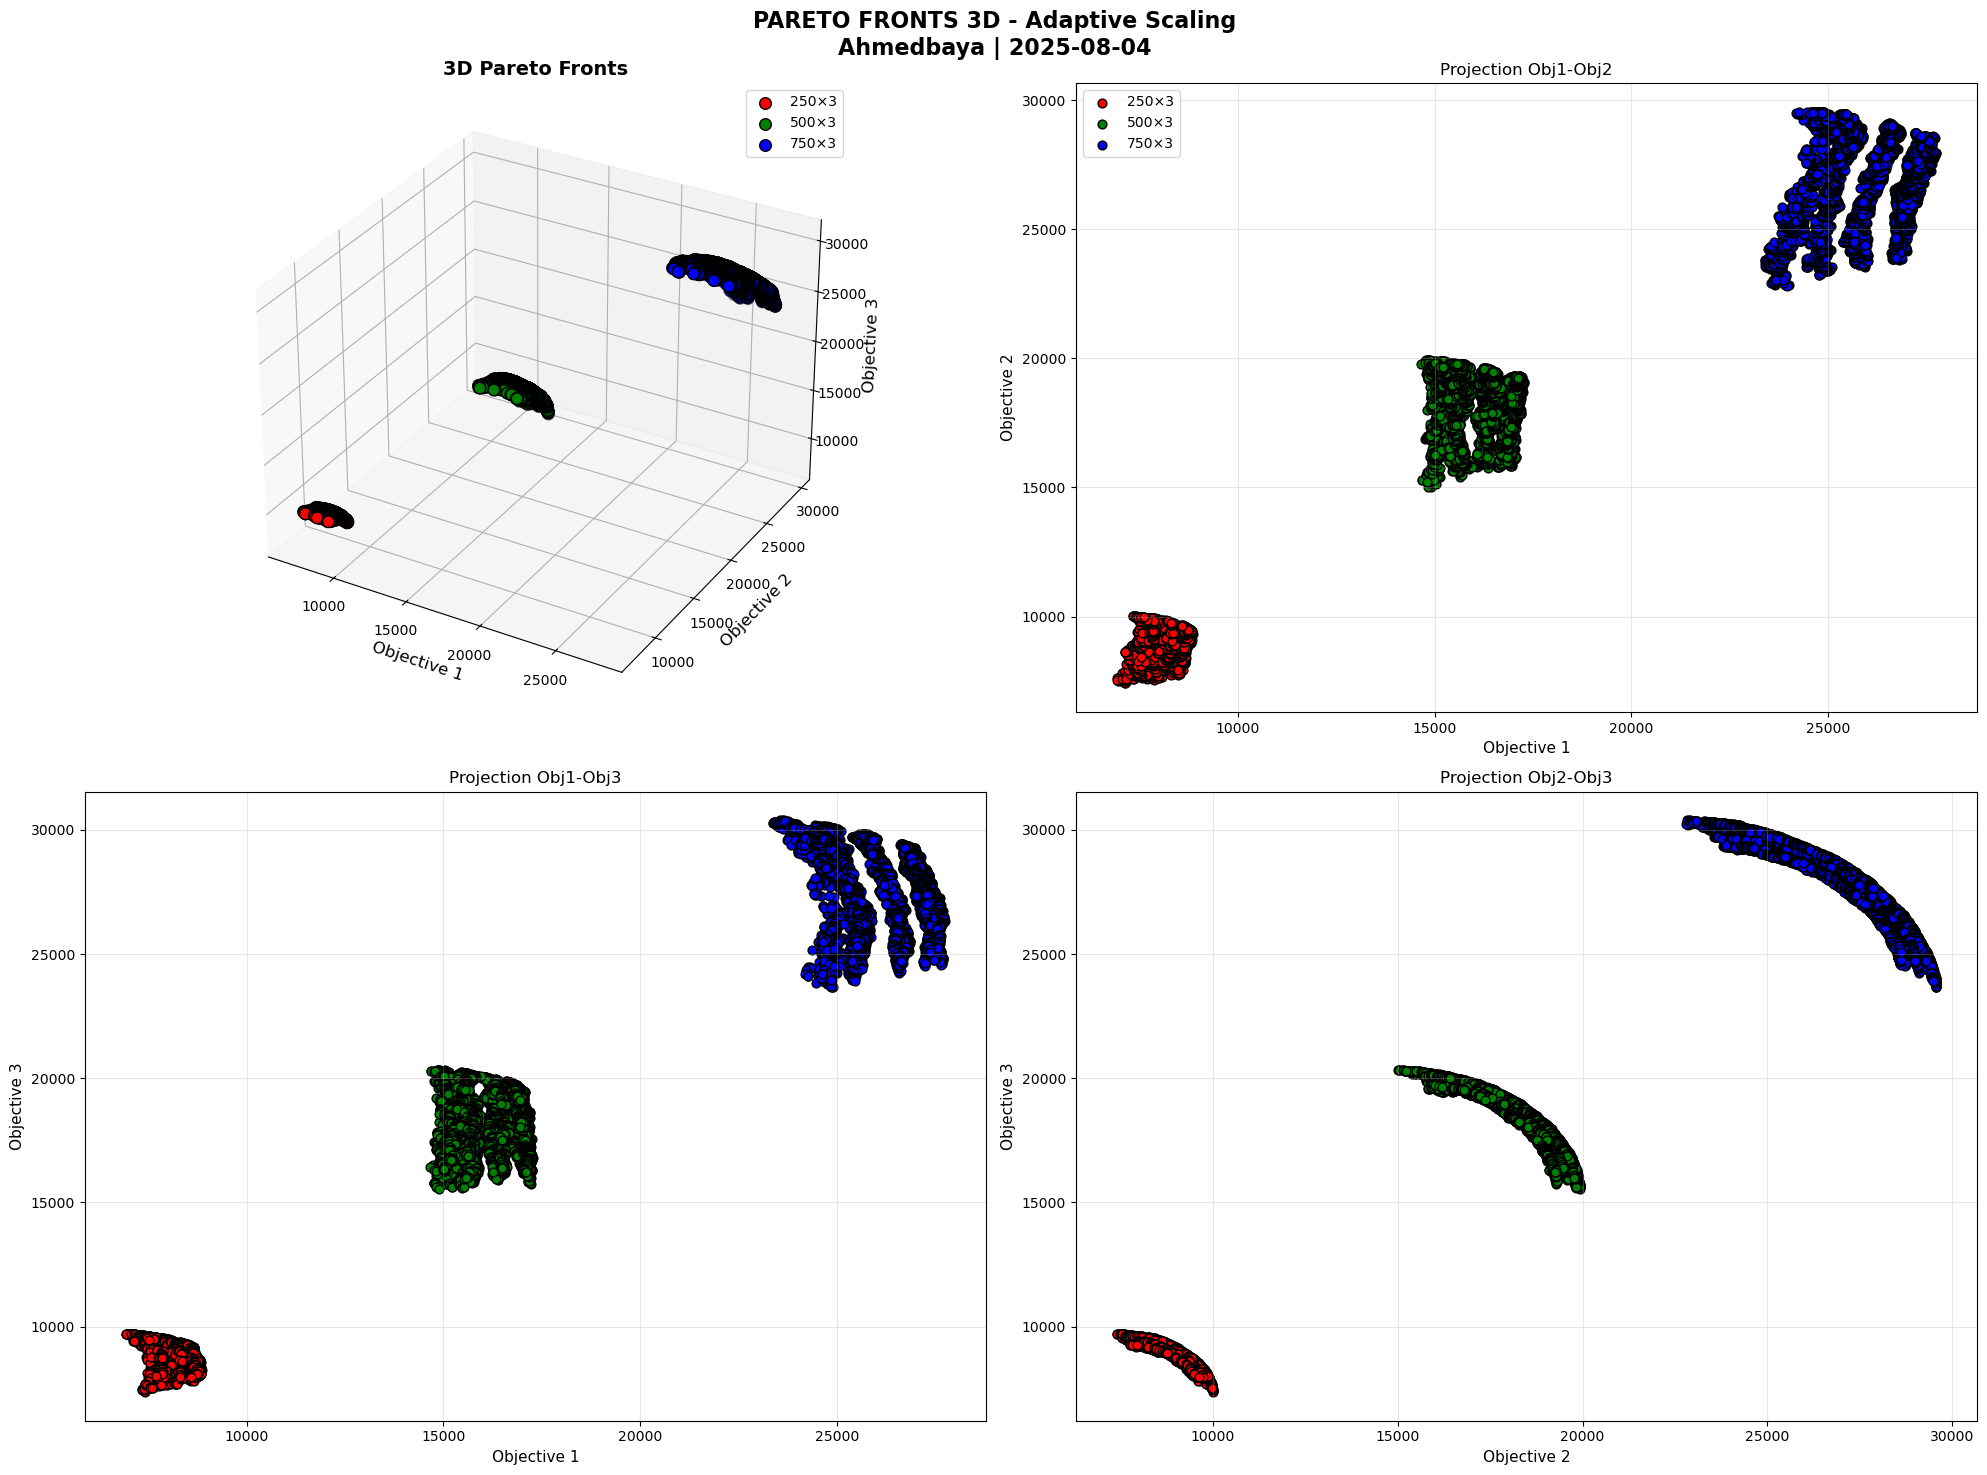

✅ Pareto Fronts 4D hyperspace saved: pareto_fronts_4d_hyperespace_ahmedbaya.png


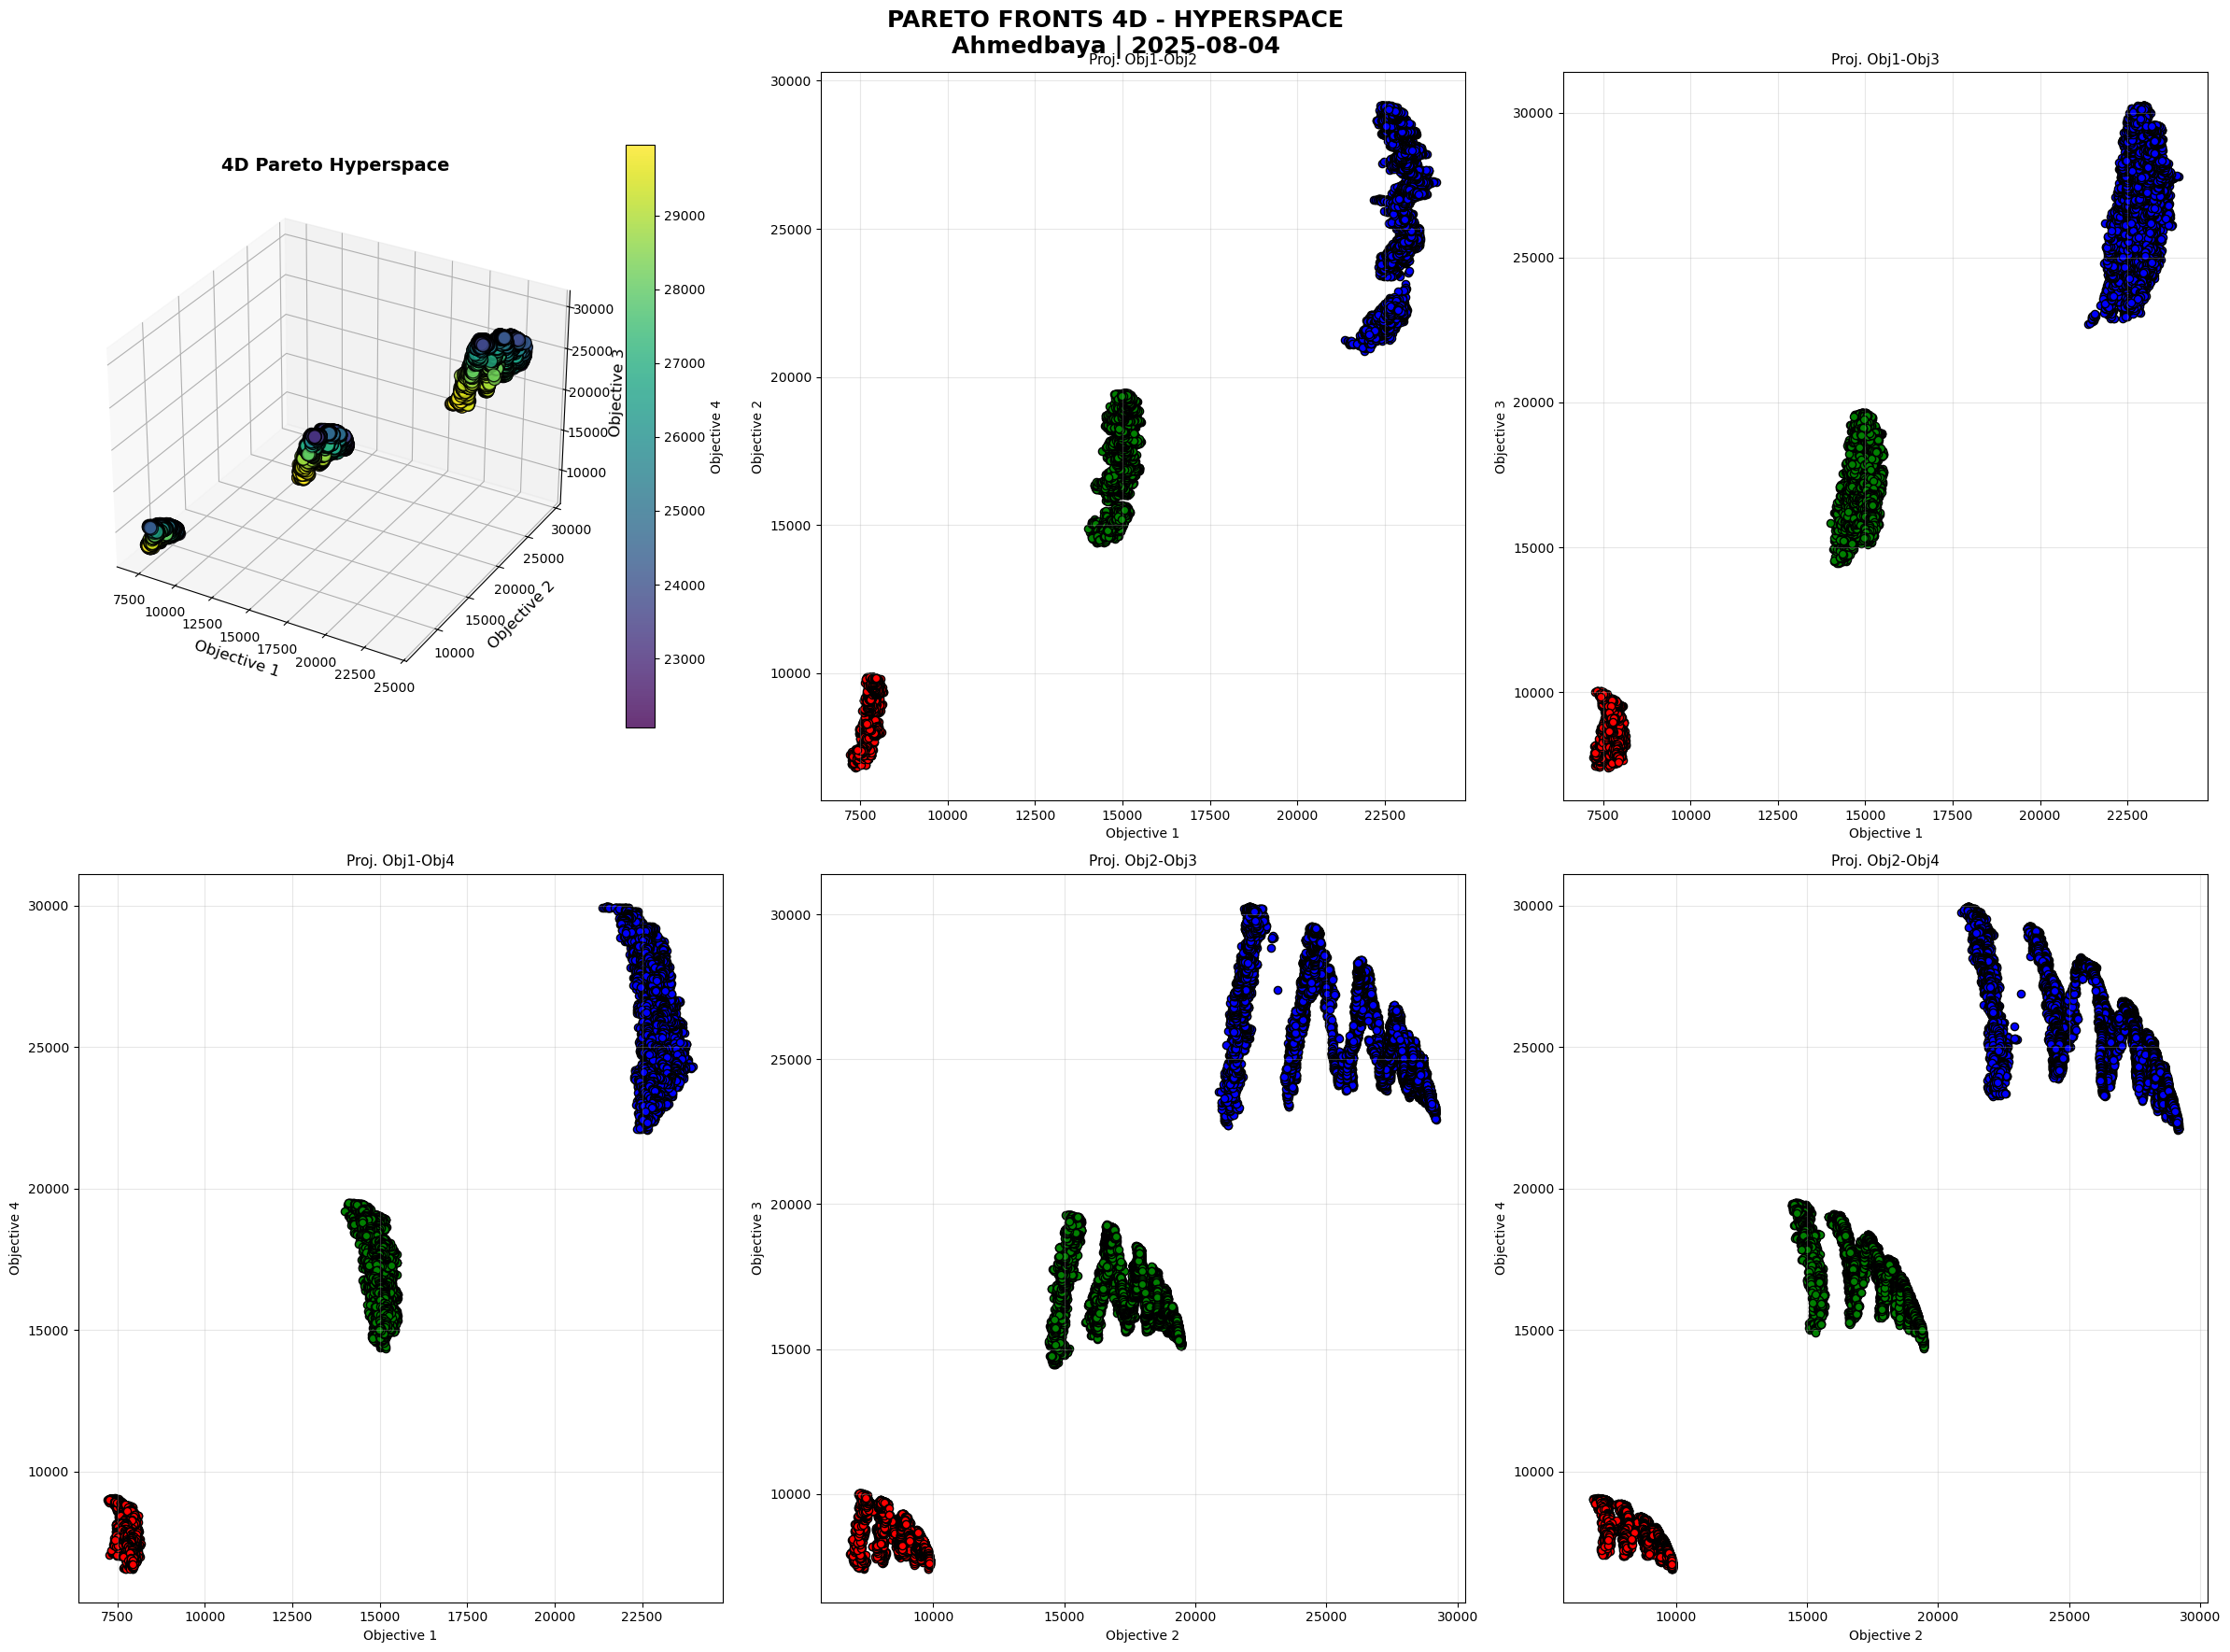

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import os

def read_pareto_file(filename, n_obj):
    points = []
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return points
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                vals = [float(x) for x in line.split()]
                if len(vals) >= n_obj:
                    points.append({'objectives': vals[:n_obj]})
    return points

def get_true_pareto_front(points):
    # Maximization
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i == j:
                continue
            if all(x >= y for x, y in zip(q['objectives'], p['objectives'])) and any(x > y for x, y in zip(q['objectives'], p['objectives'])):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def visualize_2d_original(instance_labels, result_files, output_file):
    colors = ['red', 'green', 'blue']
    n_obj = 2
    pareto_fronts = []
    for fname in result_files:
        sols = read_pareto_file(fname, n_obj)
        pareto_sols = get_true_pareto_front(sols)
        pareto_fronts.append(pareto_sols)

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('PARETO FRONTS 2D - Adaptive Parameter Scaling\nAhmedbaya | 2025-08-04',
                 fontsize=16, fontweight='bold')

    # Top-left: Combined fronts
    ax0 = axes[0,0]
    for idx, (label, front) in enumerate(zip(instance_labels, pareto_fronts)):
        obj = np.array([sol['objectives'] for sol in front])
        # Sort by Obj1 for line
        sorted_indices = np.argsort(obj[:,0])
        sorted_obj = obj[sorted_indices]
        ax0.scatter(sorted_obj[:,0], sorted_obj[:,1], c=colors[idx], label=label, marker='o', edgecolors='black')
        ax0.plot(sorted_obj[:,0], sorted_obj[:,1], color=colors[idx], alpha=0.7, linewidth=2)
    ax0.set_xlabel('Objective 1', fontsize=12, fontweight='bold')
    ax0.set_ylabel('Objective 2', fontsize=12, fontweight='bold')
    ax0.set_title('Pareto Fronts Comparison', fontsize=14)
    ax0.legend()
    ax0.grid(True, alpha=0.3)

    # Individual fronts
    positions = [(0,1), (1,0), (1,1)]
    for idx, (label, front) in enumerate(zip(instance_labels, pareto_fronts)):
        ax = axes[positions[idx][0], positions[idx][1]]
        obj = np.array([sol['objectives'] for sol in front])
        sorted_indices = np.argsort(obj[:,0])
        sorted_obj = obj[sorted_indices]
        ax.scatter(sorted_obj[:,0], sorted_obj[:,1], c=colors[idx], s=80, alpha=0.8, edgecolors='black', marker='o')
        ax.plot(sorted_obj[:,0], sorted_obj[:,1], color=colors[idx], alpha=0.6, linewidth=2)
        ax.set_xlabel('Objective 1', fontsize=11)
        ax.set_ylabel('Objective 2', fontsize=11)
        ax.set_title(f"{label}\n{len(front)} solutions", fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Pareto Fronts 2D saved: {output_file}")
    plt.show()

def visualize_3d_original(instance_labels, result_files, output_file):
    from mpl_toolkits.mplot3d import Axes3D
    colors = ['red', 'green', 'blue']
    n_obj = 3
    pareto_fronts = []
    for fname in result_files:
        sols = read_pareto_file(fname, n_obj)
        pareto_sols = get_true_pareto_front(sols)
        pareto_fronts.append(pareto_sols)

    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('PARETO FRONTS 3D - Adaptive Scaling\nAhmedbaya | 2025-08-04', 
                 fontsize=16, fontweight='bold')
    ax_main = fig.add_subplot(221, projection='3d')
    for idx, (label, front) in enumerate(zip(instance_labels, pareto_fronts)):
        obj = np.array([sol['objectives'] for sol in front])
        ax_main.scatter(obj[:,0], obj[:,1], obj[:,2], c=colors[idx], label=label, marker='o', edgecolors='black', s=70)
        ax_main.plot(obj[:,0], obj[:,1], obj[:,2], color=colors[idx], alpha=0.7)
    ax_main.set_xlabel('Objective 1', fontsize=12)
    ax_main.set_ylabel('Objective 2', fontsize=12)
    ax_main.set_zlabel('Objective 3', fontsize=12)
    ax_main.set_title('3D Pareto Fronts', fontsize=14, fontweight='bold')
    ax_main.legend()

    # Individual projections
    projections = [(0,1,'Obj1-Obj2'), (0,2,'Obj1-Obj3'), (1,2,'Obj2-Obj3')]
    for proj_idx, (x_idx, y_idx, title) in enumerate(projections):
        ax = fig.add_subplot(2,2,proj_idx+2)
        for idx, (label, front) in enumerate(zip(instance_labels, pareto_fronts)):
            obj = np.array([sol['objectives'] for sol in front])
            ax.scatter(obj[:,x_idx], obj[:,y_idx], c=colors[idx], label=label, marker='o', edgecolors='black', s=40)
        ax.set_xlabel(f'Objective {x_idx+1}', fontsize=11)
        ax.set_ylabel(f'Objective {y_idx+1}', fontsize=11)
        ax.set_title(f'Projection {title}', fontsize=12)
        ax.grid(True, alpha=0.3)
        if proj_idx == 0:
            ax.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Pareto Fronts 3D saved: {output_file}")
    plt.show()

def visualize_4d_original(instance_labels, result_files, output_file):
    from mpl_toolkits.mplot3d import Axes3D
    colors = ['red', 'green', 'blue']
    n_obj = 4
    pareto_fronts = []
    for fname in result_files:
        sols = read_pareto_file(fname, n_obj)
        pareto_sols = get_true_pareto_front(sols)
        pareto_fronts.append(pareto_sols)

    fig = plt.figure(figsize=(24, 18))
    fig.suptitle('PARETO FRONTS 4D - HYPERSPACE\nAhmedbaya | 2025-08-04', 
                 fontsize=18, fontweight='bold')
    ax_main = fig.add_subplot(231, projection='3d')
    for idx, (label, front) in enumerate(zip(instance_labels, pareto_fronts)):
        obj = np.array([sol['objectives'] for sol in front])
        scatter = ax_main.scatter(obj[:,0], obj[:,1], obj[:,2], c=obj[:,3], cmap='viridis', s=100, alpha=0.8, marker='o', edgecolors='black')
    plt.colorbar(scatter, ax=ax_main, label='Objective 4', shrink=0.8)
    ax_main.set_xlabel('Objective 1', fontsize=12)
    ax_main.set_ylabel('Objective 2', fontsize=12)
    ax_main.set_zlabel('Objective 3', fontsize=12)
    ax_main.set_title('4D Pareto Hyperspace', fontsize=14, fontweight='bold')

    projections = [
        (0,1,'Obj1-Obj2'), (0,2,'Obj1-Obj3'), (0,3,'Obj1-Obj4'),
        (1,2,'Obj2-Obj3'), (1,3,'Obj2-Obj4')
    ]
    for proj_idx, (x_idx, y_idx, title) in enumerate(projections):
        ax = fig.add_subplot(2,3,proj_idx+2)
        for idx, (label, front) in enumerate(zip(instance_labels, pareto_fronts)):
            obj = np.array([sol['objectives'] for sol in front])
            ax.scatter(obj[:,x_idx], obj[:,y_idx], c=colors[idx], label=label, marker='o', edgecolors='black', s=35)
        ax.set_xlabel(f'Objective {x_idx+1}', fontsize=10)
        ax.set_ylabel(f'Objective {y_idx+1}', fontsize=10)
        ax.set_title(f'Proj. {title}', fontsize=11)
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Pareto Fronts 4D hyperspace saved: {output_file}")
    plt.show()

if __name__ == "__main__":
    # 2D
    labels_2d = ['250×2', '500×2', '750×2']
    files_2d = ['2502_Resulats.txt', '5002_Resulats.txt', '7502_Resulats.txt']
    visualize_2d_original(labels_2d, files_2d, 'pareto_fronts_2d_comparison_ahmedbaya.png')

    # 3D
    labels_3d = ['250×3', '500×3', '750×3']
    files_3d = ['2503_Resulats.txt', '5003_Resulats.txt', '7503_Resulats.txt']
    visualize_3d_original(labels_3d, files_3d, 'pareto_fronts_3d_comparison_ahmedbaya.png')

    # 4D
    labels_4d = ['250×4', '500×4', '750×4']
    files_4d = ['2504_Resulats.txt', '5004_Resulats.txt', '7504_Resulats.txt']
    visualize_4d_original(labels_4d, files_4d, 'pareto_fronts_4d_hyperespace_ahmedbaya.png')

✅ Comparison plot saved: compare_2502_c_cython.png


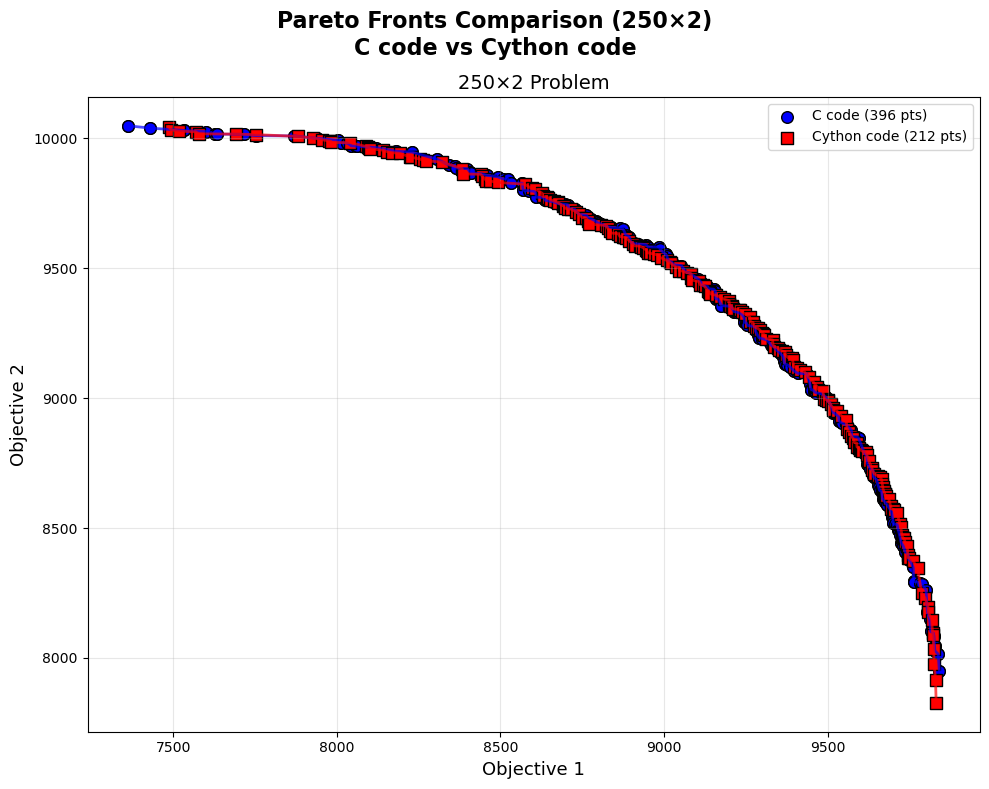

✅ Comparison plot saved: compare_5002_c_cython.png


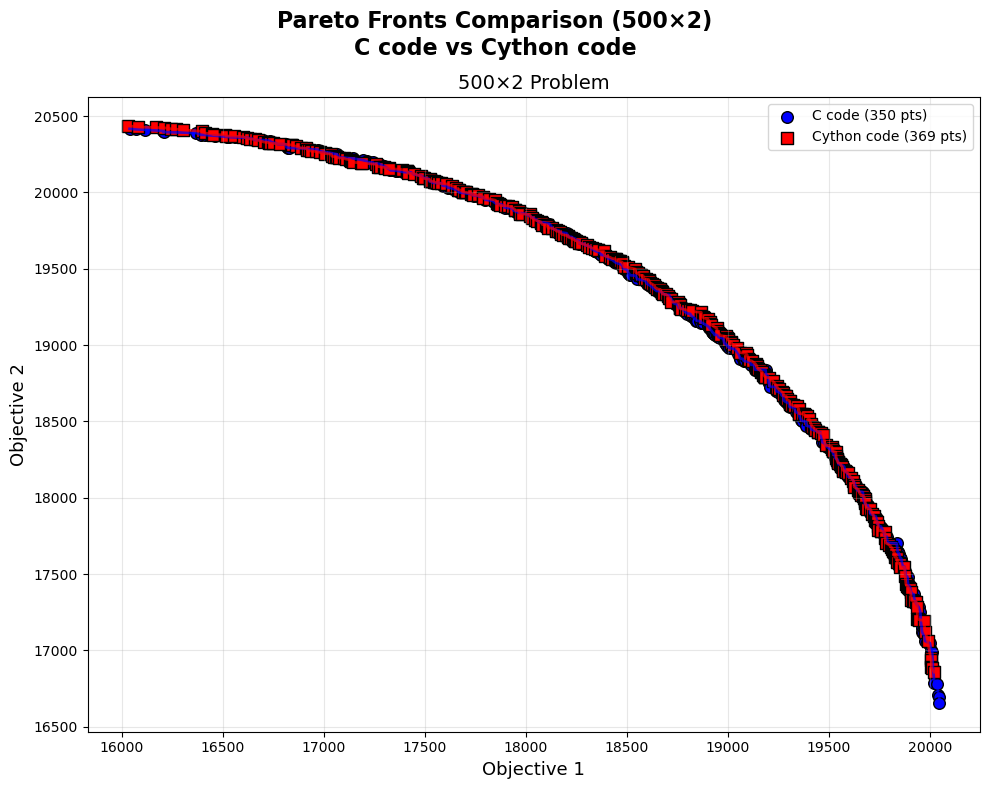

✅ Comparison plot saved: compare_7502_c_cython.png


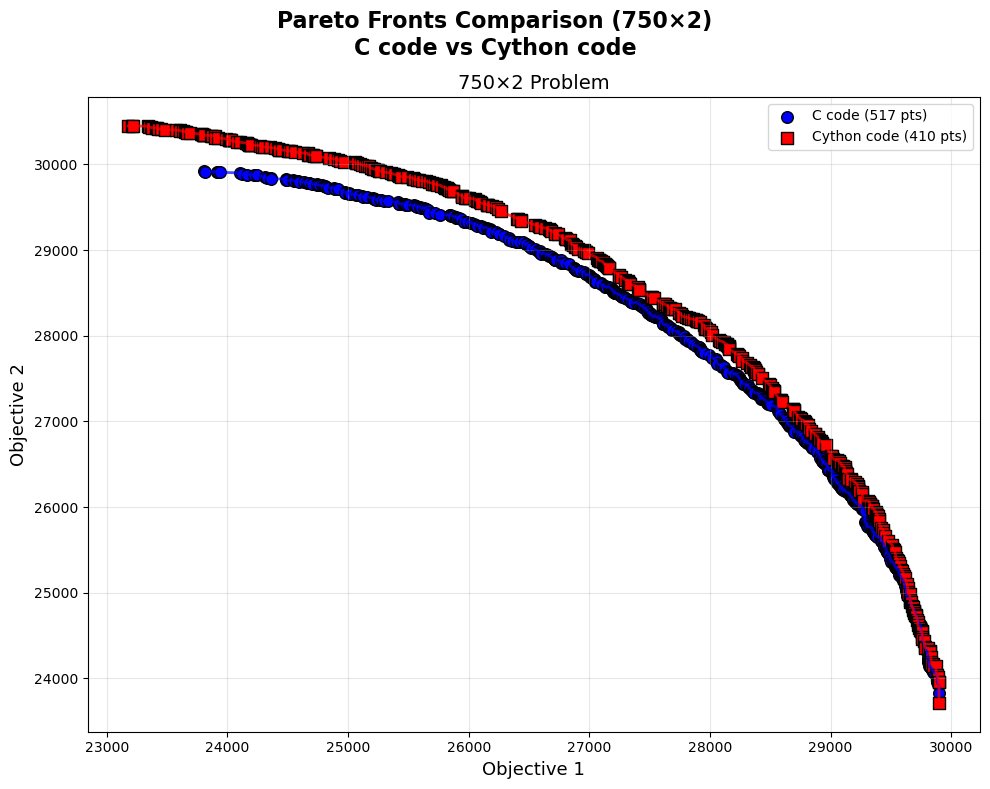

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import os

def read_pareto_file(filename, n_obj):
    points = []
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return points
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                vals = [float(x) for x in line.split()]
                if len(vals) >= n_obj:
                    points.append({'objectives': vals[:n_obj]})
    return points

def get_true_pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i == j:
                continue
            if all(x >= y for x, y in zip(q['objectives'], p['objectives'])) and any(x > y for x, y in zip(q['objectives'], p['objectives'])):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def compare_c_cython_2d(c_file, cython_file, label, output_file):
    colors = ['blue', 'red']
    labels = ['C code', 'Cython code']
    n_obj = 2

    # Read and extract Pareto fronts
    c_points = get_true_pareto_front(read_pareto_file(c_file, n_obj))
    cython_points = get_true_pareto_front(read_pareto_file(cython_file, n_obj))

    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle(f'Pareto Fronts Comparison ({label})\nC code vs Cython code', fontsize=16, fontweight='bold')

    # Plot C code
    obj_c = np.array([p['objectives'] for p in c_points])
    sorted_c_idx = np.argsort(obj_c[:,0])
    sorted_c = obj_c[sorted_c_idx]
    ax.scatter(sorted_c[:,0], sorted_c[:,1], c=colors[0], label=f"{labels[0]} ({len(c_points)} pts)", marker='o', edgecolors='black', s=70)
    ax.plot(sorted_c[:,0], sorted_c[:,1], color=colors[0], linewidth=2, alpha=0.7)

    # Plot Cython code
    obj_cy = np.array([p['objectives'] for p in cython_points])
    sorted_cy_idx = np.argsort(obj_cy[:,0])
    sorted_cy = obj_cy[sorted_cy_idx]
    ax.scatter(sorted_cy[:,0], sorted_cy[:,1], c=colors[1], label=f"{labels[1]} ({len(cython_points)} pts)", marker='s', edgecolors='black', s=70)
    ax.plot(sorted_cy[:,0], sorted_cy[:,1], color=colors[1], linewidth=2, alpha=0.7)

    ax.set_xlabel('Objective 1', fontsize=13)
    ax.set_ylabel('Objective 2', fontsize=13)
    ax.set_title(f'{label} Problem', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Comparison plot saved: {output_file}")
    plt.show()

if __name__ == "__main__":
    # 2502
    compare_c_cython_2d(
        os.path.join('LS C', '2502_CResults.txt'),
        '2502_Resulats.txt',
        '250×2',
        'compare_2502_c_cython.png'
    )
    # 5002
    compare_c_cython_2d(
        os.path.join('LS C', '5002_CResults.txt'),
        '5002_Resulats.txt',
        '500×2',
        'compare_5002_c_cython.png'
    )
    # 7502
    compare_c_cython_2d(
        os.path.join('LS C', '7502_CResults.txt'),
        '7502_Resulats.txt',
        '750×2',
        'compare_7502_c_cython.png'
    )

✅ 3D Comparison plot saved: compare_2503_c_cython_3d.png


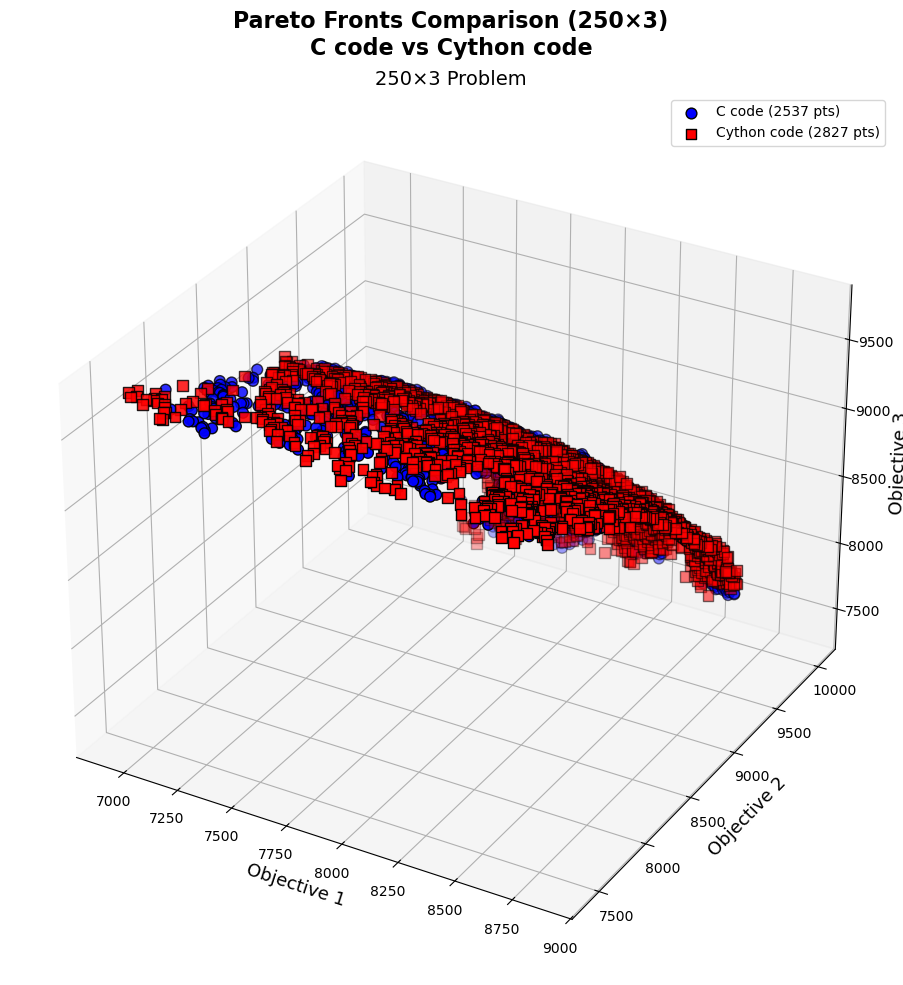

✅ 3D Comparison plot saved: compare_5003_c_cython_3d.png


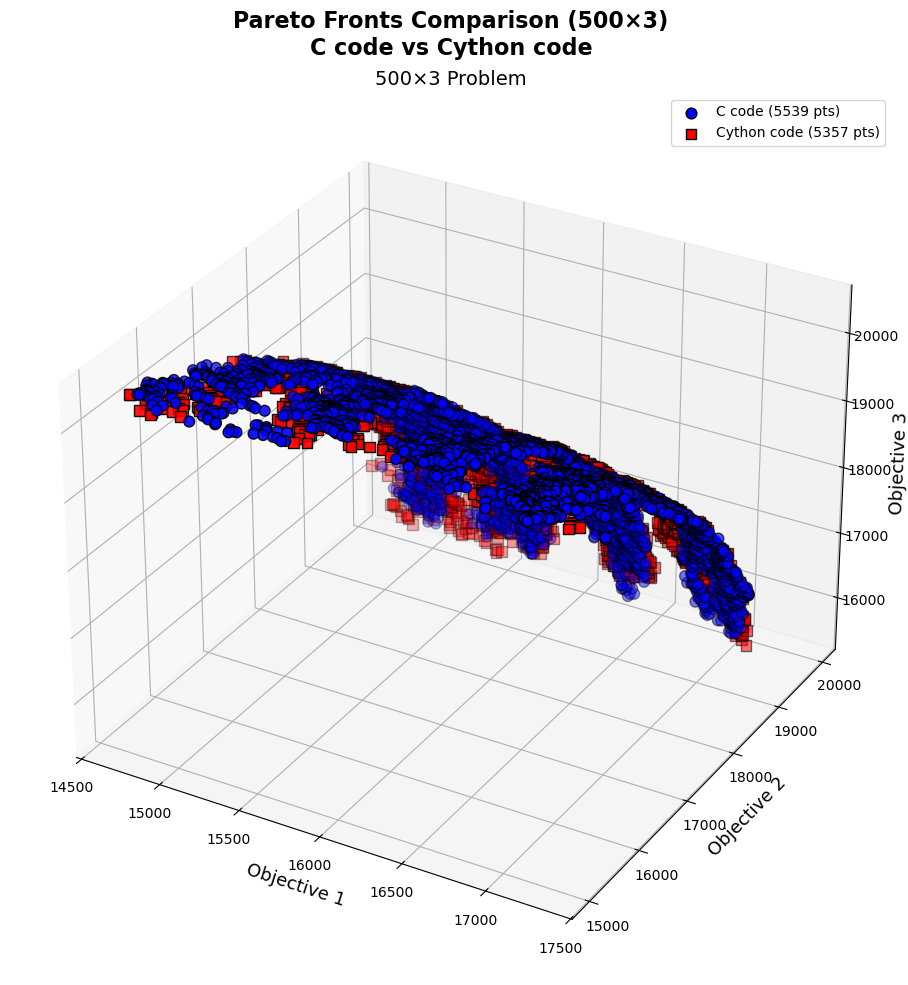

✅ 3D Comparison plot saved: compare_7503_c_cython_3d.png


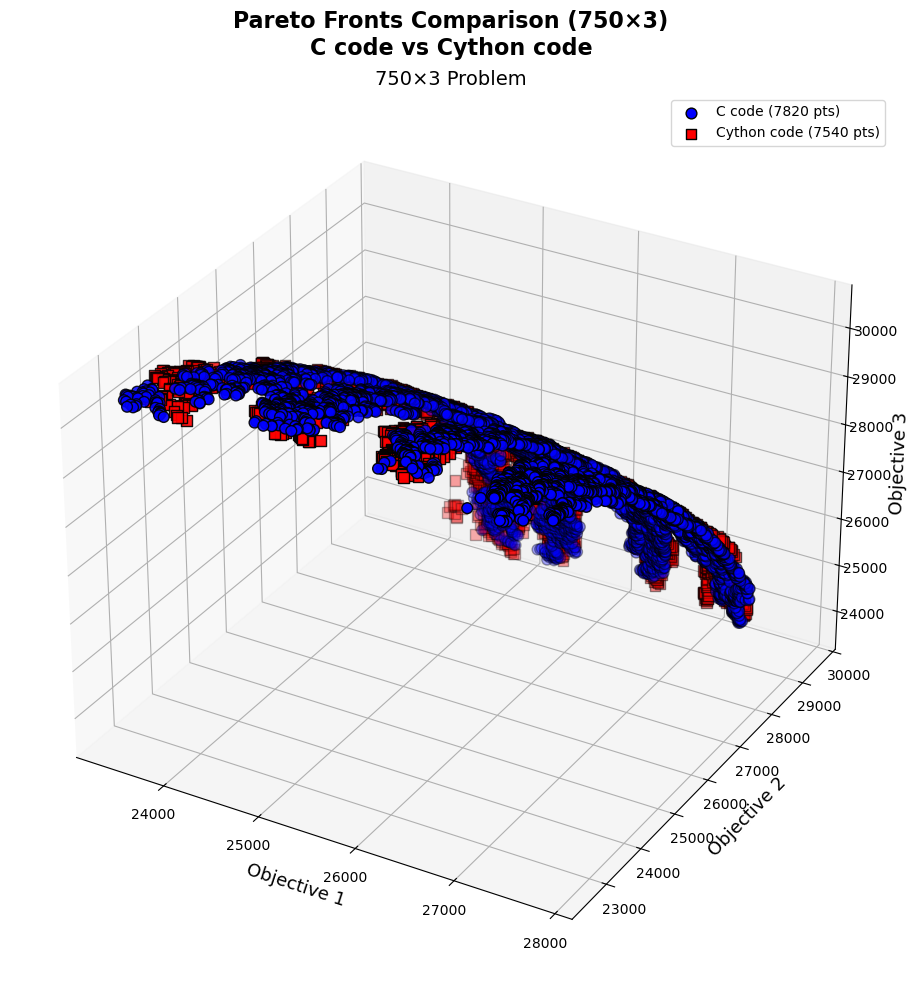

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import os

def read_pareto_file(filename, n_obj):
    points = []
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return points
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                vals = [float(x) for x in line.split()]
                if len(vals) >= n_obj:
                    points.append({'objectives': vals[:n_obj]})
    return points

def get_true_pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i == j:
                continue
            # Maximization Pareto logic
            if all(x >= y for x, y in zip(q['objectives'], p['objectives'])) and any(x > y for x, y in zip(q['objectives'], p['objectives'])):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def compare_c_cython_3d(c_file, cython_file, label, output_file):
    colors = ['blue', 'red']
    labels = ['C code', 'Cython code']
    n_obj = 3

    # Read and extract Pareto fronts
    c_points = get_true_pareto_front(read_pareto_file(c_file, n_obj))
    cython_points = get_true_pareto_front(read_pareto_file(cython_file, n_obj))

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle(f'Pareto Fronts Comparison ({label})\nC code vs Cython code', fontsize=16, fontweight='bold')

    # Plot C code
    obj_c = np.array([p['objectives'] for p in c_points])
    ax.scatter(obj_c[:,0], obj_c[:,1], obj_c[:,2], c=colors[0], label=f"{labels[0]} ({len(c_points)} pts)", marker='o', edgecolors='black', s=60)

    # Plot Cython code
    obj_cy = np.array([p['objectives'] for p in cython_points])
    ax.scatter(obj_cy[:,0], obj_cy[:,1], obj_cy[:,2], c=colors[1], label=f"{labels[1]} ({len(cython_points)} pts)", marker='s', edgecolors='black', s=60)

    ax.set_xlabel('Objective 1', fontsize=13)
    ax.set_ylabel('Objective 2', fontsize=13)
    ax.set_zlabel('Objective 3', fontsize=13)
    ax.set_title(f'{label} Problem', fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ 3D Comparison plot saved: {output_file}")
    plt.show()

if __name__ == "__main__":
    # 2503
    compare_c_cython_3d(
        os.path.join('LS C', '2503_CResults.txt'),
        '2503_Resulats.txt',
        '250×3',
        'compare_2503_c_cython_3d.png'
    )
    # 5003
    compare_c_cython_3d(
        os.path.join('LS C', '5003_CResults.txt'),
        '5003_Resulats.txt',
        '500×3',
        'compare_5003_c_cython_3d.png'
    )
    # 7503
    compare_c_cython_3d(
        os.path.join('LS C', '7503_CResults.txt'),
        '7503_Resulats.txt',
        '750×3',
        'compare_7503_c_cython_3d.png'
    )

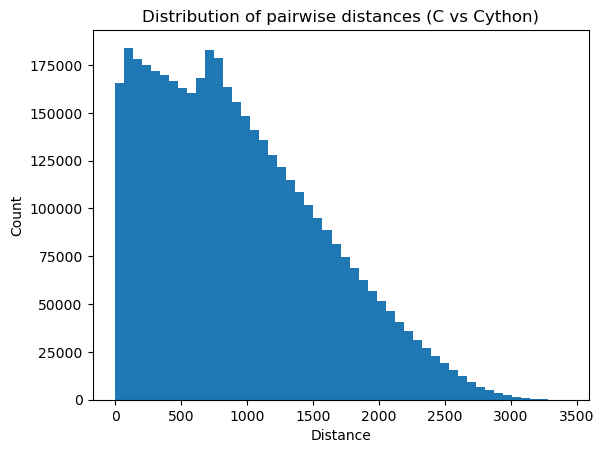

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import os

def read_pareto_file(filename, n_obj):
    points = []
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return points
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                vals = [float(x) for x in line.split()]
                if len(vals) >= n_obj:
                    points.append({'objectives': vals[:n_obj]})
    return points

def compute_distances(points1, points2):
    arr1 = np.array([p['objectives'] for p in points1])
    arr2 = np.array([p['objectives'] for p in points2])
    distances = []
    for p in arr1:
        dists = np.linalg.norm(arr2 - p, axis=1)
        distances.extend(dists)
    return np.array(distances)

if __name__ == "__main__":
    # Change these to your actual files and problem dimension
    c_file = os.path.join('LS C', '2502_CResults.txt')
    cython_file = '2502_Resulats.txt'
    n_obj = 2  # Change to 3 or 4 for 3D/4D problems

    c_points = read_pareto_file(c_file, n_obj)
    cython_points = read_pareto_file(cython_file, n_obj)

    distances = compute_distances(c_points, cython_points)
    plt.hist(distances, bins=50)
    plt.xlabel('Distance')
    plt.ylabel('Count')
    plt.title('Distribution of pairwise distances (C vs Cython)')
    plt.show()

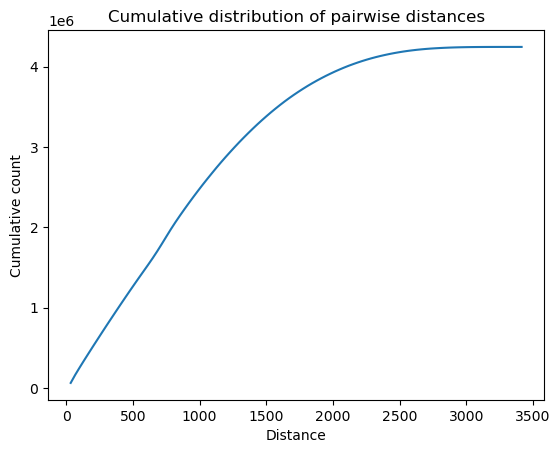

In [97]:
import matplotlib.pyplot as plt
import numpy as np

count, bins = np.histogram(distances, bins=100)
cum_count = np.cumsum(count)
plt.plot(bins[1:], cum_count)
plt.xlabel('Distance')
plt.ylabel('Cumulative count')
plt.title('Cumulative distribution of pairwise distances')
plt.show()

✅ Comparison plot with highlighted close points saved: compare_2502_c_cython_highlight.png


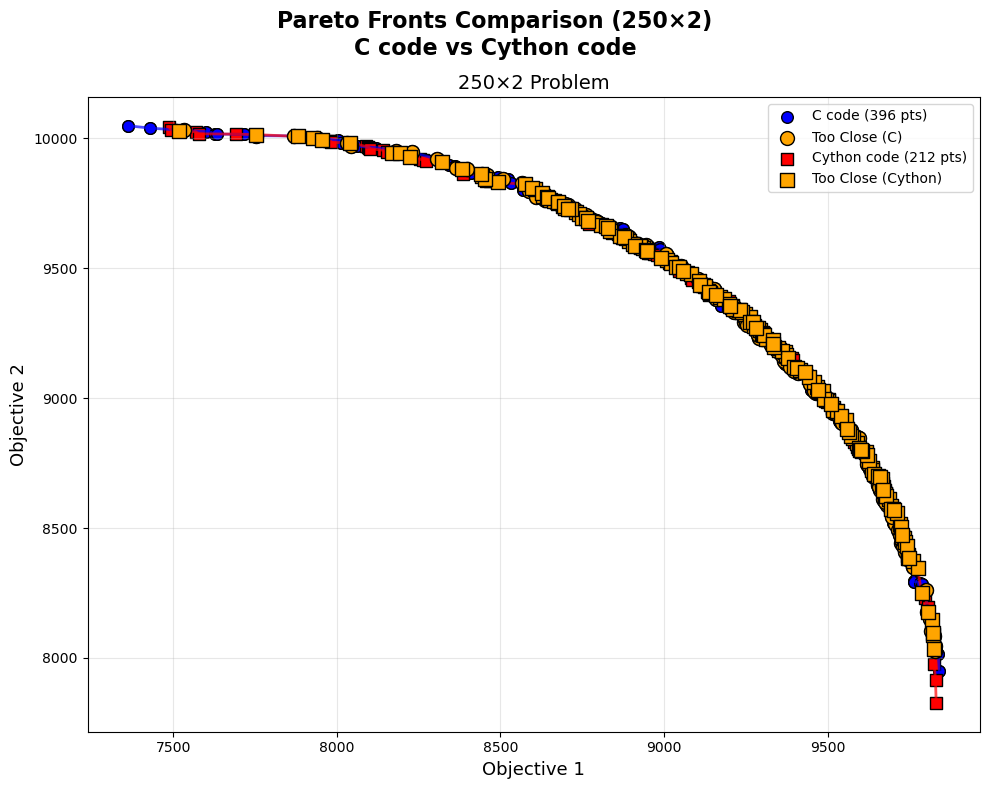

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import os

def read_pareto_file(filename, n_obj):
    points = []
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return points
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                vals = [float(x) for x in line.split()]
                if len(vals) >= n_obj:
                    points.append({'objectives': vals[:n_obj]})
    return points

def get_true_pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i == j:
                continue
            if all(x >= y for x, y in zip(q['objectives'], p['objectives'])) and any(x > y for x, y in zip(q['objectives'], p['objectives'])):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def find_close_points(points1, points2, threshold):
    # Returns indices of points in points1 that are close to any in points2
    arr1 = np.array([p['objectives'] for p in points1])
    arr2 = np.array([p['objectives'] for p in points2])
    close_idx1 = []
    for i, p in enumerate(arr1):
        dists = np.linalg.norm(arr2 - p, axis=1)
        if np.any(dists < threshold):
            close_idx1.append(i)
    return close_idx1

def compare_c_cython_2d_highlight(c_file, cython_file, label, output_file, threshold=1.0):
    colors = ['blue', 'red']
    labels = ['C code', 'Cython code']
    highlight_color = 'orange'
    n_obj = 2

    # Read and extract Pareto fronts
    c_points = get_true_pareto_front(read_pareto_file(c_file, n_obj))
    cython_points = get_true_pareto_front(read_pareto_file(cython_file, n_obj))

    # Find close points
    close_c = find_close_points(c_points, cython_points, threshold)
    close_cython = find_close_points(cython_points, c_points, threshold)

    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle(f'Pareto Fronts Comparison ({label})\nC code vs Cython code', fontsize=16, fontweight='bold')

    # Plot C code
    obj_c = np.array([p['objectives'] for p in c_points])
    sorted_c_idx = np.argsort(obj_c[:,0])
    sorted_c = obj_c[sorted_c_idx]
    ax.scatter(sorted_c[:,0], sorted_c[:,1], c=colors[0], label=f"{labels[0]} ({len(c_points)} pts)", marker='o', edgecolors='black', s=70)
    ax.plot(sorted_c[:,0], sorted_c[:,1], color=colors[0], linewidth=2, alpha=0.7)

    # Highlight C points that are close
    if close_c:
        close_c_arr = obj_c[close_c]
        ax.scatter(close_c_arr[:,0], close_c_arr[:,1], c=highlight_color, label='Too Close (C)', marker='o', edgecolors='black', s=100, zorder=5)

    # Plot Cython code
    obj_cy = np.array([p['objectives'] for p in cython_points])
    sorted_cy_idx = np.argsort(obj_cy[:,0])
    sorted_cy = obj_cy[sorted_cy_idx]
    ax.scatter(sorted_cy[:,0], sorted_cy[:,1], c=colors[1], label=f"{labels[1]} ({len(cython_points)} pts)", marker='s', edgecolors='black', s=70)
    ax.plot(sorted_cy[:,0], sorted_cy[:,1], color=colors[1], linewidth=2, alpha=0.7)

    # Highlight Cython points that are close
    if close_cython:
        close_cy_arr = obj_cy[close_cython]
        ax.scatter(close_cy_arr[:,0], close_cy_arr[:,1], c=highlight_color, label='Too Close (Cython)', marker='s', edgecolors='black', s=100, zorder=5)

    ax.set_xlabel('Objective 1', fontsize=13)
    ax.set_ylabel('Objective 2', fontsize=13)
    ax.set_title(f'{label} Problem', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ Comparison plot with highlighted close points saved: {output_file}")
    plt.show()

if __name__ == "__main__":
    # Example for 2502
    compare_c_cython_2d_highlight(
        os.path.join('LS C', '2502_CResults.txt'),
        '2502_Resulats.txt',
        '250×2',
        'compare_2502_c_cython_highlight.png',
        threshold=20.0  # Adjust threshold as needed!
    )

✅ 3D Projections comparison plot saved: compare_2503_c_cython_3d_projections.png


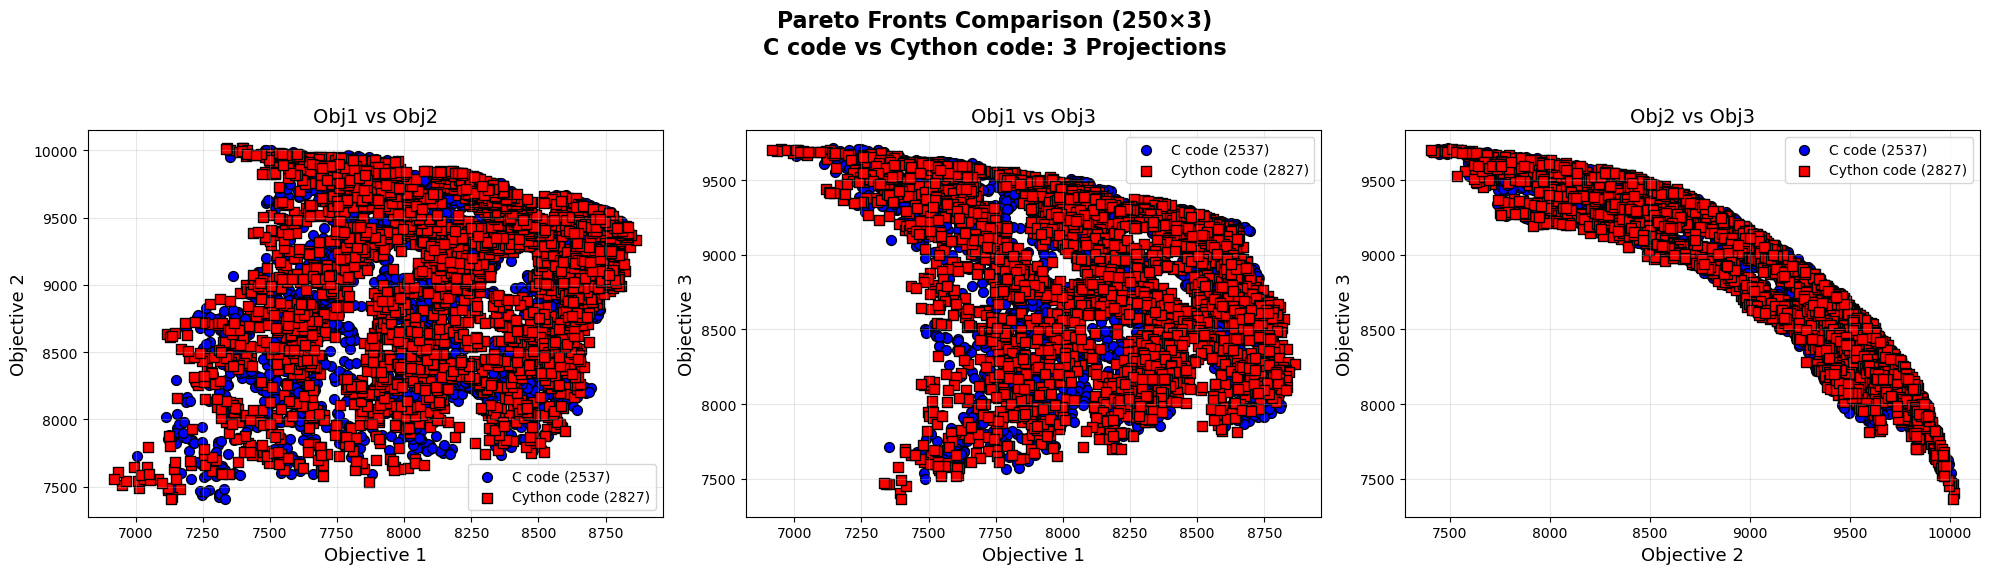

✅ 3D Projections comparison plot saved: compare_5003_c_cython_3d_projections.png


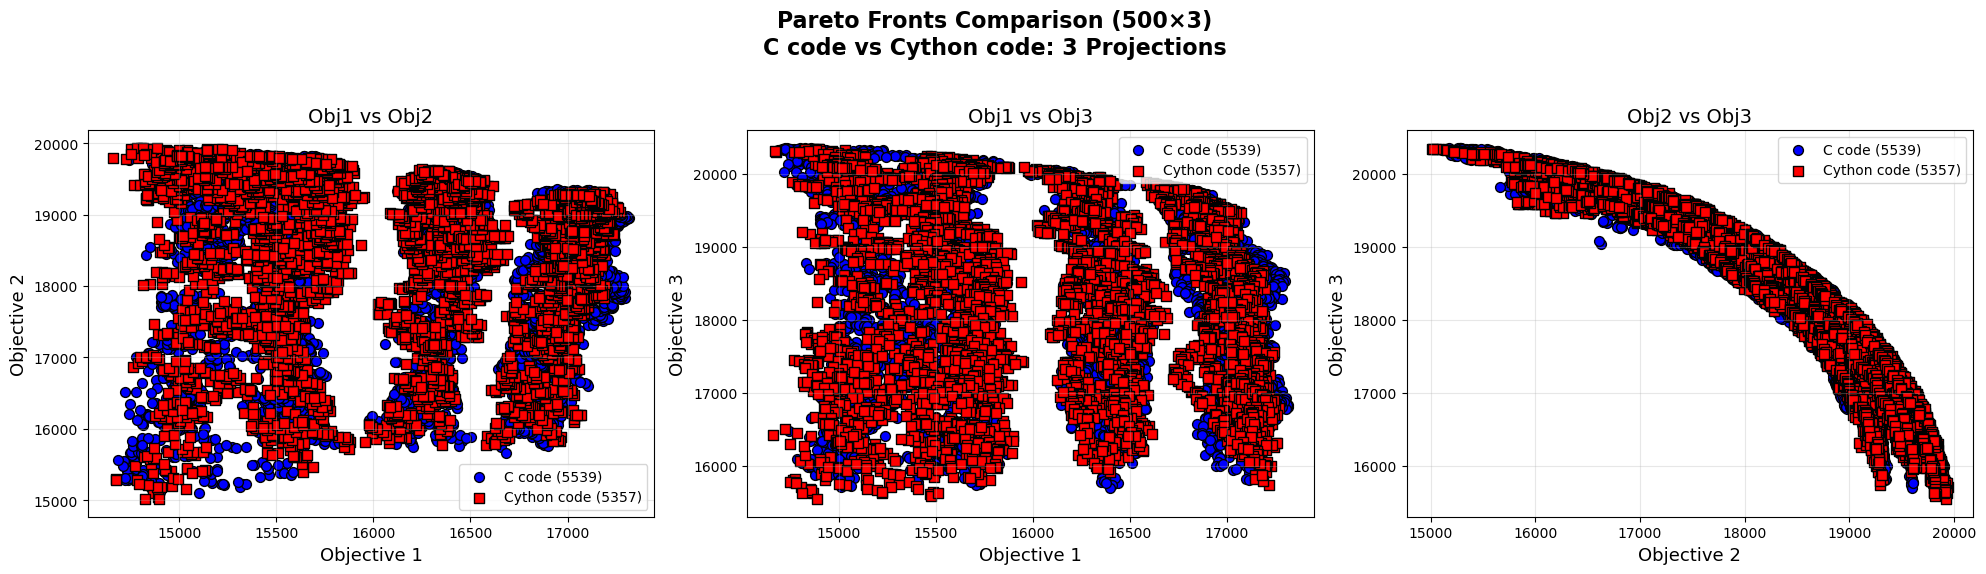

✅ 3D Projections comparison plot saved: compare_7503_c_cython_3d_projections.png


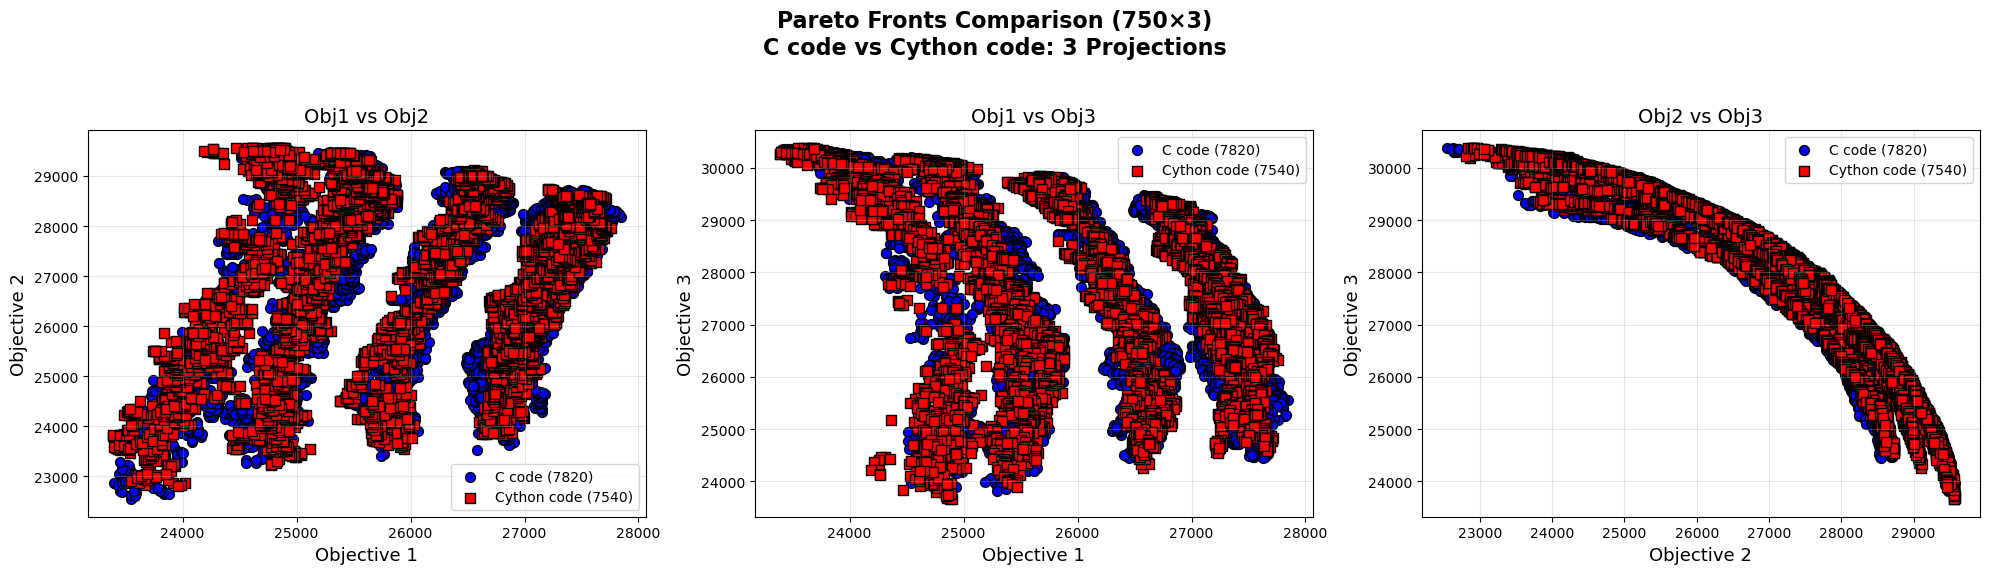

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import os

def read_pareto_file(filename, n_obj):
    points = []
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return points
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                vals = [float(x) for x in line.split()]
                if len(vals) >= n_obj:
                    points.append({'objectives': vals[:n_obj]})
    return points

def get_true_pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i == j:
                continue
            # Maximization Pareto logic
            if all(x >= y for x, y in zip(q['objectives'], p['objectives'])) and any(x > y for x, y in zip(q['objectives'], p['objectives'])):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def compare_c_cython_3d_projections(c_file, cython_file, label, output_file):
    colors = ['blue', 'red']
    labels = ['C code', 'Cython code']
    n_obj = 3

    # Read and extract Pareto fronts
    c_points = get_true_pareto_front(read_pareto_file(c_file, n_obj))
    cython_points = get_true_pareto_front(read_pareto_file(cython_file, n_obj))

    obj_c = np.array([p['objectives'] for p in c_points])
    obj_cy = np.array([p['objectives'] for p in cython_points])

    projections = [(0,1,'Obj1 vs Obj2'), (0,2,'Obj1 vs Obj3'), (1,2,'Obj2 vs Obj3')]
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f'Pareto Fronts Comparison ({label})\nC code vs Cython code: 3 Projections', fontsize=16, fontweight='bold')

    for idx, (x_idx, y_idx, title) in enumerate(projections):
        ax = axes[idx]
        # Plot C code
        ax.scatter(obj_c[:,x_idx], obj_c[:,y_idx], c=colors[0], label=f"{labels[0]} ({len(obj_c)})", marker='o', edgecolors='black', s=50)
        # Plot Cython code
        ax.scatter(obj_cy[:,x_idx], obj_cy[:,y_idx], c=colors[1], label=f"{labels[1]} ({len(obj_cy)})", marker='s', edgecolors='black', s=50)
        ax.set_xlabel(f'Objective {x_idx+1}', fontsize=13)
        ax.set_ylabel(f'Objective {y_idx+1}', fontsize=13)
        ax.set_title(title, fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ 3D Projections comparison plot saved: {output_file}")
    plt.show()

if __name__ == "__main__":
    # 2503
    compare_c_cython_3d_projections(
        os.path.join('LS C', '2503_CResults.txt'),
        '2503_Resulats.txt',
        '250×3',
        'compare_2503_c_cython_3d_projections.png'
    )
    # 5003
    compare_c_cython_3d_projections(
        os.path.join('LS C', '5003_CResults.txt'),
        '5003_Resulats.txt',
        '500×3',
        'compare_5003_c_cython_3d_projections.png'
    )
    # 7503
    compare_c_cython_3d_projections(
        os.path.join('LS C', '7503_CResults.txt'),
        '7503_Resulats.txt',
        '750×3',
        'compare_7503_c_cython_3d_projections.png'
    )

✅ 4D Projections comparison plot saved: compare_2504_c_cython_4d_projections_highlight.png


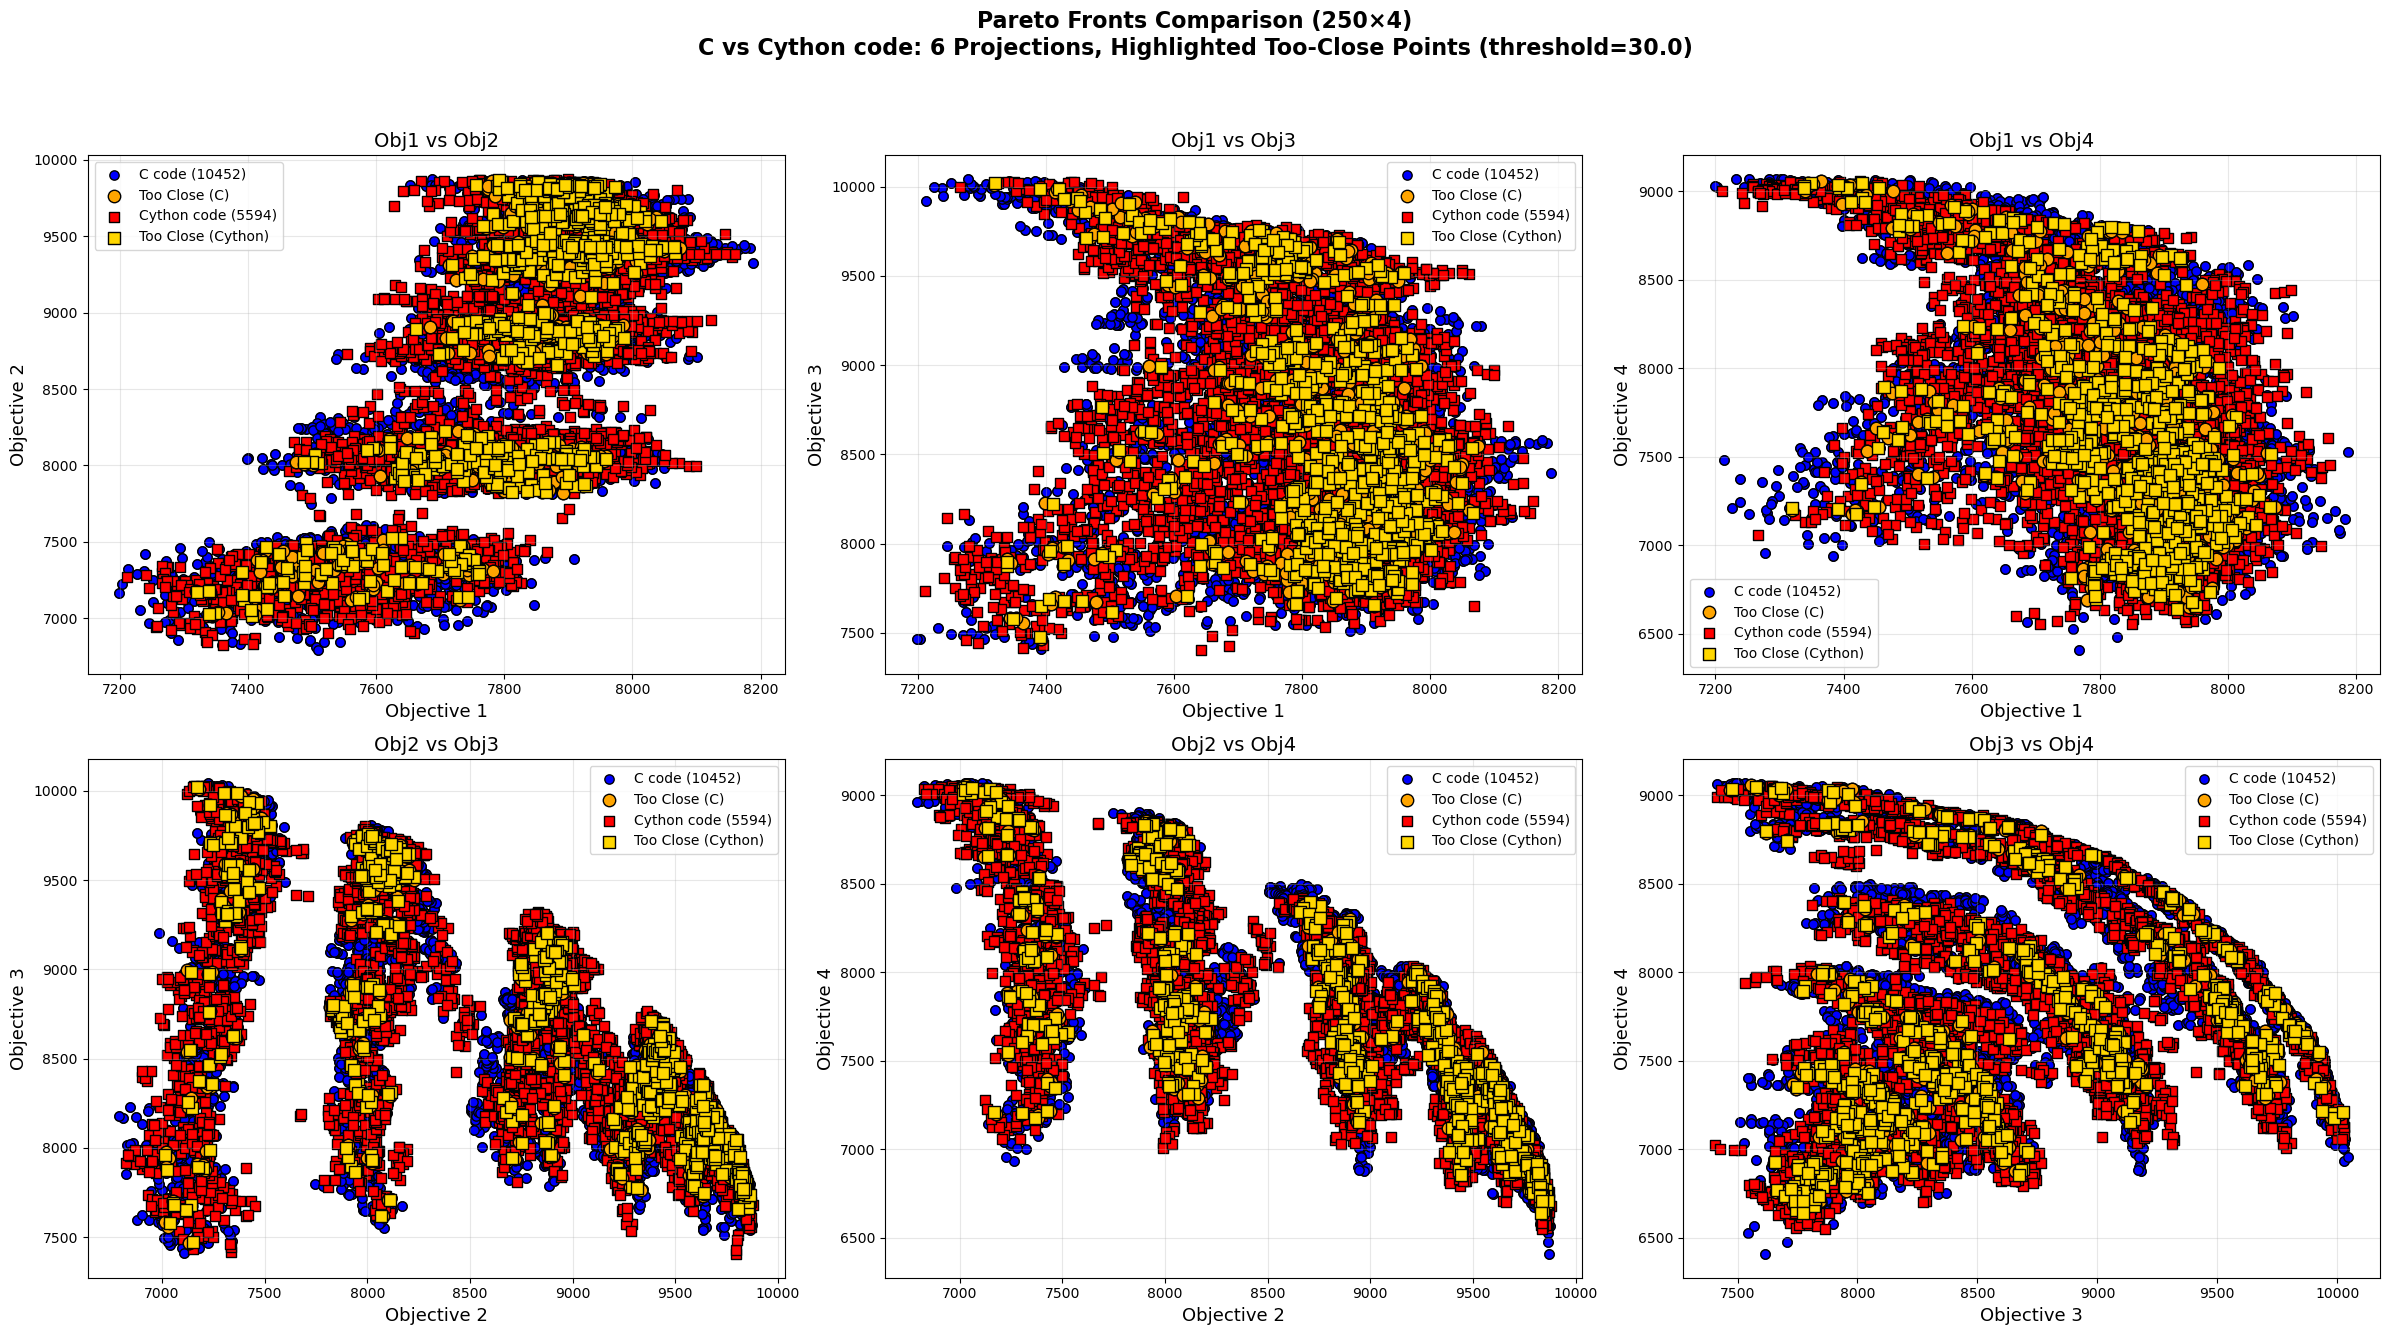

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import os

def read_pareto_file(filename, n_obj):
    points = []
    if not os.path.exists(filename):
        print(f"File not found: {filename}")
        return points
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                vals = [float(x) for x in line.split()]
                if len(vals) >= n_obj:
                    points.append({'objectives': vals[:n_obj]})
    return points

def get_true_pareto_front(points):
    pareto = []
    for i, p in enumerate(points):
        dominated = False
        for j, q in enumerate(points):
            if i == j:
                continue
            # Maximization Pareto logic
            if all(x >= y for x, y in zip(q['objectives'], p['objectives'])) and any(x > y for x, y in zip(q['objectives'], p['objectives'])):
                dominated = True
                break
        if not dominated:
            pareto.append(p)
    return pareto

def find_close_points(points1, points2, threshold):
    # Returns indices of points in points1 that are close to any in points2
    arr1 = np.array([p['objectives'] for p in points1])
    arr2 = np.array([p['objectives'] for p in points2])
    close_idx1 = []
    for i, p in enumerate(arr1):
        dists = np.linalg.norm(arr2 - p, axis=1)
        if np.any(dists < threshold):
            close_idx1.append(i)
    return close_idx1

def compare_c_cython_4d_projections_highlight(c_file, cython_file, label, output_file, threshold=30.0):
    colors = ['blue', 'red']
    labels = ['C code', 'Cython code']
    highlight_c = 'orange'
    highlight_cy = 'gold'
    n_obj = 4

    # Read and extract Pareto fronts
    c_points = get_true_pareto_front(read_pareto_file(c_file, n_obj))
    cython_points = get_true_pareto_front(read_pareto_file(cython_file, n_obj))

    # Find close points
    close_c = find_close_points(c_points, cython_points, threshold)
    close_cy = find_close_points(cython_points, c_points, threshold)

    obj_c = np.array([p['objectives'] for p in c_points])
    obj_cy = np.array([p['objectives'] for p in cython_points])

    projections = [
        (0, 1, 'Obj1 vs Obj2'),
        (0, 2, 'Obj1 vs Obj3'),
        (0, 3, 'Obj1 vs Obj4'),
        (1, 2, 'Obj2 vs Obj3'),
        (1, 3, 'Obj2 vs Obj4'),
        (2, 3, 'Obj3 vs Obj4')
    ]
    fig, axes = plt.subplots(2, 3, figsize=(24, 14))
    fig.suptitle(f'Pareto Fronts Comparison ({label})\nC vs Cython code: 6 Projections, Highlighted Too-Close Points (threshold={threshold})', fontsize=16, fontweight='bold')

    for idx, (x_idx, y_idx, title) in enumerate(projections):
        ax = axes[idx // 3, idx % 3]
        # Plot C code
        ax.scatter(obj_c[:,x_idx], obj_c[:,y_idx], c=colors[0], label=f"{labels[0]} ({len(obj_c)})", marker='o', edgecolors='black', s=45)
        # Highlight C points that are close
        if close_c:
            close_c_arr = obj_c[close_c]
            ax.scatter(close_c_arr[:,x_idx], close_c_arr[:,y_idx], c=highlight_c, label='Too Close (C)', marker='o', edgecolors='black', s=80, zorder=5)
        # Plot Cython code
        ax.scatter(obj_cy[:,x_idx], obj_cy[:,y_idx], c=colors[1], label=f"{labels[1]} ({len(obj_cy)})", marker='s', edgecolors='black', s=45)
        # Highlight Cython points that are close
        if close_cy:
            close_cy_arr = obj_cy[close_cy]
            ax.scatter(close_cy_arr[:,x_idx], close_cy_arr[:,y_idx], c=highlight_cy, label='Too Close (Cython)', marker='s', edgecolors='black', s=80, zorder=5)
        ax.set_xlabel(f'Objective {x_idx+1}', fontsize=13)
        ax.set_ylabel(f'Objective {y_idx+1}', fontsize=13)
        ax.set_title(title, fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.legend()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✅ 4D Projections comparison plot saved: {output_file}")
    plt.show()

if __name__ == "__main__":
    # 2504
    compare_c_cython_4d_projections_highlight(
        os.path.join('LS C', '2504_CResults.txt'),
        '2504_Resulats.txt',
        '250×4',
        'compare_2504_c_cython_4d_projections_highlight.png',
        threshold=30.0
    )


In [ ]:
    # 5004
    compare_c_cython_4d_projections_highlight(
        os.path.join('LS C', '5004_CResults.txt'),
        '5004_Resulats.txt',
        '500×4',
        'compare_5004_c_cython_4d_projections_highlight.png',
        threshold=30.0
    )
    # 7504
    compare_c_cython_4d_projections_highlight(
        os.path.join('LS C', '7504_CResults.txt'),
        '7504_Resulats.txt',
        '750×4',
        'compare_7504_c_cython_4d_projections_highlight.png',
        threshold=30.0
    )

In [107]:
####################################################agent integré############################################################

In [ ]:
%load_ext cython

In [3]:
%%cython
from libc.stdlib cimport malloc, free
from libc.stdio cimport printf

cdef struct ind:
    int fitness
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

cdef void *chk_malloc(size_t size, const char* msg):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        printf("ERROR: Out of memory at %s\n", msg)
        raise MemoryError("Out of memory.")
    printf("Allocated %s (%d bytes)\n", msg, size)
    return return_value

def py_create_ind(int ni):
    printf("Creating individual with %d items...\n", ni)
    cdef ind* p = <ind *>chk_malloc(sizeof(ind), b"ind")
    p.fitness = 0
    p.Items = <int *>chk_malloc(ni * sizeof(int), b"Items")
    for i in range(ni):
        p.Items[i] = 0
    printf("Individual created at %p\n", p)
    return <unsigned long>p

def py_free_ind(unsigned long ptr):
    cdef ind* p = <ind *>ptr
    if p != NULL:
        printf("Freeing individual at %p\n", p)
        free(p.Items)
        free(p)
    else:
        printf("Skipping NULL individual free\n")

def py_create_pop(int maxsize, int ni):
    printf("Creating population of size %d (ni=%d)...\n", maxsize, ni)
    cdef pop* p = <pop *>chk_malloc(sizeof(pop), b"pop")
    p.size = 0
    p.maxsize = maxsize
    p.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*), b"ind_array")
    for i in range(maxsize):
        p.ind_array[i] = NULL
    printf("Population created at %p\n", p)
    return <unsigned long>p

def py_add_ind_to_pop(unsigned long pop_ptr, unsigned long ind_ptr, int idx):
    cdef pop* P = <pop *>pop_ptr
    cdef ind* I = <ind *>ind_ptr
    printf("Adding individual %p to pop %p at idx %d\n", I, P, idx)
    P.ind_array[idx] = I
    if idx+1 > P.size:
        P.size = idx+1

def get_pop_size(unsigned long pop_ptr):
    cdef pop* P = <pop *>pop_ptr
    return P.size

def get_ind_ptr(unsigned long pop_ptr, int idx):
    cdef pop* P = <pop *>pop_ptr
    if idx < 0 or idx >= P.size or P.ind_array[idx] == NULL:
        printf("get_ind_ptr: NULL or invalid idx %d (size=%d)\n", idx, P.size)
        return 0
    return <unsigned long>P.ind_array[idx]

def py_free_pop(unsigned long pop_ptr, int ni):
    cdef pop* P = <pop *>pop_ptr
    printf("Freeing pop at %p\n", P)
    for i in range(P.size):
        if P.ind_array[i] != NULL:
            printf("Freeing individual #%d at %p\n", i, P.ind_array[i])
            free(P.ind_array[i].Items)
            free(P.ind_array[i])
            P.ind_array[i] = NULL
        else:
            printf("Skipping NULL ind at idx %d\n", i)
    free(P.ind_array)
    free(P)
    printf("Population freed.\n")

In [ ]:
class IndWrap:
    def __init__(self, ptr):
        self.ptr = ptr

class PopWrap:
    def __init__(self, maxsize, ni):
        self.ptr = py_create_pop(maxsize, ni)
        self._size = maxsize
        self.ni = ni

    def size(self):
        return get_pop_size(self.ptr)

    def get_ind(self, idx):
        ptr = get_ind_ptr(self.ptr, idx)
        if ptr == 0:
            print(f"get_ind: NULL pointer at idx {idx}")
            return None
        return IndWrap(ptr)

    def free(self):
        print("Freeing population (Python)...")
        py_free_pop(self.ptr, self.ni)
        self.ptr = None
        print("Population freed (Python).")

def initialize_population(popwrap, ni):
    for i in range(popwrap._size):
        ind_ptr = py_create_ind(ni)
        py_add_ind_to_pop(popwrap.ptr, ind_ptr, i)
        print(f"Added individual {i}")

# TEST: Use very small sizes!
ni = 3
alpha = 2

pop = PopWrap(alpha, ni)
initialize_population(pop, ni)
print("Population size after init:", pop.size())

# Try to access all individuals
for i in range(pop.size()):
    ind = pop.get_ind(i)
    if ind is not None:
        print(f"ind at idx {i}: ptr={ind.ptr}")
    else:
        print(f"ind at idx {i}: NULL")

pop.free()
print("End of test. If you see this, memory management is correct.")

In [1]:
####################

In [9]:
%%cython
from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

# Globals that reset per run
cdef int ni = 250

cdef void evaluate(ind* x): pass
cdef void Indicator_local_search1(pop* SP, pop* Sarchive, int size): pass
cdef void loadMOKP(char* filename): pass
cdef void read_weights_file(char* filename): pass
cdef void choose_weight(): pass
cdef void P_init_pop(pop* SP, pop* Sarchive, int alpha): pass
cdef int extractPtoArchive(pop* P, pop* archive): return 0
cdef void calcul_weight(pop* SP, int size): pass
cdef double calcMaxbound(pop* SP, int size): return 1.0
cdef void compute_all_fitness(pop* SP): pass
cdef void complete_free_pop(pop* pp): pass

cdef void simple_perturbation(ind* x):
    cdef int idx = rand() % ni
    x.Items[idx] = 1 - x.Items[idx]
    evaluate(x)

cdef enum HeuristicType:
    LOCAL_SEARCH = 0
    MUTATION = 1
    COOPERATION = 2

cdef class HyperHeuristicAgent:
    cdef public int last_heuristic
    cdef public int num_heuristics
    cdef public object history

    def __cinit__(self):
        self.last_heuristic = -1
        self.num_heuristics = 3
        self.history = []

    cpdef int select_heuristic(self, int iter_num):
        selected = rand() % self.num_heuristics
        self.last_heuristic = selected
        self.history.append(selected)
        return selected

    cdef void apply_heuristic(self, int htype, pop* solutions, pop* archive, int size):
        if htype == HeuristicType.LOCAL_SEARCH:
            Indicator_local_search1(solutions, archive, size)
        elif htype == HeuristicType.MUTATION:
            self.apply_mutation(solutions, size)
        elif htype == HeuristicType.COOPERATION:
            self.apply_cooperation(solutions, size)
        else:
            raise ValueError("Unknown heuristic type")

    cdef void apply_mutation(self, pop* solutions, int size):
        cdef int i
        for i in range(solutions.size):
            simple_perturbation(solutions.ind_array[i])

    cdef void apply_cooperation(self, pop* solutions, int size):
        cdef int i, j, k, pt, tmp
        for i in range(0, solutions.size-1, 2):
            j = i+1
            pt = rand() % ni
            for k in range(pt, ni):
                tmp = solutions.ind_array[i].d[k]
                solutions.ind_array[i].d[k] = solutions.ind_array[j].d[k]
                solutions.ind_array[j].d[k] = tmp
                tmp = solutions.ind_array[i].Items[k]
                solutions.ind_array[i].Items[k] = solutions.ind_array[j].Items[k]
                solutions.ind_array[j].Items[k] = tmp
            evaluate(solutions.ind_array[i])
            evaluate(solutions.ind_array[j])

Content of stdout:
_cython_magic_c7fbd33a3a52d337a5429d1915e68f7e87695640441f85c8192b1c7ac31563ca.c
   Cr‚ation de la bibliothŠque C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal\.ipython\cython\_cython_magic_c7fbd33a3a52d337a5429d1915e68f7e87695640441f85c8192b1c7ac31563ca.cp39-win_amd64.lib et de l'objet C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal\.ipython\cython\_cython_magic_c7fbd33a3a52d337a5429d1915e68f7e87695640441f85c8192b1c7ac31563ca.cp39-win_amd64.exp
G‚n‚ration de code en cours
Fin de la g‚n‚ration du code

In [11]:
%%cython

# This cell provides all required stub declarations so the main loop will compile in a notebook.
# You must run this cell before running the main loop cell!

from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

cdef void seed(int x): pass
cdef void loadMOKP(char* filename): pass
cdef void read_weights_file(char* filename): pass
cdef pop* create_pop(int maxsize, int nf): return NULL
cdef void choose_weight(): pass
cdef void P_init_pop(pop* SP, pop* Sarchive, int alpha): pass
cdef int extractPtoArchive(pop* P, pop* archive): return 0
cdef void calcul_weight(pop* SP, int size): pass
cdef double calcMaxbound(pop* SP, int size): return 1.0
cdef void compute_all_fitness(pop* SP): pass
cdef void complete_free_pop(pop* pp): pass

Content of stdout:
_cython_magic_00e97151add3820af0e0f7c5f6ee57aac7fb6d12e72bdeb04fb1c6a6f137f403.c
   Cr‚ation de la bibliothŠque C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal\.ipython\cython\_cython_magic_00e97151add3820af0e0f7c5f6ee57aac7fb6d12e72bdeb04fb1c6a6f137f403.cp39-win_amd64.lib et de l'objet C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal\.ipython\cython\_cython_magic_00e97151add3820af0e0f7c5f6ee57aac7fb6d12e72bdeb04fb1c6a6f137f403.cp39-win_amd64.exp
G‚n‚ration de code en cours
Fin de la g‚n‚ration du code

In [12]:
%%cython
from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

cdef int ni = 250

cdef void evaluate(ind* x): pass
cdef void Indicator_local_search1(pop* SP, pop* Sarchive, int size): pass
cdef void loadMOKP(char* filename): pass
cdef void read_weights_file(char* filename): pass
cdef pop* create_pop(int maxsize, int nf): return NULL
cdef void choose_weight(): pass
cdef void P_init_pop(pop* SP, pop* Sarchive, int alpha): pass
cdef int extractPtoArchive(pop* P, pop* archive): return 0
cdef void calcul_weight(pop* SP, int size): pass
cdef double calcMaxbound(pop* SP, int size): return 1.0
cdef void compute_all_fitness(pop* SP): pass
cdef void complete_free_pop(pop* pp): pass

cdef void simple_perturbation(ind* x):
    cdef int idx = rand() % ni
    x.Items[idx] = 1 - x.Items[idx]
    evaluate(x)

cdef enum HeuristicType:
    LOCAL_SEARCH = 0
    MUTATION = 1
    COOPERATION = 2

cdef class HyperHeuristicAgent:
    cdef public int last_heuristic
    cdef public int num_heuristics
    cdef public object history

    def __cinit__(self):
        self.last_heuristic = -1
        self.num_heuristics = 3
        self.history = []

    cpdef int select_heuristic(self, int iter_num):
        selected = rand() % self.num_heuristics
        self.last_heuristic = selected
        self.history.append(selected)
        return selected

    cdef void apply_heuristic(self, int htype, pop* solutions, pop* archive, int size):
        if htype == HeuristicType.LOCAL_SEARCH:
            Indicator_local_search1(solutions, archive, size)
        elif htype == HeuristicType.MUTATION:
            self.apply_mutation(solutions, size)
        elif htype == HeuristicType.COOPERATION:
            self.apply_cooperation(solutions, size)
        else:
            raise ValueError("Unknown heuristic type")

    cdef void apply_mutation(self, pop* solutions, int size):
        cdef int i
        for i in range(solutions.size):
            simple_perturbation(solutions.ind_array[i])

    cdef void apply_cooperation(self, pop* solutions, int size):
        cdef int i, j, k, pt, tmp
        for i in range(0, solutions.size-1, 2):
            j = i+1
            pt = rand() % ni
            for k in range(pt, ni):
                tmp = solutions.ind_array[i].d[k]
                solutions.ind_array[i].d[k] = solutions.ind_array[j].d[k]
                solutions.ind_array[j].d[k] = tmp
                tmp = solutions.ind_array[i].Items[k]
                solutions.ind_array[i].Items[k] = solutions.ind_array[j].Items[k]
                solutions.ind_array[j].Items[k] = tmp
            evaluate(solutions.ind_array[i])
            evaluate(solutions.ind_array[j])

Content of stdout:
_cython_magic_1a9d0779a4b2dc14978ba8094f26dc9ca05d4f4d0db1c62d4a6cd8ec482c2434.c
   Cr‚ation de la bibliothŠque C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal\.ipython\cython\_cython_magic_1a9d0779a4b2dc14978ba8094f26dc9ca05d4f4d0db1c62d4a6cd8ec482c2434.cp39-win_amd64.lib et de l'objet C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal\.ipython\cython\_cython_magic_1a9d0779a4b2dc14978ba8094f26dc9ca05d4f4d0db1c62d4a6cd8ec482c2434.cp39-win_amd64.exp
G‚n‚ration de code en cours
Fin de la g‚n‚ration du code

In [13]:
%%cython

def run_moacp_with_agent(instance_file, weights_file, nbitems, num_objectives, output_file):
    """
    MOACP runner with integrated agent: at each iteration, the agent chooses one of three heuristics.
    """
    cdef int alpha = 10
    cdef int paretoIni = 28000
    cdef int NBL = 100
    cdef int NRUNS = 10
    cdef int nf = num_objectives
    cdef int ni = nbitems

    agent = HyperHeuristicAgent()

    for run in range(1, NRUNS+1):
        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")

        seed(run)
        loadMOKP(instance_file)
        read_weights_file(weights_file)

        P = create_pop(paretoIni, nf)
        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)

            # --- AGENT selects and applies heuristic ---
            htype = agent.select_heuristic(it)
            agent.apply_heuristic(htype, solutions, archive, alpha)

            extractPtoArchive(archive, P)
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)

        # Write Pareto front after each run (append mode)
        with open(output_file, "a") as fpareto:
            fpareto.write("\n")
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")

        complete_free_pop(P)


Error compiling Cython file:
------------------------------------------------------------
...
    cdef int NBL = 100
    cdef int NRUNS = 10
    cdef int nf = num_objectives
    cdef int ni = nbitems

    agent = HyperHeuristicAgent()
            ^
------------------------------------------------------------

C:\Users\Aziz il patal\.ipython\cython\_cython_magic_bd8f866a9e6076e8aaf782fc3ddc9f0cb89ba9a8c477401dffda079ffba7203f.pyx:13:12: undeclared name not builtin: HyperHeuristicAgent

Error compiling Cython file:
------------------------------------------------------------
...
    agent = HyperHeuristicAgent()

    for run in range(1, NRUNS+1):
        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")

        seed(run)
        ^
------------------------------------------------------------

C:\Users\Aziz il patal\.ipython\cython\_cython_magic_bd8f866a9e6076e8aaf782fc3ddc9f0cb89ba9a8c477401dffda079ffba7203f.pyx:18:8: undeclared name not built

In [2]:
%%cython

from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset

# ---- Structs ----
cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

# ---- GLOBALS ----
cdef int ni = 250

# ---- Function Stubs ----
cdef void evaluate(ind* x): pass
cdef void Indicator_local_search1(pop* SP, pop* Sarchive, int size): pass
cdef void loadMOKP(char* filename): pass
cdef void read_weights_file(char* filename): pass
cdef pop* create_pop(int maxsize, int nf): return NULL
cdef void choose_weight(): pass
cdef void P_init_pop(pop* SP, pop* Sarchive, int alpha): pass
cdef int extractPtoArchive(pop* P, pop* archive): return 0
cdef void calcul_weight(pop* SP, int size): pass
cdef double calcMaxbound(pop* SP, int size): return 1.0
cdef void compute_all_fitness(pop* SP): pass
cdef void complete_free_pop(pop* pp): pass
cdef void seed(int x): pass

# ---- AGENT ----
cdef void simple_perturbation(ind* x):
    cdef int idx = rand() % ni
    x.Items[idx] = 1 - x.Items[idx]
    evaluate(x)

cdef enum HeuristicType:
    LOCAL_SEARCH = 0
    MUTATION = 1
    COOPERATION = 2

cdef class HyperHeuristicAgent:
    cdef public int last_heuristic
    cdef public int num_heuristics
    cdef public object history

    def __cinit__(self):
        self.last_heuristic = -1
        self.num_heuristics = 3
        self.history = []

    cpdef int select_heuristic(self, int iter_num):
        selected = rand() % self.num_heuristics
        self.last_heuristic = selected
        self.history.append(selected)
        return selected

    cdef void apply_heuristic(self, int htype, pop* solutions, pop* archive, int size):
        if htype == HeuristicType.LOCAL_SEARCH:
            Indicator_local_search1(solutions, archive, size)
        elif htype == HeuristicType.MUTATION:
            self.apply_mutation(solutions, size)
        elif htype == HeuristicType.COOPERATION:
            self.apply_cooperation(solutions, size)
        else:
            raise ValueError("Unknown heuristic type")

    cdef void apply_mutation(self, pop* solutions, int size):
        cdef int i
        for i in range(solutions.size):
            simple_perturbation(solutions.ind_array[i])

    cdef void apply_cooperation(self, pop* solutions, int size):
        cdef int i, j, k, pt, tmp
        for i in range(0, solutions.size-1, 2):
            j = i+1
            pt = rand() % ni
            for k in range(pt, ni):
                tmp = solutions.ind_array[i].d[k]
                solutions.ind_array[i].d[k] = solutions.ind_array[j].d[k]
                solutions.ind_array[j].d[k] = tmp
                tmp = solutions.ind_array[i].Items[k]
                solutions.ind_array[i].Items[k] = solutions.ind_array[j].Items[k]
                solutions.ind_array[j].Items[k] = tmp
            evaluate(solutions.ind_array[i])
            evaluate(solutions.ind_array[j])

# ---- MAIN LOOP ----
def run_moacp_with_agent(instance_file, weights_file, nbitems, num_objectives, output_file):
    """
    MOACP runner with integrated agent: at each iteration, the agent chooses one of three heuristics.
    """
    cdef int alpha = 10
    cdef int paretoIni = 28000
    cdef int NBL = 100
    cdef int NRUNS = 10
    cdef int nf = num_objectives
    cdef int ni = nbitems

    agent = HyperHeuristicAgent()

    for run in range(1, NRUNS+1):
        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")

        seed(run)
        loadMOKP(instance_file)
        read_weights_file(weights_file)

        P = create_pop(paretoIni, nf)
        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)

            # --- AGENT selects and applies heuristic ---
            htype = agent.select_heuristic(it)
            agent.apply_heuristic(htype, solutions, archive, alpha)

            extractPtoArchive(archive, P)
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)

        # Write Pareto front after each run (append mode)
        with open(output_file, "a") as fpareto:
            fpareto.write("\n")
            # This loop is illustrative; real implementation depends on your struct allocation
            # for i in range(P.size):
            #     for j in range(nf):
            #         fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
            #     fpareto.write("\n")

        complete_free_pop(P)

In [ ]:
run_moacp_with_agent(b"250.2.txt", b"Weights_2obj_FQ200.txt", 250, 2, "output.txt")

In [ ]:
#############this work#################

In [14]:
%%cython
# Cython code for MOACP runner: 10 runs, each run of 100 iterations, matching your C code logic

from libc.stdlib cimport malloc, free, srand, rand
from libc.string cimport memset
from libc.math cimport exp
from libc.math cimport fabs

cdef struct ind:
    int nombr_nonpris
    int nombr
    int rank
    float fitnessbest
    float fitness
    int explored
    double *f
    double *capa
    double *v
    int *d
    int *Items

cdef struct pop:
    int size
    int maxsize
    ind **ind_array

# Globals that reset per run
cdef int NBITEMS = 250
cdef int ni = 250
cdef int L = 5
cdef double LARGE = 10e50
cdef float smallValue = 0.0000001
cdef double kappa = 0.05
cdef int alpha = 10
cdef int paretoIni = 28000

cdef int nf = 2
cdef double *capacities = NULL
cdef int **weights = NULL
cdef int **profits = NULL
cdef double *vector_weight = NULL
cdef double max_bound = 0.0
cdef double **OBJ_Weights = NULL
cdef int nombreLIGNE = 0
cdef int nextLn = 0
cdef int inv = 0
cdef int OBJ_Weights_lines = 0

def seed(int x):
    srand(x)

cdef int irand(int range_val):
    return rand() % range_val

cdef void *chk_malloc(size_t size):
    cdef void *return_value = malloc(size)
    if return_value == NULL:
        raise MemoryError("Out of memory.")
    memset(return_value, 0, size)
    return return_value

cdef pop *create_pop(int maxsize, int nf):
    cdef int i
    cdef pop *pp = <pop *>chk_malloc(sizeof(pop))
    pp.size = 0
    pp.maxsize = maxsize
    pp.ind_array = <ind **>chk_malloc(maxsize * sizeof(void*))
    for i in range(maxsize):
        pp.ind_array[i] = NULL
    return pp

cdef ind *create_ind(int nf):
    cdef int i
    cdef ind *p_ind = <ind *>chk_malloc(sizeof(ind))
    p_ind.nombr_nonpris = 0
    p_ind.nombr = 0
    p_ind.rank = 0
    p_ind.fitnessbest = -1.0
    p_ind.fitness = -1.0
    p_ind.explored = 0
    p_ind.f = <double *>chk_malloc(nf * sizeof(double))
    p_ind.capa = <double *>chk_malloc(nf * sizeof(double))
    p_ind.v = <double *>chk_malloc(nf * sizeof(double))
    p_ind.d = <int *>chk_malloc(ni * sizeof(int))
    p_ind.Items = <int *>chk_malloc(ni * sizeof(int))
    for i in range(ni):
        p_ind.Items[i] = 0
        p_ind.d[i] = 0
    for i in range(nf):
        p_ind.f[i] = 0.0
        p_ind.capa[i] = 0.0
        p_ind.v[i] = 0.0
    return p_ind

cdef ind *ind_copy(ind *i):
    cdef ind *p_ind = create_ind(nf)
    cdef int k
    p_ind.nombr_nonpris = i.nombr_nonpris
    p_ind.nombr = i.nombr
    p_ind.rank = i.rank
    p_ind.fitnessbest = i.fitnessbest
    p_ind.fitness = i.fitness
    p_ind.explored = i.explored
    for k in range(nf):
        p_ind.f[k] = i.f[k]
        p_ind.v[k] = i.v[k]
        p_ind.capa[k] = i.capa[k]
    for k in range(ni):
        p_ind.d[k] = i.d[k]
        p_ind.Items[k] = i.Items[k]
    return p_ind

cdef void free_ind(ind *p_ind):
    if p_ind != NULL:
        free(p_ind.d)
        free(p_ind.f)
        free(p_ind.capa)
        free(p_ind.v)
        free(p_ind.Items)
        free(p_ind)

cdef void complete_free_pop(pop *pp):
    cdef int i
    if pp != NULL:
        if pp.ind_array != NULL:
            for i in range(pp.size):
                if pp.ind_array[i] != NULL:
                    free_ind(pp.ind_array[i])
                    pp.ind_array[i] = NULL
            free(pp.ind_array)
        free(pp)

cdef void cleanup_globals():
    global capacities, weights, profits, vector_weight, OBJ_Weights, OBJ_Weights_lines, nf, ni
    if capacities != NULL:
        free(capacities)
        capacities = NULL
    if weights != NULL:
        for i in range(nf):
            if weights[i] != NULL:
                free(weights[i])
        free(weights)
        weights = NULL
    if profits != NULL:
        for i in range(nf):
            if profits[i] != NULL:
                free(profits[i])
        free(profits)
        profits = NULL
    if vector_weight != NULL:
        free(vector_weight)
        vector_weight = NULL
    if OBJ_Weights != NULL:
        for i in range(nf):
            if OBJ_Weights[i] != NULL:
                free(OBJ_Weights[i])
        free(OBJ_Weights)
        OBJ_Weights = NULL
    OBJ_Weights_lines = 0
    nf = 0
    ni = 0

cdef int non_dominated(ind *p_ind_a, ind *p_ind_b):
    cdef int i
    cdef int a_is_good = -1
    cdef int equal = 1
    for i in range(nf):
        if p_ind_a.f[i] > p_ind_b.f[i]:
            a_is_good = 1
        if p_ind_a.f[i] != p_ind_b.f[i]:
            equal = 0
    if equal:
        return 0
    return a_is_good

cdef double calcAddEpsIndicator(ind *p_ind_a, ind *p_ind_b):
    global max_bound
    cdef int i
    cdef double eps
    cdef double temp_eps
    if max_bound == 0.0:
        max_bound = 1e-8
    eps = (p_ind_a.v[0]/max_bound)-(p_ind_b.v[0]/max_bound)
    for i in range(1, nf):
        temp_eps = (p_ind_a.v[i]/max_bound)-(p_ind_b.v[i]/max_bound)
        if temp_eps > eps:
            eps = temp_eps
    return eps

cdef void init_fitness(ind *x):
    x.fitness = 0.0

cdef void update_fitness(ind *x, double I):
    x.fitness -= exp(-I / kappa)

cdef double update_fitness_return(double f, double I):
    return f - exp(-I / kappa)

cdef int delete_fitness(ind *x, double I):
    x.fitness += exp(-I / kappa)
    return 0

cdef void compute_ind_fitness(ind *x, pop *SP):
    cdef int j
    init_fitness(x)
    for j in range(SP.size):
        if SP.ind_array[j] != x:
            update_fitness(x, calcAddEpsIndicator(SP.ind_array[j], x))

cdef void compute_all_fitness(pop *SP):
    cdef int i
    for i in range(SP.size):
        compute_ind_fitness(SP.ind_array[i], SP)

cdef void loadMOKP(char *filename):
    global nf, ni, capacities, weights, profits
    cdef int i, f
    with open(filename.decode(), "r") as source:
        _nf, _ni = [int(x) for x in source.readline().split()]
        nf = _nf
        ni = _ni
        capacities = <double *>chk_malloc(nf * sizeof(double))
        weights = <int **>chk_malloc(nf * sizeof(void*))
        profits = <int **>chk_malloc(nf * sizeof(void*))
        for f in range(nf):
            capacities[f] = float(source.readline().strip())
            weights[f] = <int *>chk_malloc(ni * sizeof(int))
            profits[f] = <int *>chk_malloc(ni * sizeof(int))
            for i in range(ni):
                source.readline()  # item index (ignore)
                weights[f][i] = int(source.readline().strip())
                profits[f][i] = int(source.readline().strip())

cdef void read_weights_file(char *filename):
    global OBJ_Weights, nombreLIGNE, nf, OBJ_Weights_lines
    cdef int i, j, nlines
    with open(filename.decode(), "r") as f:
        lines = [line for line in f if line.strip()]
    nlines = len(lines)
    OBJ_Weights = <double **>chk_malloc(nf * sizeof(void*))
    for i in range(nf):
        OBJ_Weights[i] = <double *>chk_malloc(nlines * sizeof(double))
    for i, line in enumerate(lines):
        vals = line.strip().split()
        for j in range(nf):
            OBJ_Weights[j][i] = float(vals[j])
    nombreLIGNE = nlines - 1
    OBJ_Weights_lines = nlines

cdef void dynamic_weight_allpop():
    global vector_weight, OBJ_Weights, nombreLIGNE, nf, nextLn
    cdef int i
    if vector_weight == NULL:
        vector_weight = <double *>chk_malloc(nf * sizeof(double))
    for i in range(nf):
        vector_weight[i] = OBJ_Weights[i][nextLn]
    if nextLn == nombreLIGNE:
        nextLn = 0
    else:
        nextLn += 1

cdef void choose_weight():
    dynamic_weight_allpop()

cdef void random_init_ind(ind *x):
    cdef int j, r, tmp
    for j in range(ni):
        x.d[j] = j
    for j in range(ni):
        r = irand(ni)
        tmp = x.d[r]
        x.d[r] = x.d[j]
        x.d[j] = tmp

cdef void evaluate(ind *x):
    cdef int j, l, k, faisable
    x.nombr = 0
    x.nombr_nonpris = 0
    for j in range(nf):
        x.capa[j] = 0.0
        x.f[j] = 0.0
    for j in range(ni):
        l = 0
        faisable = 1
        while l < nf and faisable == 1:
            if x.capa[l] + weights[l][x.d[j]] > capacities[l]:
                faisable = 0
            l += 1
        if faisable == 1:
            for k in range(nf):
                x.capa[k] += weights[k][x.d[j]]
                x.f[k] += profits[k][x.d[j]]
            x.Items[x.d[j]] = 1
            x.nombr += 1
        else:
            x.Items[x.d[j]] = 0
            x.nombr_nonpris += 1

cdef void P_init_pop(pop *SP, pop *Sarchive, int alpha):
    cdef int i, x, tmp, t
    t = max(alpha, Sarchive.size)
    cdef int* shuffle = <int *>chk_malloc(t * sizeof(int))
    for i in range(t):
        shuffle[i] = i
    for i in range(t):
        x = irand(alpha)
        tmp = shuffle[i]
        shuffle[i] = shuffle[x]
        shuffle[x] = tmp
    SP.size = alpha
    if Sarchive.size > alpha:
        for i in range(alpha):
            SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
    else:
        for i in range(alpha):
            if shuffle[i] < Sarchive.size:
                SP.ind_array[i] = ind_copy(Sarchive.ind_array[shuffle[i]])
            else:
                SP.ind_array[i] = create_ind(nf)
                random_init_ind(SP.ind_array[i])
                evaluate(SP.ind_array[i])
    free(shuffle)

cdef int extractPtoArchive(pop *P, pop *archive):
    cdef int i, j, dom, t, convergence_rate
    t = archive.size + P.size
    archiveAndP = create_pop(t, nf)
    convergence_rate = 0
    for i in range(archive.size):
        archiveAndP.ind_array[i] = archive.ind_array[i]
    for i in range(P.size):
        archiveAndP.ind_array[i + archive.size] = ind_copy(P.ind_array[i])
    archiveAndP.size = t
    archive.size = 0
    for i in range(t):
        for j in range(t):
            if i != j:
                dom = non_dominated(archiveAndP.ind_array[i], archiveAndP.ind_array[j])
                if dom == -1 or (dom == 0 and i > j):
                    break
        else:
            archive.ind_array[archive.size] = ind_copy(archiveAndP.ind_array[i])
            archive.size += 1
            if i >= t - P.size:
                convergence_rate += 1
    complete_free_pop(archiveAndP)
    return convergence_rate

cdef double calcMaxbound(pop *SP, int size):
    global max_bound
    cdef int i, j
    SP.size = size
    cdef double max_b = SP.ind_array[0].v[0]
    for i in range(SP.size):
        for j in range(nf):
            if max_b < SP.ind_array[i].v[j]:
                max_b = SP.ind_array[i].v[j]
    if max_b == 0.0:
        max_b = 1e-8
    max_bound = max_b
    return max_b

cdef void calcul_weight(pop *SP, int size):
    cdef int i, j
    for i in range(SP.size):
        for j in range(nf):
            SP.ind_array[i].v[j] = SP.ind_array[i].f[j] * vector_weight[j]

cdef int compute_fitness_and_select(pop *SP, ind *x, int size):
    cdef int i, worst
    cdef double worst_fit, fit_tmp
    SP.size = size
    x.fitness = 0
    compute_ind_fitness(x, SP)
    worst_fit = x.fitness
    worst = -1
    for i in range(SP.size):
        fit_tmp = update_fitness_return(SP.ind_array[i].fitness, calcAddEpsIndicator(x, SP.ind_array[i]))
        if fit_tmp > worst_fit:
            worst = i
            worst_fit = fit_tmp
    fit_tmp = x.fitness
    if worst == -1:
        return -1
    else:
        for i in range(SP.size):
            delete_fitness(SP.ind_array[i], calcAddEpsIndicator(SP.ind_array[worst], SP.ind_array[i]))
            update_fitness(SP.ind_array[i], calcAddEpsIndicator(x, SP.ind_array[i]))
        delete_fitness(x, calcAddEpsIndicator(SP.ind_array[worst], x))
        free_ind(SP.ind_array[worst])
        SP.ind_array[worst] = ind_copy(x)
        if fit_tmp - worst_fit > smallValue:
            return worst
        else:
            return -1

cdef void Indicator_local_search1(pop *SP, pop *Sarchive, int size):
    cdef ind *x
    cdef ind *y
    cdef int i, j, r, t, k, l, v, sol, mino, mp, maxp, consistant, pos, stop, convergence, ii, tmp_pris, tmp_nonpris, taille, feasible, tv, IM
    cdef int* remplace = <int *>chk_malloc(L * sizeof(int))
    SP.size = size
    extractPtoArchive(SP, Sarchive)
    while True:
        convergence = 0
        for i in range(SP.size):
            if not SP.ind_array[i].explored:
                x = ind_copy(SP.ind_array[i])
                j = 0
                while j < x.nombr:
                    for l in range(L):
                        remplace[l] = 0
                    while True:
                        mino = irand(ni)
                        if x.Items[mino] == 1:
                            break
                    x.Items[mino] = 0
                    x.nombr -= 1
                    x.nombr_nonpris += 1
                    for r in range(nf):
                        x.capa[r] -= weights[r][mino]
                        x.f[r] -= profits[r][mino]
                    IM = 0
                    taille = 0
                    while IM < L:
                        while True:
                            maxp = irand(ni)
                            if x.Items[maxp] == 0:
                                break
                        if maxp != mino:
                            consistant = 1
                            r = 0
                            while r < nf and consistant == 1:
                                if x.capa[r] + weights[r][maxp] > capacities[r]:
                                    consistant = 0
                                r += 1
                            if consistant == 1:
                                feasible = 1
                                r = 0
                                while r < taille and feasible:
                                    if maxp == remplace[r]:
                                        feasible = 0
                                    r += 1
                                if feasible == 1:
                                    remplace[taille] = maxp
                                    taille += 1
                                    x.Items[maxp] = 1
                                    x.nombr_nonpris -= 1
                                    x.nombr += 1
                                    for r in range(nf):
                                        x.capa[r] += weights[r][maxp]
                                        x.f[r] += profits[r][maxp]
                        IM += 1
                    for tv in range(nf):
                        x.v[tv] = x.f[tv] * vector_weight[tv]
                    max_bound = calcMaxbound(SP, SP.size)
                    sol = compute_fitness_and_select(SP, x, SP.size)
                    if sol != -1:
                        j = x.nombr + 1
                        if sol > i and i + 1 < SP.size:
                            y = SP.ind_array[i + 1]
                            SP.ind_array[i + 1] = SP.ind_array[sol]
                            SP.ind_array[sol] = y
                            i += 1
                        break
                    elif sol == -1:
                        x.Items[mino] = 1
                        x.nombr_nonpris -= 1
                        x.nombr += 1
                        for r in range(nf):
                            x.capa[r] += weights[r][mino]
                            x.f[r] += profits[r][mino]
                        if taille >= 1:
                            for r in range(taille):
                                x.Items[remplace[r]] = 0
                                x.nombr -= 1
                                x.nombr_nonpris += 1
                                for t in range(nf):
                                    x.capa[t] -= weights[t][remplace[r]]
                                    x.f[t] -= profits[t][remplace[r]]
                                    x.v[t] = x.f[t] * vector_weight[t]
                    j += 1
                tmp_pris = x.nombr
                tmp_nonpris = x.nombr_nonpris
                free_ind(x)
                if j == tmp_pris:
                    SP.ind_array[i].explored = 1
        convergence = extractPtoArchive(SP, Sarchive)
        if not convergence:
            break
    free(remplace)

def run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file):
    """
    Run MOACP for a given instance, weights file, item count, objectives, and output file.
    Output is written to `output_file` (same format as C code).
    Performs 10 runs, each run of 100 iterations. Results are appended to output_file.
    """
    global nf, ni, NBITEMS, alpha, paretoIni, L, nombreLIGNE, nextLn, inv, vector_weight
    global capacities, weights, profits, OBJ_Weights

    alpha = 10
    paretoIni = 28000

    NBL = 100
    NRUNS = 10

    for run in range(1, NRUNS+1):
        # FIX: set these at the start of each run
        NBITEMS = nbitems
        ni = nbitems
        nf = num_objectives

        print(f"RUN {run}/{NRUNS} -- {instance_file.decode()} nbitems={ni} nf={nf} => {output_file}")

        nombreLIGNE = 0
        nextLn = 0
        inv = 0

        seed(run)
        loadMOKP(instance_file)
        read_weights_file(weights_file)

        vector_weight = <double *>chk_malloc(nf * sizeof(double))
        P = create_pop(paretoIni, nf)

        it = 0
        while it < NBL:
            solutions = create_pop(alpha, nf)
            archive = create_pop(paretoIni, nf)
            choose_weight()
            P_init_pop(solutions, P, alpha)
            extractPtoArchive(solutions, P)
            calcul_weight(solutions, alpha)
            calcMaxbound(solutions, alpha)
            compute_all_fitness(solutions)
            Indicator_local_search1(solutions, archive, alpha)
            extractPtoArchive(archive, P)
            it += 1
            complete_free_pop(solutions)
            complete_free_pop(archive)

        # Write Pareto front after each run (append mode)
        with open(output_file, "a") as fpareto:
            fpareto.write("\n")  # match C code: separate runs
            for i in range(P.size):
                for j in range(nf):
                    fpareto.write(f"{P.ind_array[i].f[j]:.6f} ")
                fpareto.write("\n")

        complete_free_pop(P)
        cleanup_globals()
        
# Previous Cython imports and code remain unchanged
# Add these new components:

# Define the 3 heuristic functions
cdef class HeuristicSelector:
    cdef public str mode
    cdef public object llm_adapter  # Would interface with LLM in production
    
    def __init__(self):
        self.mode = "dynamic"  # Can be dynamic, exploratory, or intensification
        self.llm_adapter = LLMAdapter()  # Placeholder for LLM integration
        
    cdef int select_heuristic(self, pop *current_pop, double *progress_metrics):
        """Autonomously selects from 3 heuristic strategies"""
        cdef int strategy
        
        if self.mode == "dynamic":
            strategy = self._adaptive_heuristic_selection(current_pop, progress_metrics)
        elif self.mode == "exploratory":
            strategy = self._exploratory_heuristic()
        else:  # intensification
            strategy = self._intensification_heuristic()
            
        return strategy
    
    cdef int _adaptive_heuristic_selection(self, pop *current_pop, double *progress_metrics):
        """Strategy 1: Performance-based adaptive selection"""
        cdef double diversity = self._calculate_population_diversity(current_pop)
        cdef double improvement = progress_metrics[1] - progress_metrics[0]
        
        if diversity < 0.1 and improvement < 0.01:
            return 2  # Switch to intensification
        elif diversity > 0.3:
            return 1  # Exploration needed
        else:
            return 0  # Default dynamic strategy
    
    cdef int _exploratory_heuristic(self):
        """Strategy 2: Exploration-focused heuristic"""
        # Implement exploratory search logic
        return 1
    
    cdef int _intensification_heuristic(self):
        """Strategy 3: Intensification-focused heuristic"""
        # Implement local intensification logic
        return 2
    
    cdef double _calculate_population_diversity(self, pop *population):
        """Calculate diversity metric for population"""
        cdef int i, j, k
        cdef double diversity = 0.0
        cdef int count = 0
        
        for i in range(population.size):
            for j in range(i+1, population.size):
                for k in range(nf):
                    diversity += fabs(population.ind_array[i].f[k] - population.ind_array[j].f[k])
                count += 1
                
        return diversity / count if count > 0 else 0.0

cdef class LLMAdapter:
    def __init__(self):
        pass
# Modified IBMOLS function with intelligent agent integration
cdef void IBMOLS_with_agent(pop *SP, pop *Sarchive, int size, HeuristicSelector agent):
    cdef int strategy
    cdef double progress_metrics[2]
    
    # Initial progress measurement
    progress_metrics[0] = _calculate_hypervolume(SP)
    
    while not _termination_condition_met():
        # Select heuristic strategy
        strategy = agent.select_heuristic(SP, progress_metrics)
        
        # Execute selected strategy
        if strategy == 0:
            _execute_dynamic_strategy(SP, Sarchive, size)
        elif strategy == 1:
            _execute_exploratory_strategy(SP, Sarchive, size)
        else:
            _execute_intensification_strategy(SP, Sarchive, size)
            
        # Update progress metrics
        progress_metrics[1] = _calculate_hypervolume(SP)
        
        # Archive management
        extractPtoArchive(SP, Sarchive)

# New strategy execution functions
cdef void _execute_dynamic_strategy(pop *SP, pop *Sarchive, int size):
    # Implement dynamic strategy (original IBMOLS logic)
    Indicator_local_search1(SP, Sarchive, size)

cdef void _execute_exploratory_strategy(pop *SP, pop *Sarchive, int size):
    global kappa
    # Implement exploration-focused modifications
    cdef double original_kappa = kappa
    kappa = original_kappa * 1.5  # Increase exploration
    
    Indicator_local_search1(SP, Sarchive, size)
    kappa = original_kappa  # Restore original value

cdef void _execute_intensification_strategy(pop *SP, pop *Sarchive, int size):
    global kappa
    # Implement intensification-focused modifications
    cdef double original_kappa = kappa
    kappa = original_kappa * 0.7  # Increase intensification
    
    Indicator_local_search1(SP, Sarchive, size)
    kappa = original_kappa  # Restore original value

# Utility functions
cdef double _calculate_hypervolume(pop *P):
    # Implement hypervolume calculation
    cdef double hv = 0.0
    # ... calculation logic ...
    return hv

cdef bint _termination_condition_met():
    # Implement termination condition check
    return False

cdef object _get_pareto_front(pop *P):
    # Dummy stub for now
    return None

# Python interface
def run_optimization_with_agent(instance_file, weights_file, nbitems, num_objectives):
    # Initialize
    global NBL
    loadMOKP(instance_file)
    read_weights_file(weights_file)
    
    # Create populations
    cdef pop *P = create_pop(paretoIni, nf)
    cdef pop *solutions = create_pop(alpha, nf)
    cdef pop *archive = create_pop(paretoIni, nf)
    
    # Initialize intelligent agent
    agent = HeuristicSelector()
    
    # Optimization loop
    for it in range(NBL):
        P_init_pop(solutions, P, alpha)
        extractPtoArchive(solutions, P)
        calcul_weight(solutions, alpha)
        calcMaxbound(solutions, alpha)
        compute_all_fitness(solutions)
        
        # Run with intelligent agent
        IBMOLS_with_agent(solutions, archive, alpha, agent)
        
        extractPtoArchive(archive, P)
        complete_free_pop(solutions)
        complete_free_pop(archive)
    
    # Return results
    return _get_pareto_front(P)

Content of stdout:
_cython_magic_0a0d4d67bcb4cf37568ee62e5bae23e72d7dfbbfe042c2a7b21de1ed77cca678.c
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_0a0d4d67bcb4cf37568ee62e5bae23e72d7dfbbfe042c2a7b21de1ed77cca678.c(4906): warning C4244: '='ÿ: conversion de 'double' en 'float', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_0a0d4d67bcb4cf37568ee62e5bae23e72d7dfbbfe042c2a7b21de1ed77cca678.c(4996): warning C4244: '='ÿ: conversion de 'double' en 'float', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_0a0d4d67bcb4cf37568ee62e5bae23e72d7dfbbfe042c2a7b21de1ed77cca678.c(6006): warning C4244: '='ÿ: conversion de 'Py_ssize_t' en 'int', perte possible de donn‚es
C:\Users\Aziz il patal\.ipython\cython\_cython_magic_0a0d4d67bcb4cf37568ee62e5bae23e72d7dfbbfe042c2a7b21de1ed77cca678.c(13859): warning C4305: '='ÿ: troncation de 'double' … 'float'
   Cr‚ation de la bibliothŠque C:\Users\Aziz il patal\.ipython\cython\Users\Aziz il patal

In [13]:
run_moacp(b"250.2.txt", b"Weights_2obj_FQ200.txt", 250, 2, "output.txt")

RUN 1/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 2/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 3/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 4/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 5/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 6/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 7/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 8/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 9/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 10/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
